In [1]:
try:
    import xgboost as xgb
    import lightgbm as lgb
    import catboost as cgb
except:
    %pip install -q -U xgboost lightgbm catboost
    import xgboost as xgb
    import lightgbm as lgb
    import catboost as cgb


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip show xgboost

Name: xgboost
Version: 3.2.0
Summary: XGBoost Python Package
Home-page: 
Author: 
Author-email: Hyunsu Cho <chohyu01@cs.washington.edu>, Jiaming Yuan <jm.yuan@outlook.com>
License: Apache-2.0
Location: /usr/local/lib/python3.12/site-packages
Requires: numpy, nvidia-nccl-cu12, scipy
Required-by: 


In [3]:
# !pip install -qq -U hvplot
# import hvplot.pandas
# hvplot.extension('matplotlib')

## -- Device-Agnostic for GPU --
import torch
print(f"ℹ️ Running on Cuda: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    get_ipython().run_line_magic('load_ext', 'cudf.pandas')
    get_ipython().run_line_magic('load_ext', 'cuml.accel')
    from cuml.preprocessing import TargetEncoder as cuTE

ℹ️ Running on Cuda: False


In [4]:
## -- System dependencies --
import sys, os, gc

## -- Data Manipulation --
import numpy as np, pandas as pd, random

## -- Visualization --
from IPython.display import display, Image
import matplotlib.pyplot as plt
import seaborn as sns
import plotly

## -- Functional Tools --
from time import time, sleep
from tqdm.auto import tqdm
from itertools import combinations, product

## -- Machine Learning --
import sklearn
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.calibration import CalibrationDisplay

import warnings

In [5]:
print(f"xgboost  version: {xgb.__version__}")
print(f"lightgbm version: {lgb.__version__}")
print(f"catboost version: {cgb.__version__}")

xgboost  version: 3.2.0
lightgbm version: 4.6.0
catboost version: 1.2.8


In [6]:
## -- Global Settings --
# sklearn.set_config(transform_output="pandas")
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

# pd.options.mode.copy_on_write = True
pd.set_option('display.max_columns', 1000)
sns.set_style("whitegrid")
# plt.style.use('ggplot')

PALETTE = ['#3A86FF', '#F94144', '#FFBE0B', '#73D2DE', '#FBB13C']
sns.set_palette(PALETTE)

cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

## -- Set Global Seed --
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

COLOR = '\033[32m'
RESET = '\033[0m'

# from google.colab import data_table
# data_table.enable_dataframe_formatter()

In [7]:
## -- Load Data --
PATH = '/kaggle/input/competitions/playground-series-s6e2/'
submit = pd.read_csv(PATH+'sample_submission.csv')
train = pd.read_csv(PATH+"train.csv").drop(['id'], axis=1)
test = pd.read_csv(PATH+"test.csv").drop(['id'], axis=1)

ORIG_PATH = '/kaggle/input/datasets/neurocipher/heartdisease/'
orig = pd.read_csv(ORIG_PATH+'Heart_Disease_Prediction.csv')

TARGET = train.columns[-1]
CATS   = ['Sex', 'Chest pain type', 'FBS over 120', 'EKG results',
          'Exercise angina', 'Slope of ST', 'Number of vessels fluro', 'Thallium'] 
NUMS   = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']
BASE = NUMS + CATS

for df in [train, orig]:
    df[TARGET] = df[TARGET].map({'Presence': 1, 'Absence': 0})

for (name, df) in dict(Train=train, Test=test, Original=orig).items():
    print(f"{name} shape: {df.shape}")

print(f"\nTotal Numerical: {len(NUMS)}")
print(f"Total Categorical: {len(CATS)}")
print(f"Total base features: {len(BASE)}")

Train shape: (630000, 14)
Test shape: (270000, 13)
Original shape: (270, 14)

Total Numerical: 5
Total Categorical: 8
Total base features: 13


In [8]:
# ## -- Check if id is unique --
# print(f"Train ID column is Unique: {train.id.is_unique}")
# print(f"Test ID column is Unique: {test.id.is_unique}")

In [9]:
display(train.head())
train.info()

Age  Sex  Chest pain type   BP  Cholesterol  FBS over 120  EKG results  \
0   58    1                4  152          239             0            0   
1   52    1                1  125          325             0            2   
2   56    0                2  160          188             0            2   
3   44    0                3  134          229             0            2   
4   58    1                4  140          234             0            2   

   Max HR  Exercise angina  ST depression  Slope of ST  \
0     158                1            3.6            2   
1     171                0            0.0            1   
2     151                0            0.0            1   
3     150                0            1.0            2   
4     125                1            3.8            2   

   Number of vessels fluro  Thallium  Heart Disease  
0                        2         7              1  
1                        0         3              0  
2                        0         3              0  
3                        0         3              0  
4                        3         3              1

<class 'pandas.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Age                      630000 non-null  int64  
 1   Sex                      630000 non-null  int64  
 2   Chest pain type          630000 non-null  int64  
 3   BP                       630000 non-null  int64  
 4   Cholesterol              630000 non-null  int64  
 5   FBS over 120             630000 non-null  int64  
 6   EKG results              630000 non-null  int64  
 7   Max HR                   630000 non-null  int64  
 8   Exercise angina          630000 non-null  int64  
 9   ST depression            630000 non-null  float64
 10  Slope of ST              630000 non-null  int64  
 11  Number of vessels fluro  630000 non-null  int64  
 12  Thallium                 630000 non-null  int64  
 13  Heart Disease            630000 non-null  int64  
dtypes: float64(1), 

In [10]:
train.describe(include='number').T

count        mean        std    min    25%    50%  \
Age                      630000.0   54.136706   8.256301   29.0   48.0   54.0   
Sex                      630000.0    0.714735   0.451541    0.0    0.0    1.0   
Chest pain type          630000.0    3.312752   0.851615    1.0    3.0    4.0   
BP                       630000.0  130.497433  14.975802   94.0  120.0  130.0   
Cholesterol              630000.0  245.011814  33.681581  126.0  223.0  243.0   
FBS over 120             630000.0    0.079987   0.271274    0.0    0.0    0.0   
EKG results              630000.0    0.981660   0.998783    0.0    0.0    0.0   
Max HR                   630000.0  152.816763  19.112927   71.0  142.0  157.0   
Exercise angina          630000.0    0.273725   0.445870    0.0    0.0    0.0   
ST depression            630000.0    0.716028   0.948472    0.0    0.0    0.1   
Slope of ST              630000.0    1.455871   0.545192    1.0    1.0    1.0   
Number of vessels fluro  630000.0    0.451040   0.798549    0.0    0.0    0.0   
Thallium                 630000.0    4.618873   1.950007    3.0    3.0    3.0   
Heart Disease            630000.0    0.448340   0.497324    0.0    0.0    0.0   

                           75%    max  
Age                       60.0   77.0  
Sex                        1.0    1.0  
Chest pain type            4.0    4.0  
BP                       140.0  200.0  
Cholesterol              269.0  564.0  
FBS over 120               0.0    1.0  
EKG results                2.0    2.0  
Max HR                   166.0  202.0  
Exercise angina            1.0    1.0  
ST depression              1.4    6.2  
Slope of ST                2.0    3.0  
Number of vessels fluro    1.0    3.0  
Thallium                   7.0    7.0  
Heart Disease              1.0    1.0

In [11]:
display(test.head())
test.info()

Age  Sex  Chest pain type   BP  Cholesterol  FBS over 120  EKG results  \
0   58    1                3  120          288             0            2   
1   55    0                2  120          209             0            0   
2   54    1                4  120          268             0            0   
3   44    0                3  112          177             0            0   
4   43    1                1  138          267             0            0   

   Max HR  Exercise angina  ST depression  Slope of ST  \
0     145                1            0.8            2   
1     172                0            0.0            1   
2     150                1            0.0            2   
3     168                0            0.9            1   
4     163                0            1.8            2   

   Number of vessels fluro  Thallium  
0                        3         3  
1                        0         3  
2                        3         7  
3                        0         3  
4                        0         7

<class 'pandas.DataFrame'>
RangeIndex: 270000 entries, 0 to 269999
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Age                      270000 non-null  int64  
 1   Sex                      270000 non-null  int64  
 2   Chest pain type          270000 non-null  int64  
 3   BP                       270000 non-null  int64  
 4   Cholesterol              270000 non-null  int64  
 5   FBS over 120             270000 non-null  int64  
 6   EKG results              270000 non-null  int64  
 7   Max HR                   270000 non-null  int64  
 8   Exercise angina          270000 non-null  int64  
 9   ST depression            270000 non-null  float64
 10  Slope of ST              270000 non-null  int64  
 11  Number of vessels fluro  270000 non-null  int64  
 12  Thallium                 270000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 26.8 MB


In [12]:
orig.info()

<class 'pandas.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      270 non-null    int64  
 1   Sex                      270 non-null    int64  
 2   Chest pain type          270 non-null    int64  
 3   BP                       270 non-null    int64  
 4   Cholesterol              270 non-null    int64  
 5   FBS over 120             270 non-null    int64  
 6   EKG results              270 non-null    int64  
 7   Max HR                   270 non-null    int64  
 8   Exercise angina          270 non-null    int64  
 9   ST depression            270 non-null    float64
 10  Slope of ST              270 non-null    int64  
 11  Number of vessels fluro  270 non-null    int64  
 12  Thallium                 270 non-null    int64  
 13  Heart Disease            270 non-null    int64  
dtypes: float64(1), int64(13)
memory usage

In [13]:
# Check if column names are the same regardless of order
are_same_set = set(train.columns) == set(orig.columns)
print(f"Are column names the same regardless of order (train vs orig)? {are_same_set}")

# Check if column names are the same and in the same order
are_same_exact = train.columns.equals(orig.columns)
print(f"Are column names exactly the same and in the same order (train vs orig)? {are_same_exact}")

Are column names the same regardless of order (train vs orig)? True
Are column names exactly the same and in the same order (train vs orig)? True


In [14]:
## -- Unique value counts for each dataset --
TRAIN_UNIQUE = {}
ORIGINAL_UNIQUE = {}
TEST_UNIQUE = {}

for col in BASE:
    TRAIN_UNIQUE[col] = train[col].nunique()
    ORIGINAL_UNIQUE[col] = orig[col].nunique()
    TEST_UNIQUE[col] = test[col].nunique()

unique_counts_df = pd.concat(
        [pd.DataFrame(TRAIN_UNIQUE, index=['Train']),
         pd.DataFrame(ORIGINAL_UNIQUE, index=['Original']),
         pd.DataFrame(TEST_UNIQUE, index=['Test'])],
    )

unique_counts_df.style.background_gradient(cmap='bone')

### YDATA-PROFILE REPORT

In [15]:
# # %%capture
# ## -- Comprehensive EDA --
# !{sys.executable} -m pip install -qq -U ydata-profiling[notebook]
# !pip install -qq jupyter-contrib-nbextensions
# !jupyter nbextension enable --py widgetsnbextension

In [16]:
# from ydata_profiling import ProfileReport, compare

# ## -- Single EDA --
# # profile_df = ProfileReport(train, title="Insights into TARGET Types", explorative=True)
# # profile_df.to_notebook_iframe()

# # profile_df.to_file("Loan_EDA_Report.html")

# ## -- Create Profiles for Datasets --
# train_report = ProfileReport(train, title="Train", explorative=True)
# # test_report = ProfileReport(test, title="Test", explorative=True)
# orig_report = ProfileReport(orig, title="Original", explorative=True)

# ## -- Compare 2++ Datasets --
# comparison_report = compare([train_report, test_report])

# # ## -- Obtain merged statistics (Don't know its purpose yet)
# # statistics = comparison_report.get_description()
# ## -- Save report to file
# comparison_report.to_file("Student Test Scores | Train-Orig_Stats.html")
# comparison_report.to_notebook_iframe()

# EDA

## ~ NUMERIC

In [17]:
# ## -- PLOT TARGET DISTRIBUTION --
# # plt.figure(figsize=(16, 6))
# _, axs = plt.subplots(1, 2, figsize=(16, 4), gridspec_kw={'width_ratios':[0.7, 0.3], 'wspace':0.1})

# ## -- KDEs --
# sns.kdeplot(data=train, x=TARGET, color=PALETTE[0], linewidth=2, ax=axs[0], label='Train')
# sns.kdeplot(data=orig, x=TARGET, color=PALETTE[1], linewidth=2, ax=axs[0], label='Original')
# axs[0].legend()
# axs[0].set_xlabel('')

# # Boxplots
# # pd.concat([train[[TARGET]], orig[[TARGET]]], axis=1).boxplot(
# #     widths=0.6,
# #     showmeans=True,
# #     # meanline=True,
# #     # patch_artist=True,
# #     # notch=True,
# #     # labels=['Train', 'Original'],
# #     ax=axs[1])

# sns.violinplot(
#     data=[train[TARGET].values, orig[TARGET].values],
#     inner='quart',
#     width=0.6,
#     # size=1,
#     # width=0.6,
#     # linewidth=2,
#     # fliersize=.1,
#     ax=axs[1],
#     palette=PALETTE)

# axs[1].set_xticklabels(['Train', 'Original'], fontdict={'weight': 'bold'})

# plt.suptitle(f"- Target '{TARGET}' distribution -", fontsize=15, fontweight='bold')
# plt.tight_layout()
# plt.show()

In [18]:
def distplots_data(train: pd.DataFrame, test: pd.DataFrame, orig: pd.DataFrame, features: list[str]):
    # 1) Concatenate data
    df = pd.concat([
            train[features].assign(Source='Train'),
            test[features].assign(Source='Test'),
            orig[features].assign(Source='Original')
    ], ignore_index=True)
    
    for i, col in enumerate(features):
        _, axs = plt.subplots(
            1, 2,
            figsize=(18, 5),
            gridspec_kw={'hspace': 0.3, 'wspace': 0.15, 'width_ratios': [0.7, 0.3]}
        )
        ## -- KDE plots --
        sns.kdeplot(data=train, x=col, linewidth=2, ax=axs[0], label='Train')
        sns.kdeplot(data=test, x=col, linewidth=2, ax=axs[0], label='Test')
        sns.kdeplot(data=orig, x=col, linewidth=2, ax=axs[0], label='Orig')
        axs[0].set_title(f'\n{col}', fontdict={'size': 15, 'weight': 'bold'})
        axs[0].set(xlabel='')
        axs[0].legend()

        ## -- BOX plots --
        sns.boxplot(
            data=df,
            y=col,
            x='Source',
            width=0.5,
            linewidth=2,
            ax=axs[1],
            palette=PALETTE
        )
        axs[1].set(xlabel='')
        axs[1].tick_params(axis='both', which='major')
        axs[1].set_xticklabels(['Train', 'Test', 'Original'], fontweight='semibold')

    plt.tight_layout()
    plt.show()

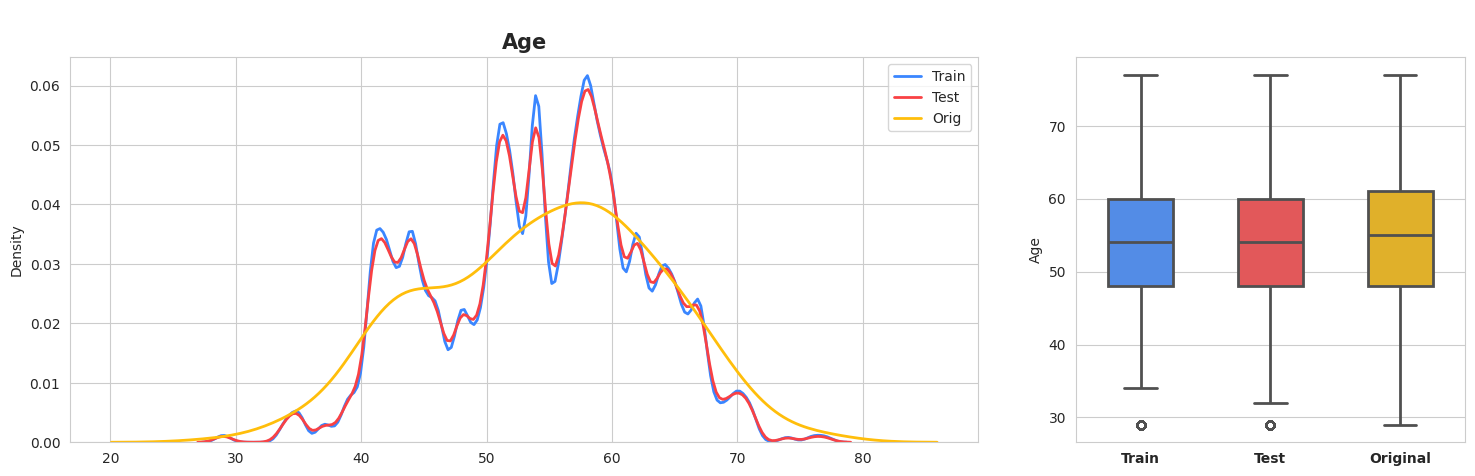

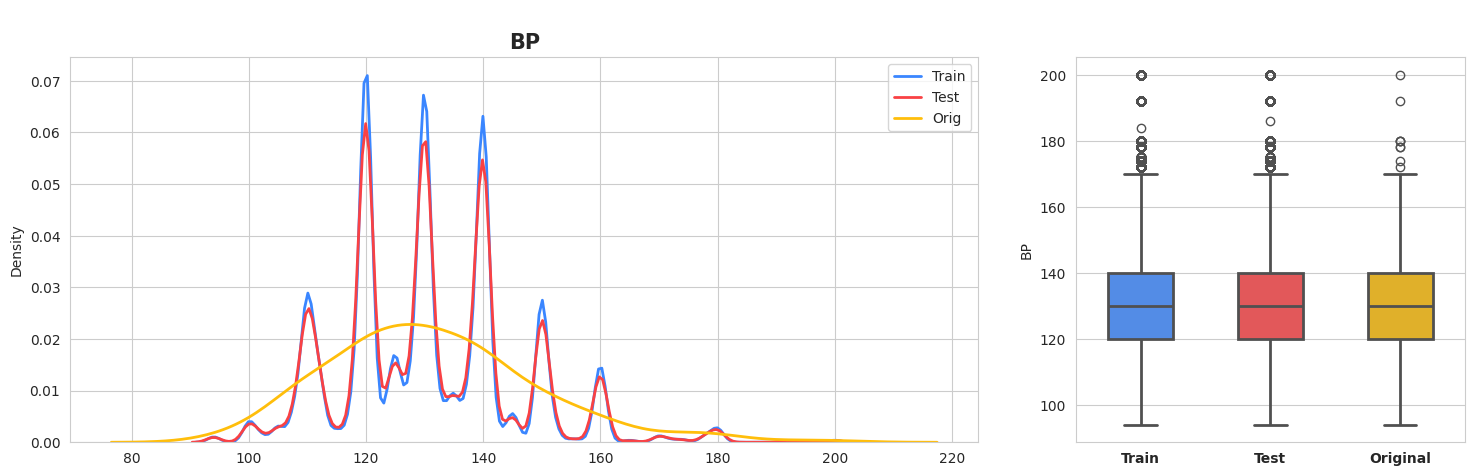

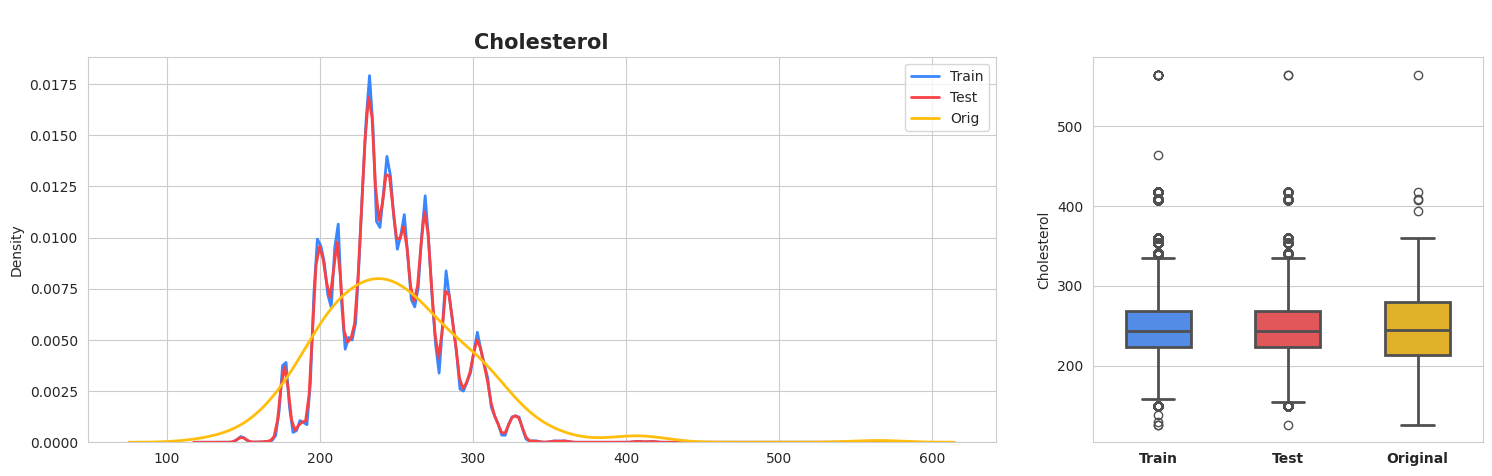

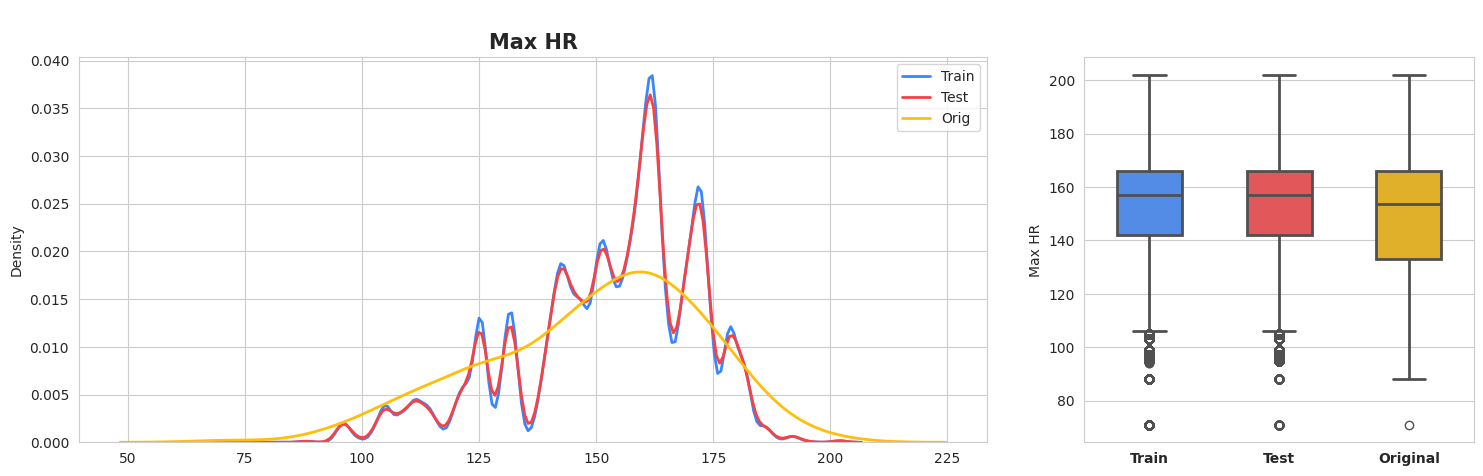

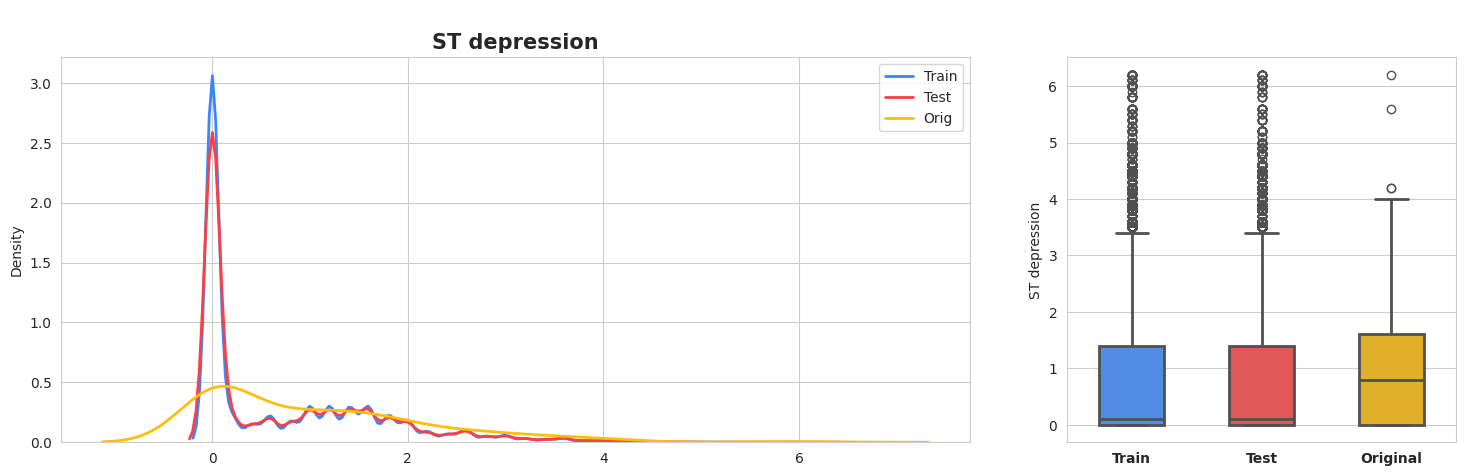

In [19]:
distplots_data(train, test, orig, NUMS)

## ~ CATEGORICAL

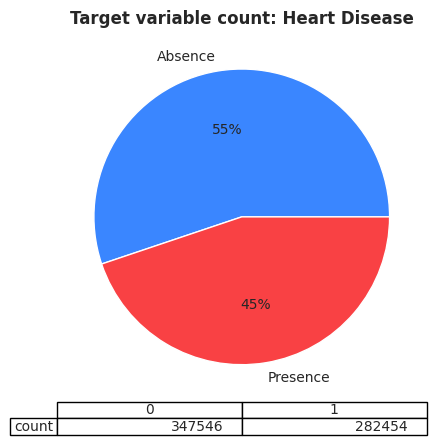

In [20]:
## -- TARGET COUNTS --
train[TARGET].value_counts(dropna=False).plot.pie(autopct='%1.0f%%', table=True, labels=['Absence', 'Presence'])
plt.title(f"Target variable count: {TARGET}", fontweight='semibold')
plt.show()

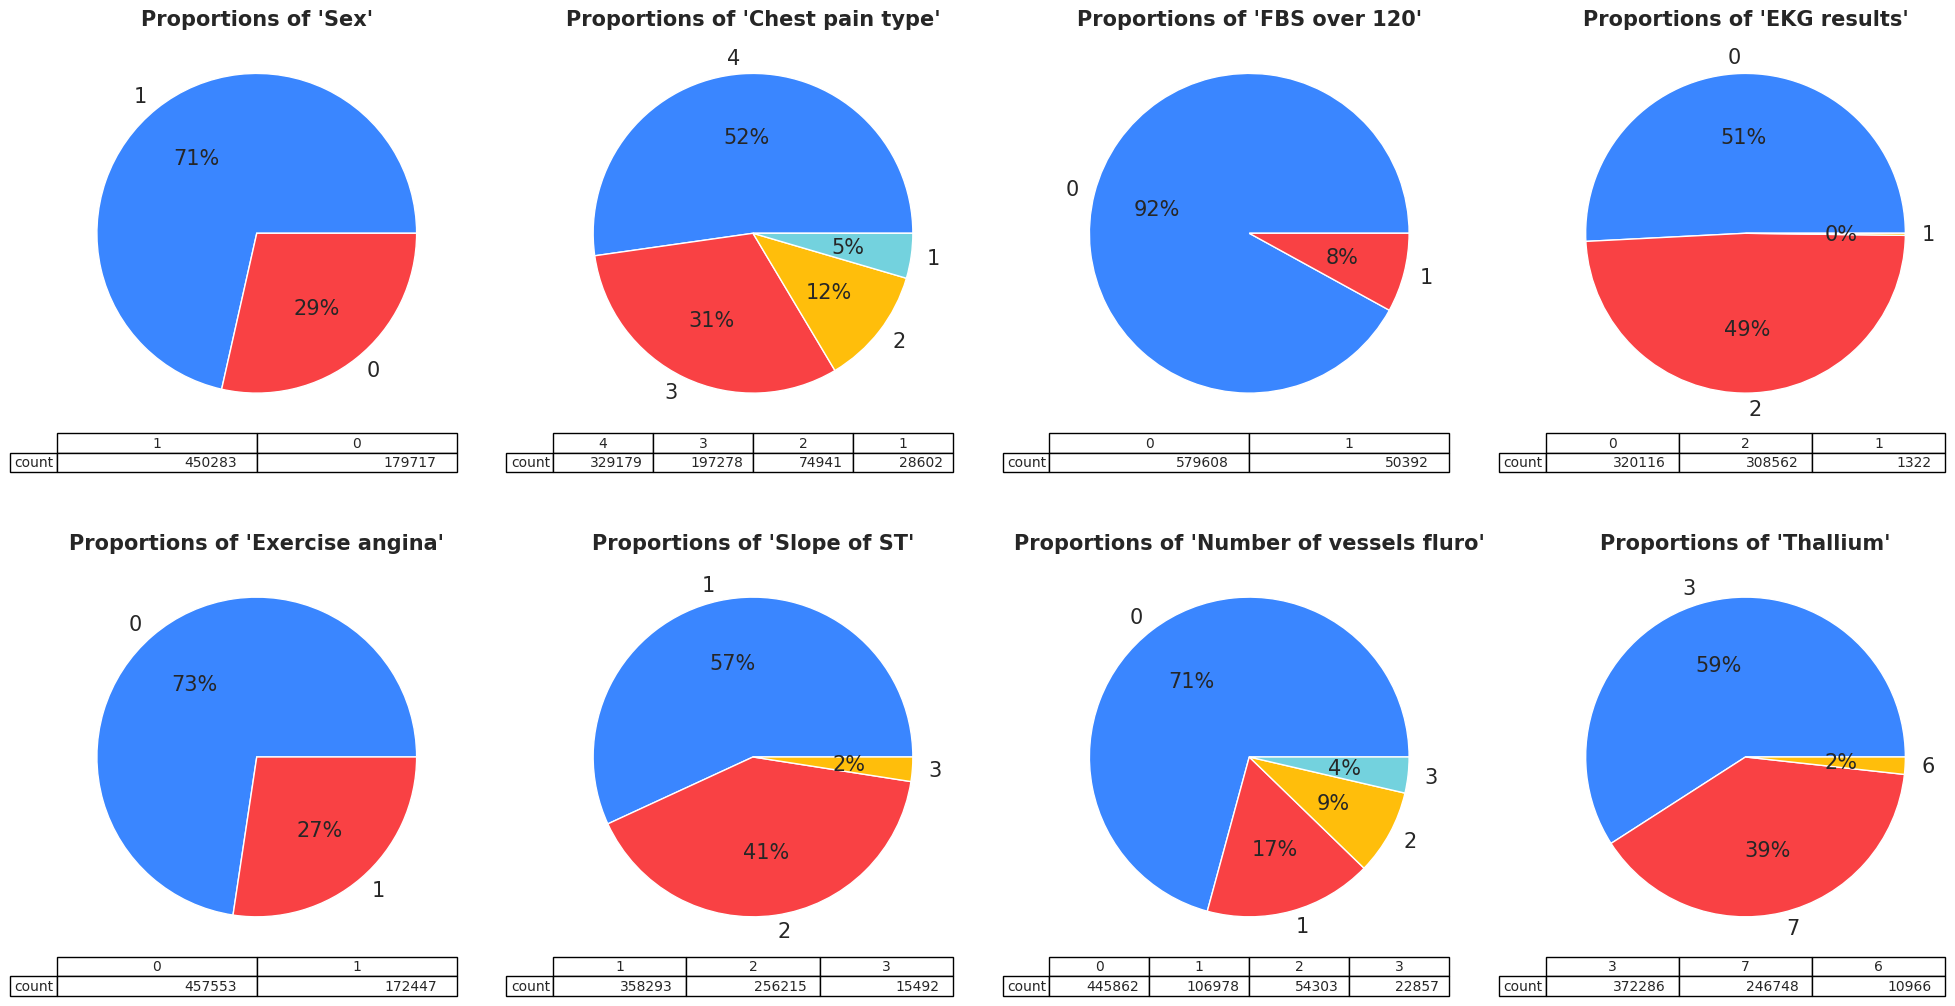

In [21]:
## -- Categorical Features --
plt.figure(figsize=(20, 15))
for i, col in enumerate(CATS):
    plt.subplot(3, 4, i+1)
    values=train[col].value_counts(dropna=False)
    values.plot.pie(autopct='%1.0f%%', fontsize=15, table=True)
    plt.title(f"Proportions of '{col}'", fontdict={'size':15, 'weight': 'bold'})
    plt.axis('off')

plt.tight_layout(h_pad=5.0)
plt.show()

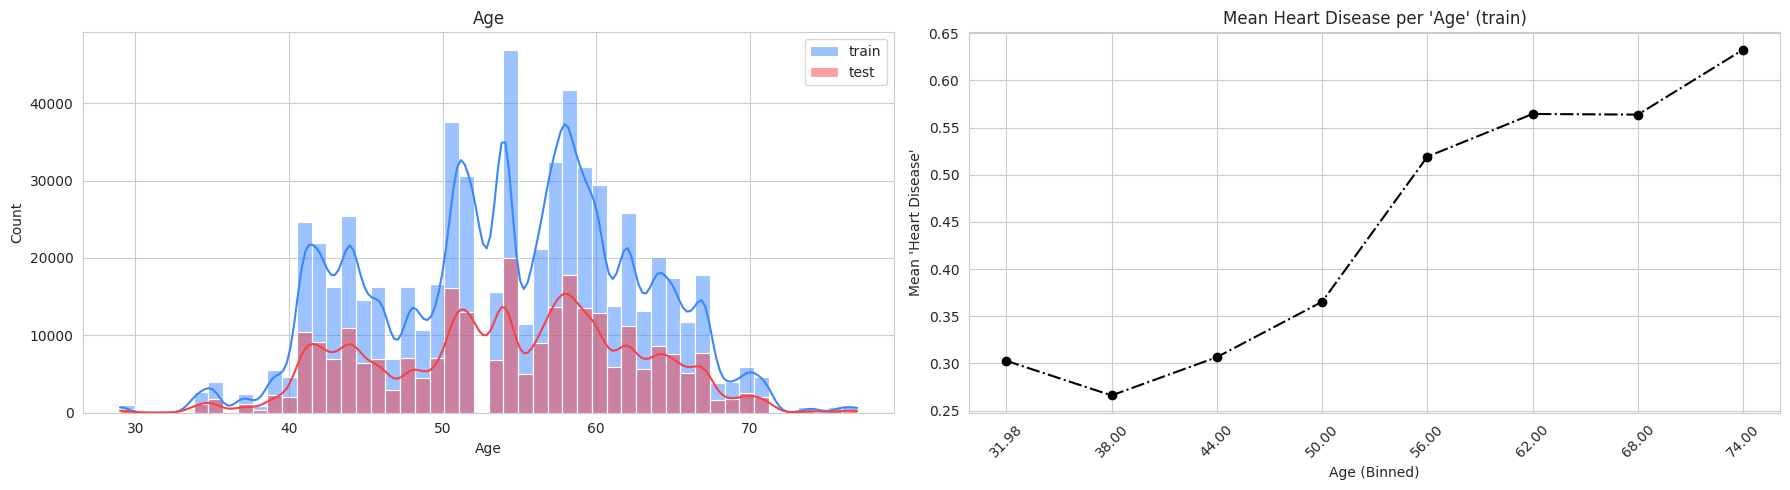

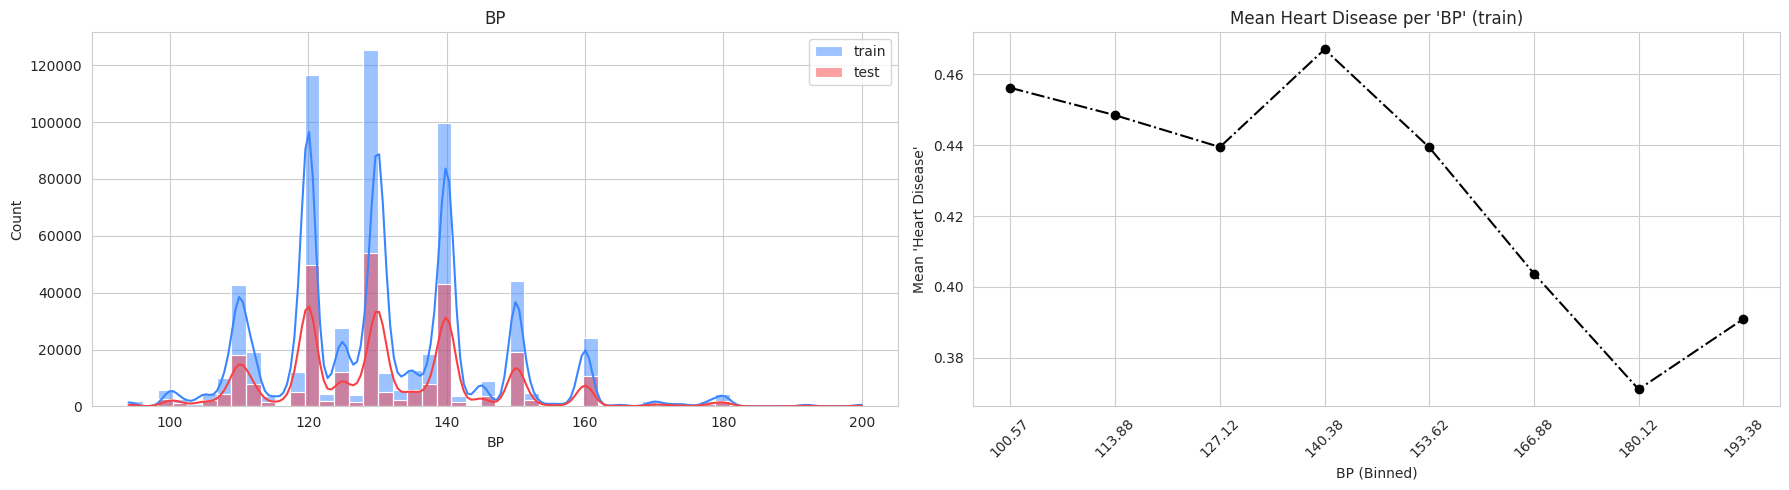

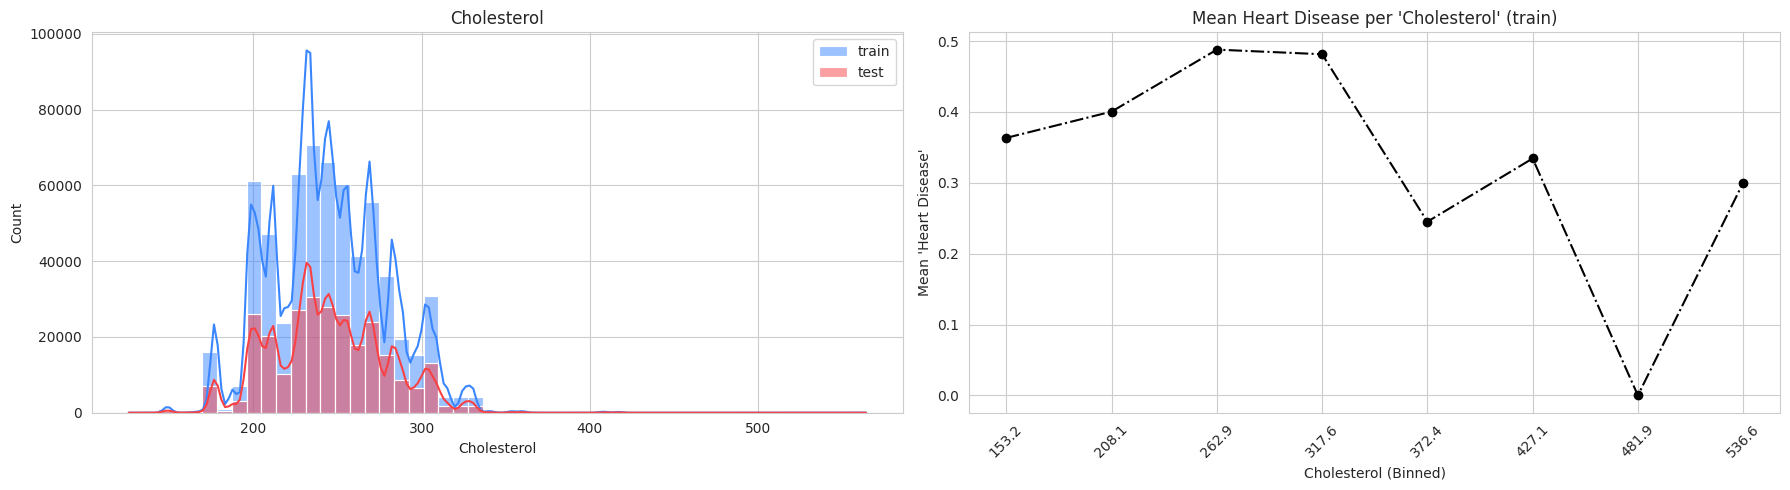

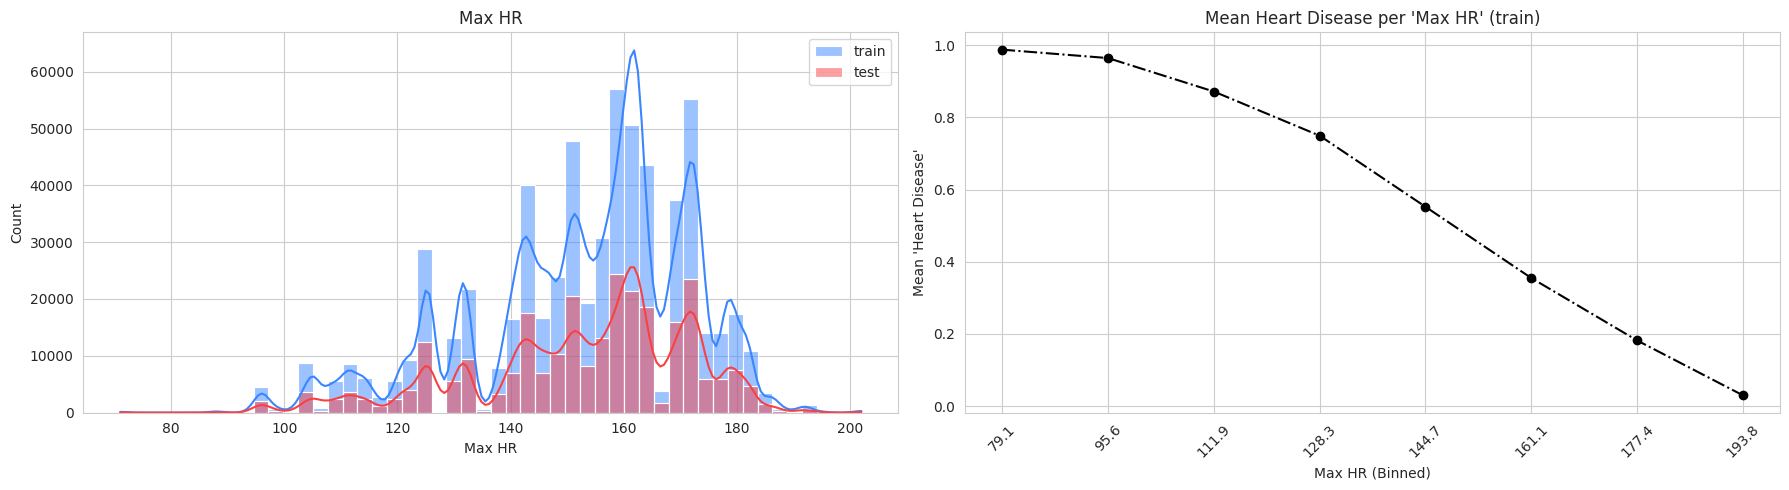

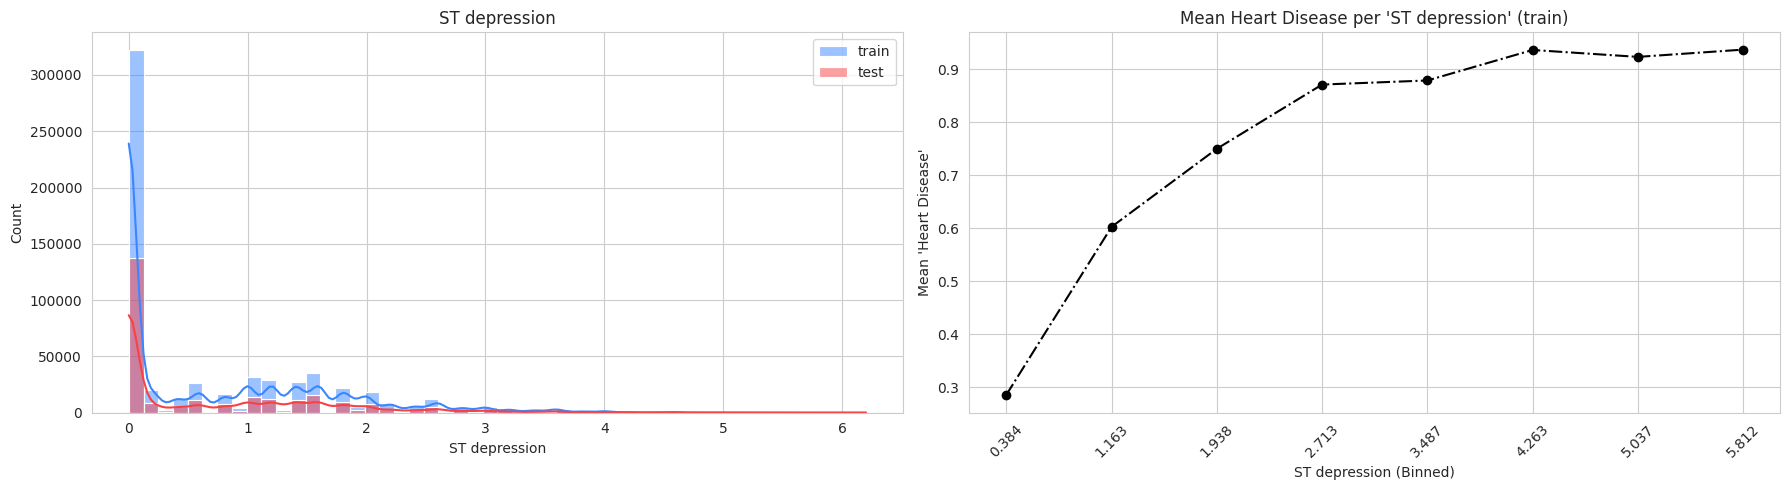

In [22]:
BINS = 8

for c in NUMS:
    # PLOT TRAIN DISTRIBUTION COMPARED WITH TEST DISTRIBUTION
    plt.figure(figsize=(18, 5))
    plt.subplot(121)
    sns.histplot(train[c],kde=True,bins=50,label='train',)
    sns.histplot(test[c],kde=True,bins=50,label='test',)
    plt.legend()
    plt.title(f"{c}")
    # PLOT TARGET RELATIONSHIP WITH BINNED BASE
    plt.subplot(122)
    train['bucket'], edges = pd.cut(train[c],bins=BINS,include_lowest=True,retbins=True,labels=False)
    bucket_means = train.groupby('bucket')[TARGET].mean()
    bin_midpoints = (edges[:-1] + edges[1:]) / 2
    plt.plot(bin_midpoints, bucket_means, marker='o',linestyle='-.',color='k')
    plt.xlabel(f'{c} (Binned)')
    plt.ylabel(f"Mean '{TARGET}'")
    plt.title(f"Mean {TARGET} per '{c}' (train)")
    plt.xticks(bin_midpoints, rotation=45)

    plt.tight_layout()
    plt.show()

train.drop(['bucket'], axis=1, inplace=True)

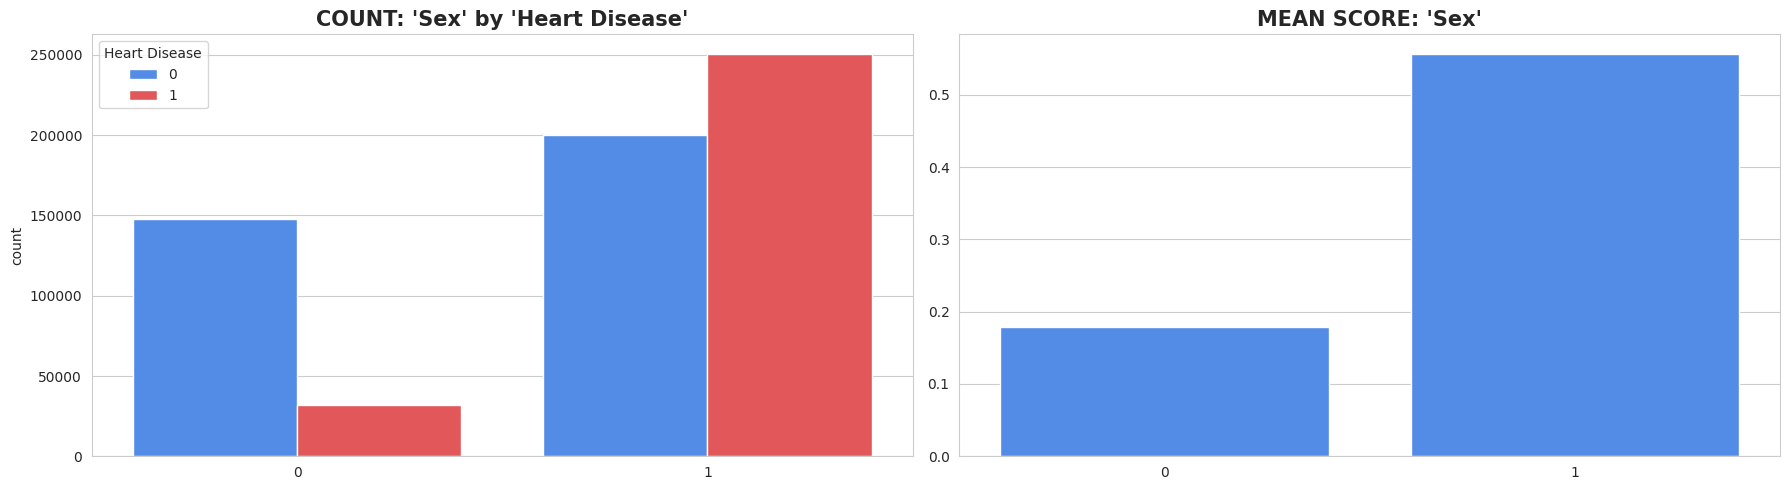

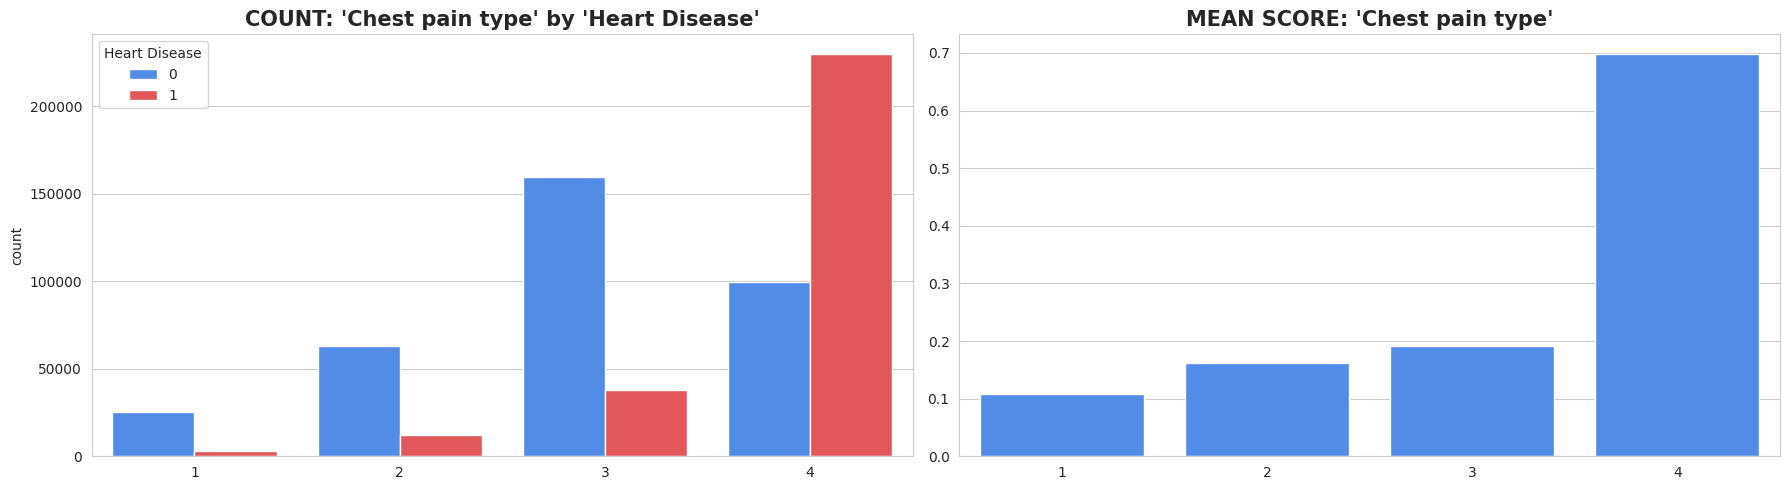

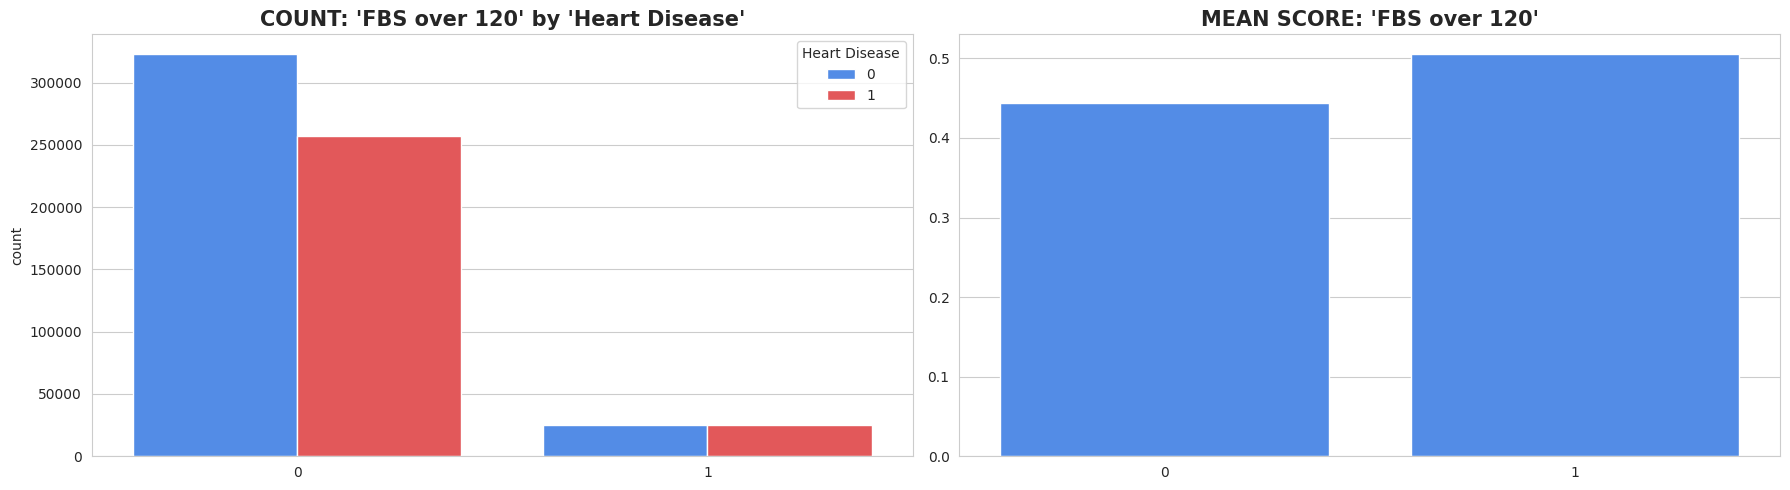

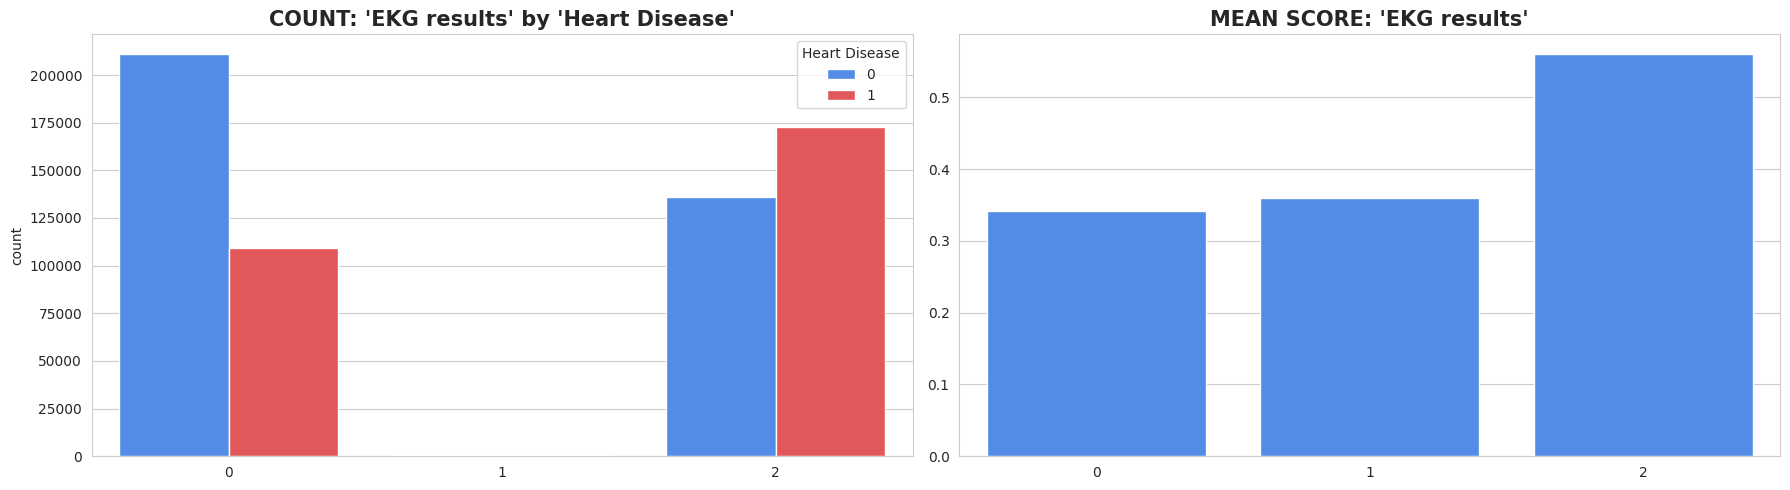

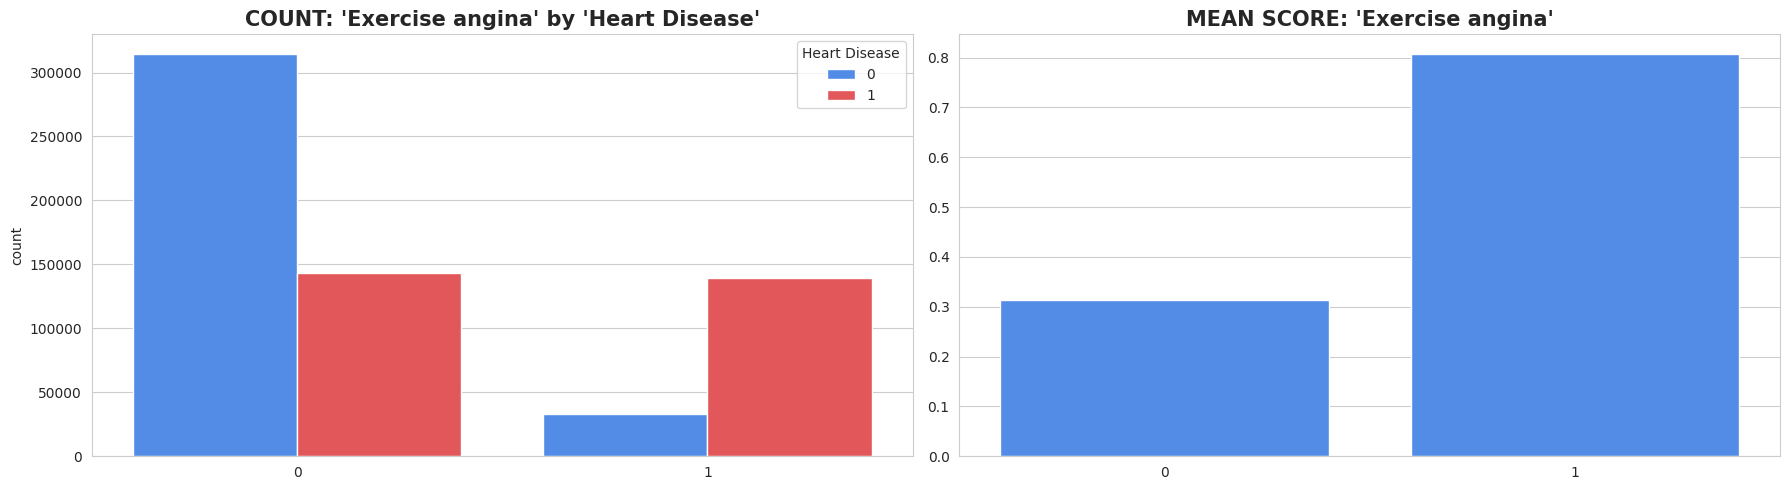

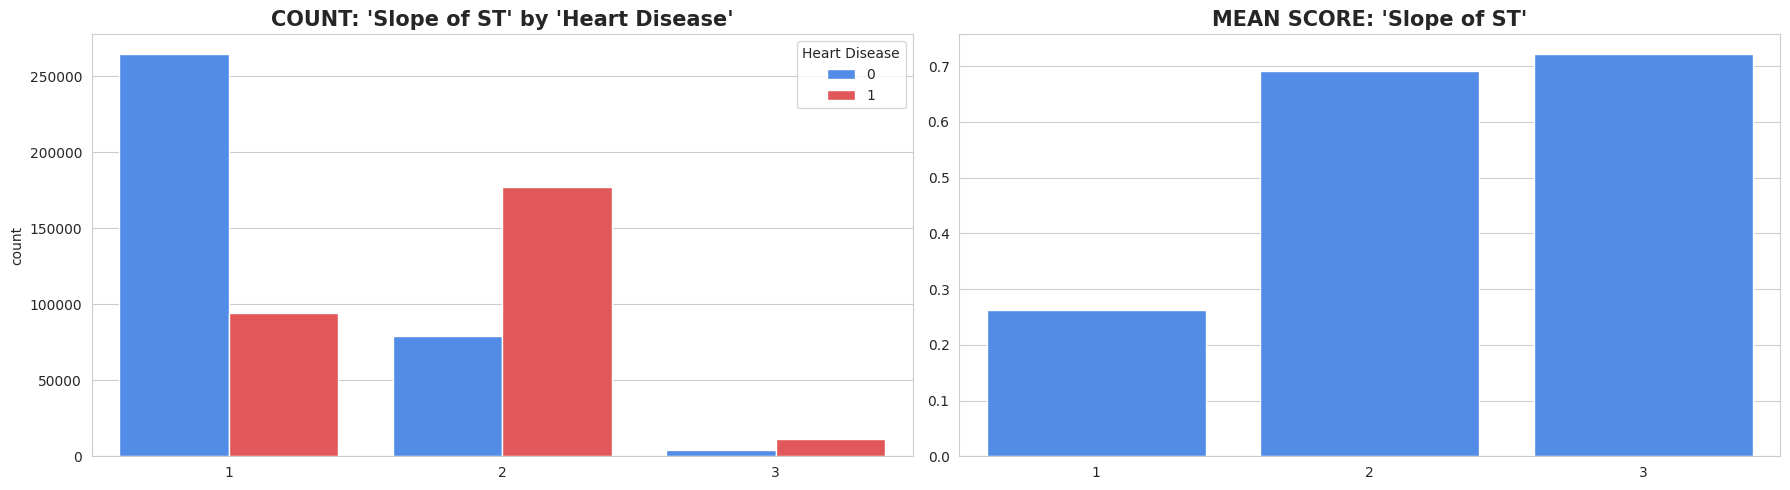

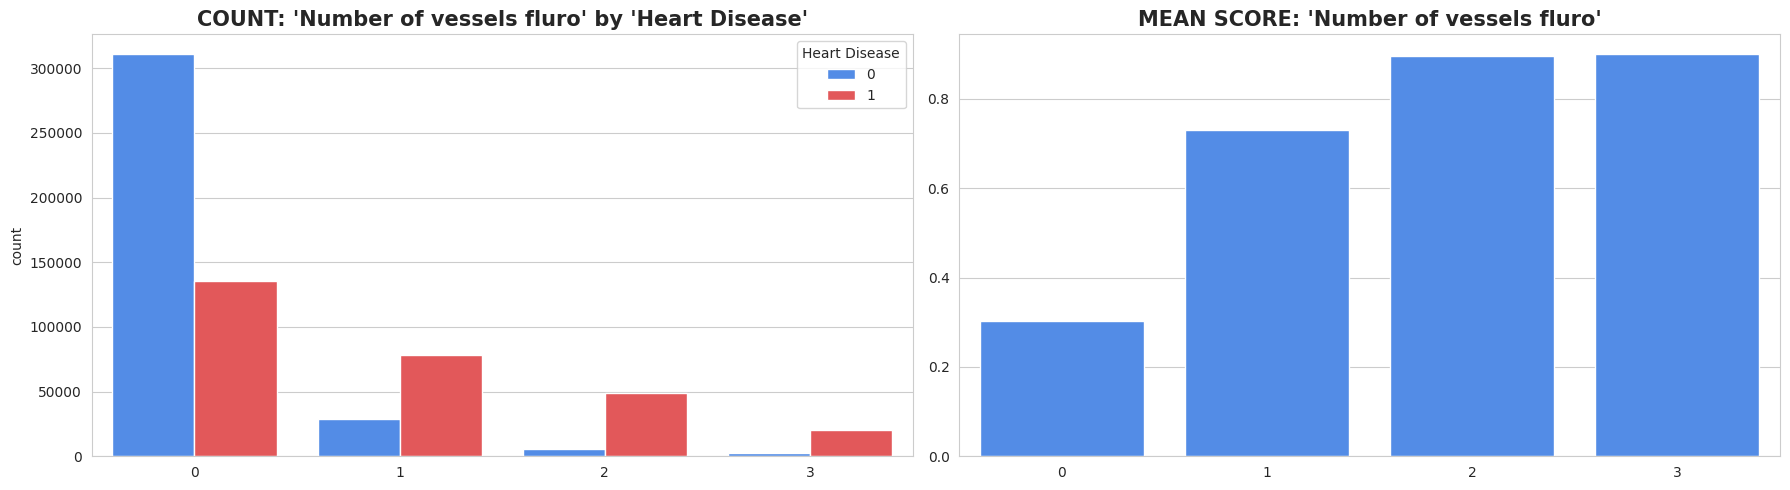

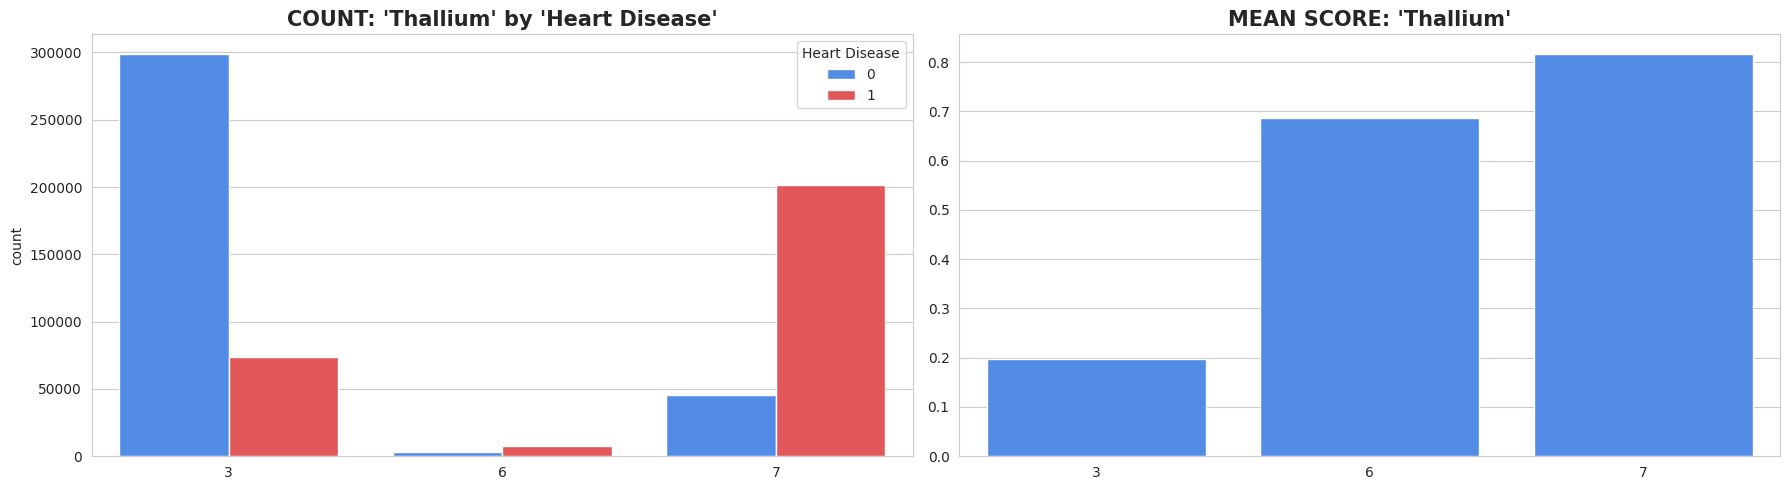

In [23]:
## -- Categorical Features: Counts and Mean by TARGET --
for i, c in enumerate(CATS):
    plt.figure(figsize=(18, 5))
    
    plt.subplot(121)
    sns.countplot(train, x=c, hue=TARGET)
    plt.title(f"COUNT: '{c}' by '{TARGET}'", fontdict={'size': 15, 'weight': 'semibold'})
    plt.xlabel('')
    
    plt.subplot(122)
    v_mean = train.groupby(c)[TARGET].mean().sort_values(ascending=False)
    sns.barplot(x=v_mean.index, y=v_mean.values)
    plt.title(f"MEAN SCORE: '{c}'", fontdict={'size': 15, 'weight': 'semibold'})
    plt.xlabel('')
    
    plt.tight_layout()
    plt.show()
    print()

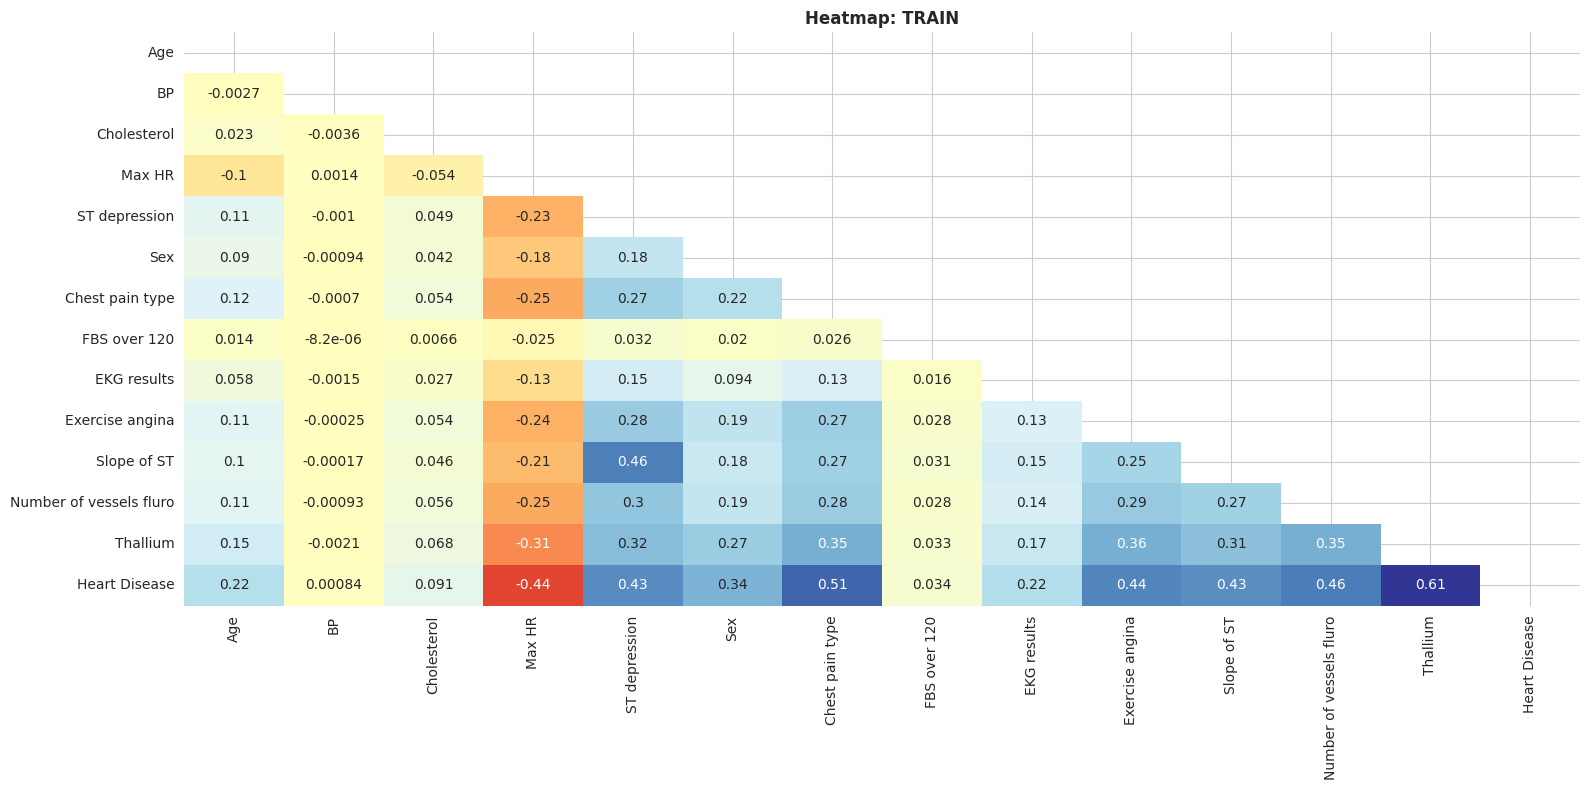

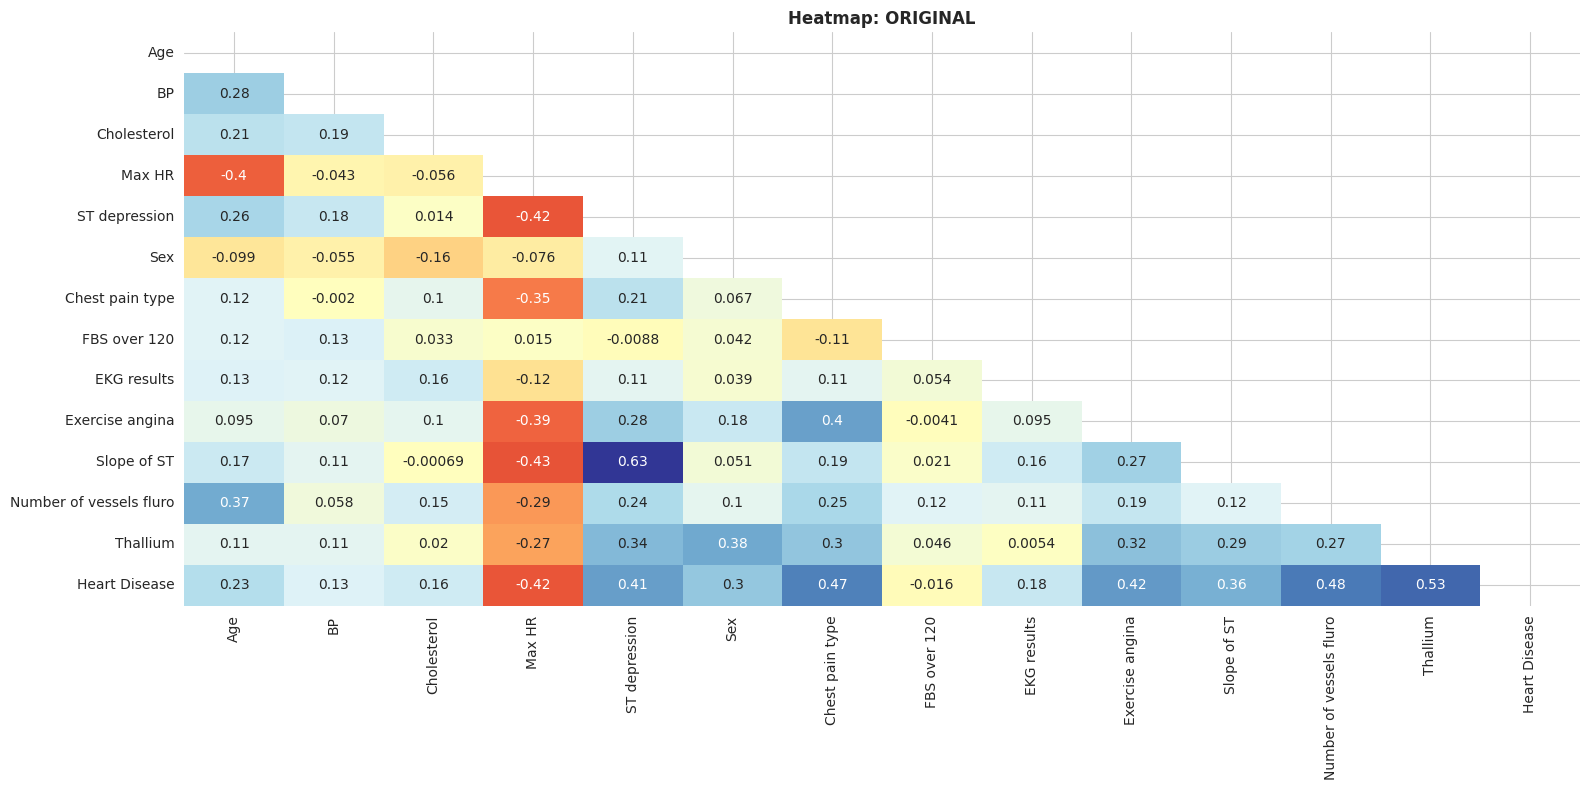

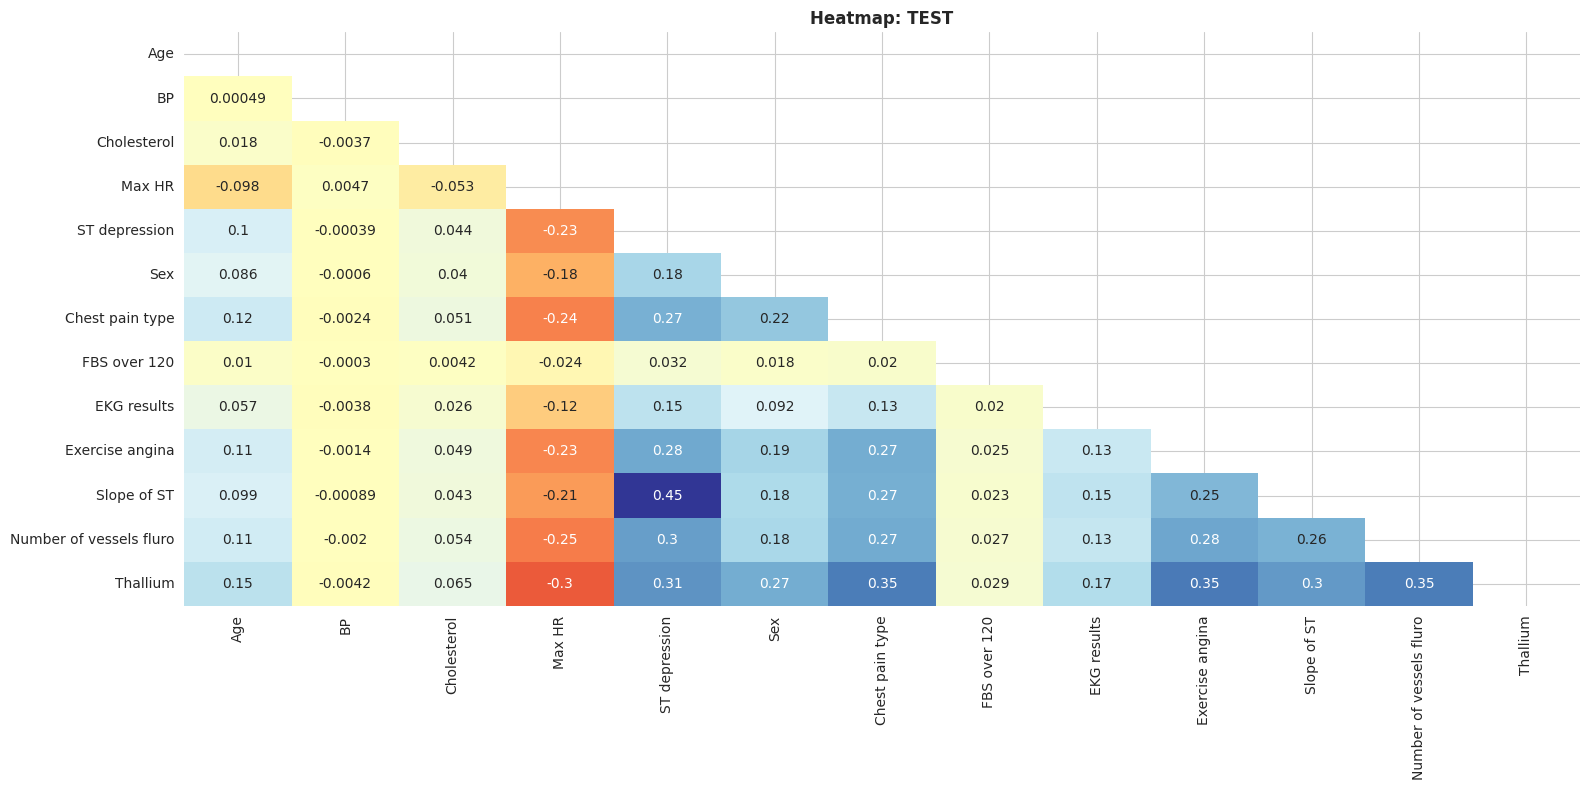

In [24]:
def plot_heatmap(data, cat_features, name='Data'):
    df = data.copy()
    for c in cat_features:
        if df[c].dtype in ['object', 'category']:
            df[c] = pd.factorize(df[c])[0]
    CORR = df.corr('spearman')
    plt.figure(figsize=(16, 8))
    sns.heatmap(CORR, mask=np.triu(CORR), annot=True, cmap='RdYlBu', cbar=False, center=0)
    plt.title(f"Heatmap: {name}", fontdict={'size':12, 'weight': 'semibold'})
    plt.tight_layout()
    plt.show()

    del df

plot_heatmap(train[BASE+[TARGET]], CATS, 'TRAIN')
plot_heatmap(orig[BASE+[TARGET]], CATS, 'ORIGINAL')
plot_heatmap(test[BASE], CATS, 'TEST')

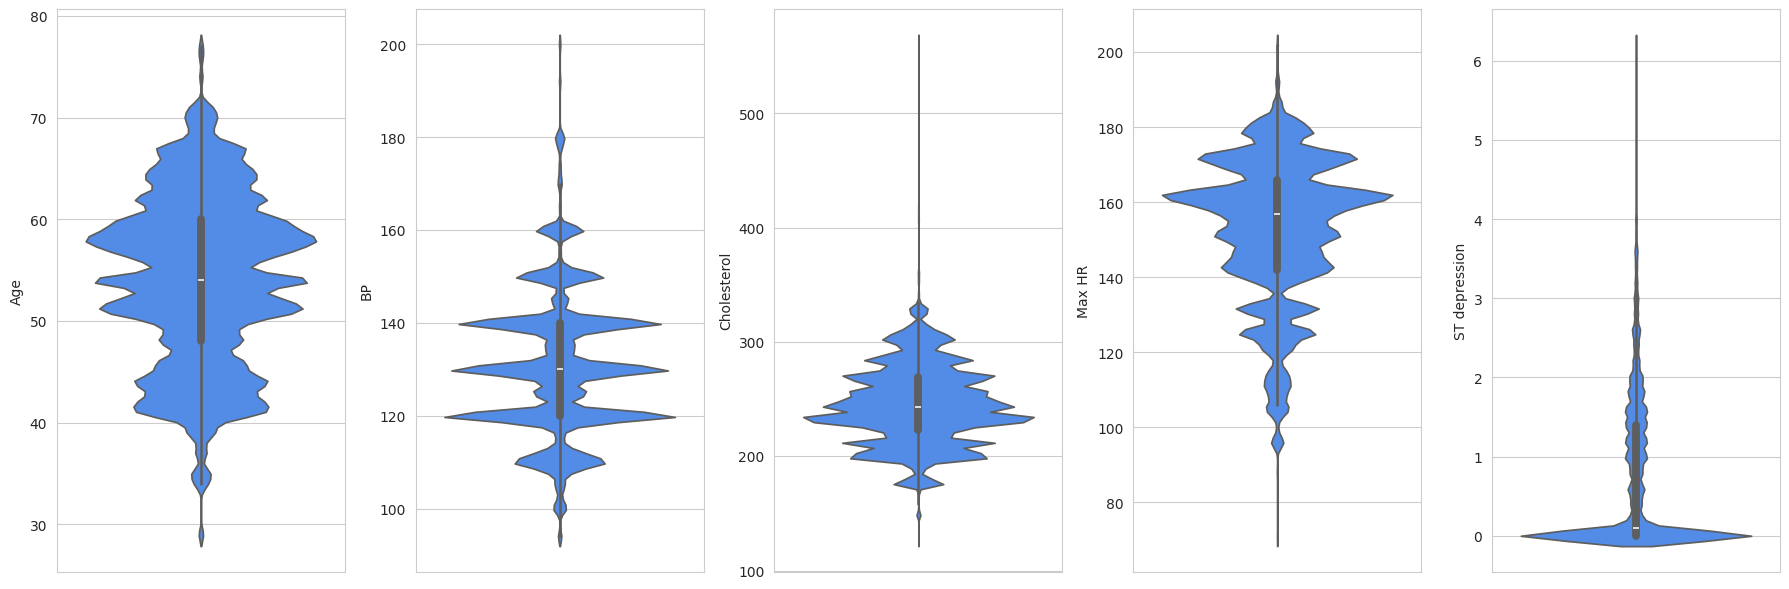

In [25]:
## -- VIOLIN PLOT --
plt.figure(figsize=(18, 6))
for i, col in enumerate(NUMS):
    plt.subplot(1, 5, i+1)
    sns.violinplot(train[col])

plt.tight_layout()
plt.show()

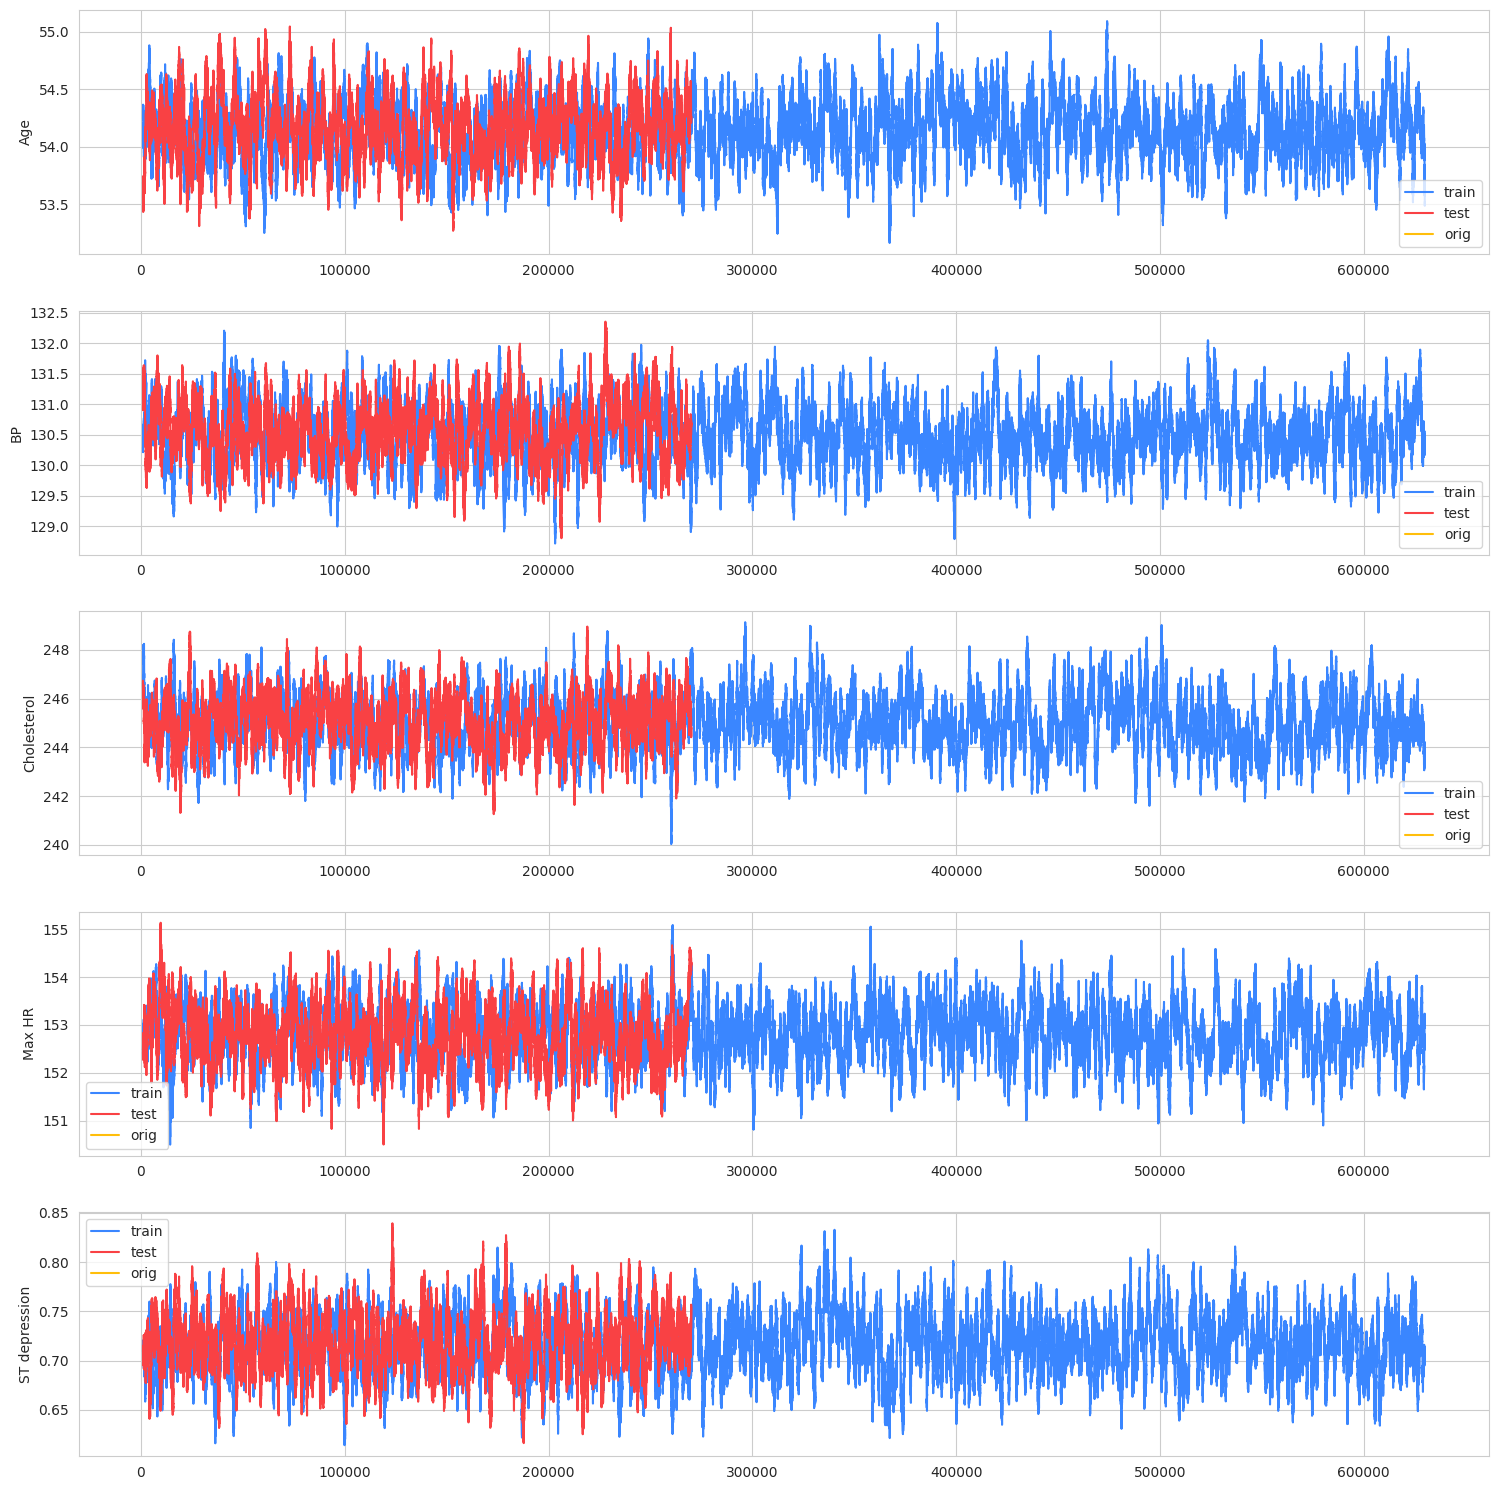

In [26]:
## -- DRIFT CHECK --
plt.figure(figsize=(15, 15))
for i, col in enumerate(NUMS):
    plt.subplot(5, 1, i+1)
    sns.lineplot(train[col].rolling(1000).mean(), label='train')
    sns.lineplot(test[col].rolling(1000).mean(), label='test')
    sns.lineplot(orig[col].rolling(1000).mean(), label='orig')

plt.legend()
plt.tight_layout(h_pad=2)
plt.show()

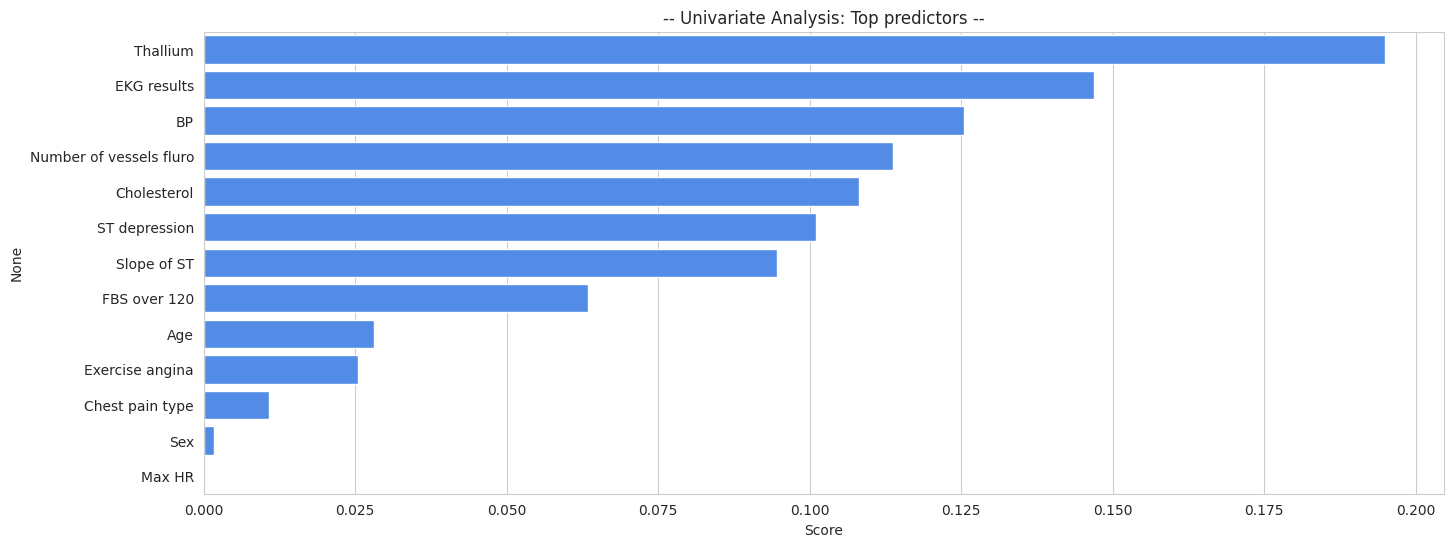

CPU times: user 50.4 s, sys: 58.6 ms, total: 50.5 s
Wall time: 50.5 s


In [27]:
%%time

## -- FEATURE MUTUAL INFO --
mutual_info = mutual_info_regression(train[BASE], train[TARGET])
mutual_info_df = pd.DataFrame.from_dict(
    dict(zip(test.columns.tolist(), list(mutual_info))),
    orient='index', columns=['Score'],
).sort_values(by='Score', ascending=False)

plt.figure(figsize=(16, 6))
sns.barplot(data=mutual_info_df, x='Score', y=mutual_info_df.index)
plt.title('-- Univariate Analysis: Top predictors --')
plt.show()

## 1. Kolmogorov-Smirnov (K-S) test

In [28]:
from scipy.stats import ks_2samp

def ks_driftcheck(df_1, df_2, df2_mame: str, features):
    df_train = df_1.copy()
    df_test  = df_2.copy()

    ks_stats_all = []
    cols = []
    threshold = 0.05

    print(f"{'feature':<20}\t{'ks-stat':<8}\t{'drift'}")
    print(f"{'-'*20:<20}\t{'-------':<8}\t{'-------'}")
    RED = '\033[33m'
    for c in features:
        ks_stat, p_val = np.round(ks_2samp(df_train[c].values, df_test[c].values), 4)
        if ks_stat >= threshold:
            print(f"{RED}{c:<20}\t{ks_stat:<8}\t⚠️ Drift{RESET}")
        else:
            print(f"{c:<20}\t{ks_stat:<8}\t✅ Safe!")

        ks_stats_all.append(ks_stat)
        cols.append(c)

    print()
    plt.barh(cols, ks_stats_all, color=['r' if c >= threshold else 'gray'for c in ks_stats_all])
    plt.axvline(x=threshold, linestyle='--', label=f'Drift threshold: {threshold}')
    plt.title(f"(K-S) drift test: TRAIN vs {df2_mame}", fontweight='semibold')
    plt.legend()
    plt.show()

    gc.collect()


feature             	ks-stat 	drift
--------------------	------- 	-------
Age                 	0.0022  	✅ Safe!
BP                  	0.0023  	✅ Safe!
Cholesterol         	0.0014  	✅ Safe!
Max HR              	0.0017  	✅ Safe!
ST depression       	0.0026  	✅ Safe!


Sex                 	0.0016  	✅ Safe!
Chest pain type     	0.0021  	✅ Safe!
FBS over 120        	0.0001  	✅ Safe!
EKG results         	0.0016  	✅ Safe!
Exercise angina     	0.0009  	✅ Safe!
Slope of ST         	0.0031  	✅ Safe!
Number of vessels fluro	0.0022  	✅ Safe!
Thallium            	0.0003  	✅ Safe!



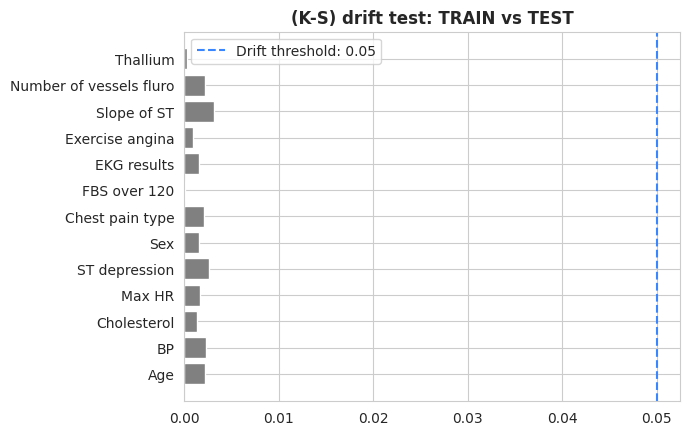

In [29]:
## -- Drift test for TRAIN & TEST --
ks_driftcheck(train, test, 'TEST', BASE)

feature             	ks-stat 	drift
--------------------	------- 	-------
Age                 	0.0433  	✅ Safe!
BP                  	0.0555  	⚠️ Drift
Cholesterol         	0.0976  	⚠️ Drift
Max HR              	0.0868  	⚠️ Drift
ST depression       	0.1851  	⚠️ Drift
Sex                 	0.037   	✅ Safe!
Chest pain type     	0.0653  	⚠️ Drift
FBS over 120        	0.0682  	⚠️ Drift
EKG results         	0.0229  	✅ Safe!
Exercise angina     	0.0559  	⚠️ Drift
Slope of ST         	0.0872  	⚠️ Drift


Number of vessels fluro	0.1151  	⚠️ Drift
Thallium            	0.028   	✅ Safe!
Heart Disease       	0.0039  	✅ Safe!



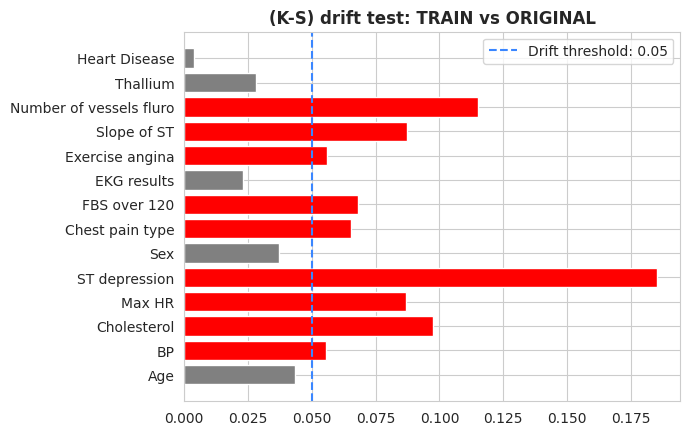

In [30]:
## -- Drift test for TRAIN & ORIGINAL --
ks_driftcheck(train, orig, 'ORIGINAL', BASE+[TARGET])

In [31]:
# try:
#     from evidently import Dataset
#     from evidently import DataDefinition
#     from evidently import Report
#     from evidently.presets import DataDriftPreset, DataSummaryPreset 
# except:
#     !pip install -qq -U evidently
#     from evidently import Dataset
#     from evidently import DataDefinition
#     from evidently import Report
#     from evidently.presets import DataDriftPreset, DataSummaryPreset

# def evid_driftcheck(df_1, df_2, features, nums, cats):
    
#     schema = DataDefinition(numerical_columns=nums, categorical_columns=cats)

#     train_df = Dataset.from_pandas(df_1[features], data_definition=schema)
#     test_df = Dataset.from_pandas(df_2[features], data_definition=schema)
    
#     report = Report([DataDriftPreset()])
#     my_eval = report.run(train_df, test_df)
#     display(my_eval)

In [32]:
# ## -- Drift test for TRAIN & TEST --
# evid_driftcheck(train, test, BASE, NUMS, CATS)

In [33]:
# ## -- Drift test for TRAIN & ORIGINAL --
# evid_driftcheck(train, orig, train.columns, NUMS, CATS+[TARGET])

In [34]:
USE_ORIG_COL = False

ORIG = []

if USE_ORIG_COL:
    for col in tqdm(BASE): 
        # # MEAN
        # mean_col = f"OTE_{col}_mean"
        # mean_map = orig.groupby(col)[TARGET].mean().reset_index(name=mean_col)
    
        # train = train.merge(mean_map, on=col, how='left')
        # test = test.merge(mean_map, on=col, how='left')
        # ORIG.append(mean_col)
    
        # COUNT
        count_col = f"OTE_{col}_count"
        count_map = orig.groupby(col).size().reset_index(name=count_col)
    
        train = train.merge(count_map, on=col, how='left')
        test = test.merge(count_map, on=col, how='left')
        ORIG.append(count_col)
    
        # MEDIAN
        median_col = f"OTE_{col}_median"
        median_map = orig.groupby(col)[TARGET].median().reset_index(name=median_col).astype('float32')
    
        train = train.merge(median_map, on=col, how='left')
        test = test.merge(median_map, on=col, how='left')
        ORIG.append(median_col)
    
        # UNIQUE
        unique_col = f"OTE_{col}_nunique"
        unique_map = orig.groupby(col)[TARGET].nunique().reset_index(name=unique_col)
    
        train = train.merge(unique_map, on=col, how='left')
        test = test.merge(unique_map, on=col, how='left')
        ORIG.append(unique_col)
    
        # STD
        std_col = f"OTE_{col}_std"
        std_map = orig.groupby(col)[TARGET].std().reset_index(name=std_col)
    
        train = train.merge(std_map, on=col, how='left')
        test = test.merge(std_map, on=col, how='left')
        ORIG.append(std_col)
    
        # MAX
        max_col = f"OTE_{col}_max"
        max_map = orig.groupby(col)[TARGET].max().reset_index(name=max_col)
    
        train = train.merge(max_map, on=col, how='left')
        test = test.merge(max_map, on=col, how='left')
        ORIG.append(max_col)
    
        # # MIN
        # min_col = f"OTE_{col}_min"
        # min_map = orig.groupby(col)[TARGET].min().reset_index(name=min_col)
    
        # train = train.merge(min_map, on=col, how='left')
        # test = test.merge(min_map, on=col, how='left')
        # ORIG.append(min_col)

# for col in ORIG:
#     if train[col].nunique() < 2:
#         train.drop([col], axis=1, inplace=True)
#         test.drop([col], axis=1, inplace=True)
#         ORIG.remove(col)
#     else:
#         continue

print(len(ORIG), 'Orig Features Created!')

0 Orig Features Created!


In [35]:
"""
----- orig TargetEncoding merge -----
xgb  > ['count']
lgb  > ['count', 'median', 'nunique', 'std', 'max']
cat  > ['median']
hist > ['count', 'median', 'nunique', 'std', 'max', 'min']
"""

"\n----- orig TargetEncoding merge -----\nxgb  > ['count']\nlgb  > ['count', 'median', 'nunique', 'std', 'max']\ncat  > ['median']\nhist > ['count', 'median', 'nunique', 'std', 'max', 'min']\n"

In [36]:
# skew_col = orig.groupby('ST depression')[TARGET].skew().reset_index(name='skew_col').astype('float32')
# skew_col

In [37]:
def orig_TE_data_propagate(orig: pd.DataFrame,
                          X_train: pd.DataFrame,
                          X_val: pd.DataFrame,
                          X_test: pd.DataFrame,
                          features: list = None,
                          aggs: list = None,
                          fill_nan: bool = False):
    """
    Improve propagation of engineered features by:
    - Allowing multiple aggregations per feature (e.g., ['mean', 'median']).
    - Reusing per-(col, agg) maps to minimize recomputation.
    - Optional global NaN filling after merges (fill_nan: True/False).
    - Using a consistent NaN-based missing-value strategy (fill later if needed).
    - Maintaining clear dtype management.

    Parameters:
    - fill_nan: If True, fill NaNs in the newly created features with a sentinel value.
      Float features use -1e9, integer features use -1. If downstream needs different
      behavior, we can adjust or apply a separate imputation step later.
    """
    if features is None or len(features) == 0:
        return X_train.copy(), X_val.copy(), X_test.copy(), []

    if aggs is None or len(aggs) == 0:
        return X_train.copy(), X_val.copy(), X_test.copy(), []

    X_train_df = X_train.copy()
    X_val_df   = X_val.copy()
    X_test_df  = X_test.copy()
    ORIG = []

    maps = {}

    valid_features = [col for col in features if col in orig.columns]

    # Optional: decide sentinel depending on dtype later; we assume numeric targets
    SENTINEL_FLOAT = 9e-6
    SENTINEL_INT = -1

    for col in tqdm(valid_features, desc='TE_merging'):
        for agg_ in aggs:
            agg_key = agg_.lower()
            new_col = f"OTE_{col}_{agg_key}"

            map_key = (col, agg_key)
            if map_key not in maps:
                try:
                    if agg_key == 'mean':
                        map_df = (orig.groupby(col)[TARGET]
                                  .mean()
                                  .reset_index(name=new_col)
                                  # .astype('float32')
                                 )
                    elif agg_key == 'median':
                        map_df = (orig.groupby(col)[TARGET]
                                  .median()
                                  .reset_index(name=new_col)
                                  # .astype('float32')
                                 )
                    elif agg_key == 'count':
                        map_df = (orig.groupby(col).size()
                                  .reset_index(name=new_col)
                                  # .astype('int32')
                                 )
                    elif agg_key == 'std':
                        map_df = (orig.groupby(col)[TARGET]
                                  .std()
                                  .reset_index(name=new_col)
                                  # .astype('float32')
                                 )
                    elif agg_key == 'skew':
                        map_df = (orig.groupby(col)[TARGET]
                                  .skew()
                                  .reset_index(name=new_col)
                                  # .astype('float32')
                                 )
                    elif agg_key == 'nunique':
                        map_df = (orig.groupby(col)[TARGET]
                                  .nunique()
                                  .reset_index(name=new_col)
                                  # .astype('int32')
                                 )
                    elif agg_key == 'max':
                        map_df = (orig.groupby(col)[TARGET]
                                  .max()
                                  .reset_index(name=new_col)
                                  # .astype('float32')
                                 )
                    elif agg_key == 'min':
                        map_df = (orig.groupby(col)[TARGET]
                                  .min()
                                  .reset_index(name=new_col)
                                  # .astype('float32')
                                 )
                    else:
                        continue
                except Exception as e:
                    print(f"Warning: failed to create map for col={col}, agg={agg_}: {e}")
                    continue

                maps[map_key] = map_df

            map_df = maps.get(map_key)
            if map_df is None:
                continue

            # Merge maps into each split
            X_train_df = X_train_df.merge(map_df, on=col, how='left')
            X_val_df   = X_val_df.merge(map_df, on=col, how='left')
            X_test_df  = X_test_df.merge(map_df, on=col, how='left')

            ORIG.append(new_col)

    # Optional post-processing: fill NaNs if requested
    if fill_nan:
        # Determine which columns were created in this run
        created_cols = ORIG

        # Fill floats with SENTINEL_FLOAT, ints with SENTINEL_INT
        for df in [X_train_df, X_val_df, X_test_df]:
            for c in created_cols:
                if c not in df.columns:
                    continue
                # Inspect dtype to decide sentinel
                if pd.api.types.is_float_dtype(df[c]):
                    df[c] = df[c].fillna(SENTINEL_FLOAT)
                elif pd.api.types.is_integer_dtype(df[c]):
                    df[c] = df[c].fillna(SENTINEL_INT)
                else:
                    # Fallback for other dtypes
                    df[c] = df[c].astype('float32').fillna(SENTINEL_FLOAT)

    return X_train_df, X_val_df, X_test_df, ORIG

In [38]:
def orig_TE_data(orig, X_train, X_val, X_test, features: list=None, aggs: list=None):
    '''
    Dtype conversions apply differently accross datasets.
    Check dtype of respected columns for proper casting. (int or float)
    ------------- ------------- ------------- ------------- -------------
    Example:
    for col in BASE:
        for agg_ in ['mean', 'count', 'median', 'nunique', 'std', 'max', 'min']:
            get = df.groupby(col)[TARGET].agg([agg_])
            print(f"{agg_:>25} {col:<15} : Min > {get.min().item():<3} | Max > {get.max().item()}")
            # break
    '''
    orig_df    = orig.copy()
    X_train_df = X_train.copy()
    X_val_df   = X_val.copy()
    X_test_df  = X_test.copy()
    ORIG = []
    
    for col in tqdm(features, desc='TE_merging'): 
        if 'mean' in aggs:
        ## -- MEAN
            mean_col = f"OTE_{col}_mean"
            mean_map = orig_df.groupby(col)[TARGET].mean().reset_index(name=mean_col)#.astype('float32')
        
            X_train_df = X_train_df.merge(mean_map, on=col, how='left')
            X_val_df = X_val_df.merge(mean_map, on=col, how='left')
            X_test_df = X_test_df.merge(mean_map, on=col, how='left')
            ORIG.append(mean_col)
    
        ## -- MEDIAN --
        elif 'median' in aggs:
            median_col = f"OTE_{col}_median"
            median_map = orig_df.groupby(col)[TARGET].median().reset_index(name=median_col)#.fillna(-1e-6).astype('float32')
        
            X_train_df = X_train_df.merge(median_map, on=col, how='left')
            X_val_df = X_val_df.merge(median_map, on=col, how='left')
            X_test_df = X_test_df.merge(median_map, on=col, how='left')
            ORIG.append(median_col)
    
        ## -- COUNT
        elif 'count' in aggs:
            count_col = f"OTE_{col}_count"
            count_map = orig_df.groupby(col).size().reset_index(name=count_col)#.fillna(-1).astype('int32')
        
            X_train_df = X_train_df.merge(count_map, on=col, how='left')
            X_val_df = X_val_df.merge(count_map, on=col, how='left')
            X_test_df = X_test_df.merge(count_map, on=col, how='left')
            ORIG.append(count_col)

        ## -- STD --
        elif 'std' in aggs:
            std_col = f"OTE_{col}_std"
            std_map = orig_df.groupby(col)[TARGET].std().reset_index(name=std_col)#.fillna(-1e-6).astype('float32')
        
            X_train_df = X_train_df.merge(std_map, on=col, how='left')
            X_val_df   = X_val_df.merge(std_map, on=col, how='left')
            X_test_df  = X_test_df.merge(std_map, on=col, how='left')
            ORIG.append(std_col)

        ## -- STD --
        elif 'skew' in aggs:
            skew_col = f"OTE_{col}_skew"
            skew_map = orig_df.groupby(col)[TARGET].skew().reset_index(name=skew_col)#.fillna(-1e-6).astype('float32')
        
            X_train_df = X_train_df.merge(skew_map, on=col, how='left')
            X_val_df   = X_val_df.merge(skew_map, on=col, how='left')
            X_test_df  = X_test_df.merge(skew_map, on=col, how='left')
            ORIG.append(skew_col)

        ## -- NUNIQUE --
        elif 'nunique' in aggs:
            unique_col = f"OTE_{col}_nunique"
            unique_map = orig_df.groupby(col)[TARGET].nunique().reset_index(name=unique_col)#.fillna(-1).astype('int32')
        
            X_train_df = X_train_df.merge(unique_map, on=col, how='left')
            X_val_df   = X_val_df.merge(unique_map, on=col, how='left')
            X_test_df  = X_test_df.merge(unique_map, on=col, how='left')
            ORIG.append(unique_col)
    
        ## -- MAX --
        elif 'max' in aggs:
            max_col = f"OTE_{col}_max"
            max_map = orig_df.groupby(col)[TARGET].max().reset_index(name=max_col)#.fillna(-1e-6).astype('float32')
        
            X_train_df = X_train_df.merge(max_map, on=col, how='left')
            X_val_df   = X_val_df.merge(max_map, on=col, how='left')
            X_test_df  = X_test_df.merge(max_map, on=col, how='left')
            ORIG.append(max_col)

        ## -- MIN --
        elif 'min' in aggs:
            min_col = f"OTE_{col}_min"
            min_map = orig_df.groupby(col)[TARGET].min().reset_index(name=min_col)#.fillna(-1e-6).astype('float32')
        
            X_train_df = X_train_df.merge(min_map, on=col, how='left')
            X_val_df   = X_val_df.merge(min_map, on=col, how='left')
            X_test_df  = X_test_df.merge(min_map, on=col, how='left')
            ORIG.append(min_col)

    # for col in ORIG:
    #     if X_train_df[col].nunique() < 2:
    #         X_train_df.drop([col], axis=1, inplace=True)
    #         X_val_df.drop([col], axis=1, inplace=True)
    #         ORIG.remove(col)
    #     else:
    #         continue

    return X_train_df, X_val_df, X_test_df, ORIG

In [39]:
# for col in BASE:
#     for agg_ in ['mean', 'median', 'count', 'std', 'skew', 'nunique', 'max', 'min']:
#         get = orig.groupby(col)[TARGET].agg([agg_])
#         print(f"{agg_:>25} {col:<15} :: Min > {get.min().item():<3} | Max > {get.max().item()}")
#         # break

In [40]:
from sklearn.base import BaseEstimator, TransformerMixin

class TargetEncoder(BaseEstimator, TransformerMixin):
    """
    Target Encoder that supports multiple aggregation functions,
    internal cross-validation for leakage prevention, and smoothing.

    Parameters
    ----------
    cols_to_encode : list of str
        List of column names to be target encoded.

    aggs : list of str, default=['mean']
        List of aggregation functions to apply. Any function accepted by
        pandas' `.agg()` method is supported, such as:
        'mean', 'std', 'var', 'min', 'max', 'skew', 'nunique', 
        'count', 'sum', 'median'.
        Smoothing is applied only to the 'mean' aggregation.

    cv : int, default=5
        Number of folds for cross-validation in fit_transform.

    smooth : float or 'auto', default='auto'
        The smoothing parameter `m`. A larger value puts more weight on the 
        global mean. If 'auto', an empirical Bayes estimate is used.
        
    drop_original : bool, default=False
        If True, the original columns to be encoded are dropped.
    """
    def __init__(self, cols_to_encode, aggs=['mean'], cv=5, smooth='auto', drop_original=False):
        self.cols_to_encode = cols_to_encode
        self.aggs = aggs
        self.cv = cv
        self.smooth = smooth
        self.drop_original = drop_original
        self.mappings_ = {}
        self.global_stats_ = {}

    def fit(self, X, y):
        """
        Learn mappings from the entire dataset.
        These mappings are used for the transform method on validation/test data.
        """
        temp_df = X.copy()
        temp_df['target'] = y

        # Learn global statistics for each aggregation
        for agg_func in self.aggs:
            self.global_stats_[agg_func] = y.agg(agg_func)

        # Learn category-specific mappings
        for col in self.cols_to_encode:
            self.mappings_[col] = {}
            for agg_func in self.aggs:
                mapping = temp_df.groupby(col)['target'].agg(agg_func)
                self.mappings_[col][agg_func] = mapping
        
        return self

    def transform(self, X):
        """
        Apply learned mappings to the data.
        Unseen categories are filled with global statistics.
        """
        X_transformed = X.copy()
        for col in self.cols_to_encode:
            for agg_func in self.aggs:
                new_col_name = f'TE_{col}_{agg_func}'
                map_series = self.mappings_[col][agg_func]
                X_transformed[new_col_name] = X[col].map(map_series)
                X_transformed[new_col_name].fillna(self.global_stats_[agg_func], inplace=True)
        
        if self.drop_original:
            X_transformed.drop(columns=self.cols_to_encode, inplace=True)
            
        return X_transformed

    def fit_transform(self, X, y):
        """
        Fit and transform the data using internal cross-validation to prevent leakage.
        """
        # First, fit on the entire dataset to get global mappings for transform method
        self.fit(X, y)

        # Initialize an empty DataFrame to store encoded features
        encoded_features = pd.DataFrame(index=X.index)
        
        kf = KFold(n_splits=self.cv, shuffle=True, random_state=42)

        for train_idx, val_idx in kf.split(X, y):
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
            X_val = X.iloc[val_idx]
            
            temp_df_train = X_train.copy()
            temp_df_train['target'] = y_train

            for col in self.cols_to_encode:
                # --- Calculate mappings only on the training part of the fold ---
                for agg_func in self.aggs:
                    new_col_name = f'TE_{col}_{agg_func}'
                    
                    # Calculate global stat for this fold
                    fold_global_stat = y_train.agg(agg_func)
                    
                    # Calculate category stats for this fold
                    mapping = temp_df_train.groupby(col)['target'].agg(agg_func)

                    # --- Apply smoothing only for 'mean' aggregation ---
                    if agg_func == 'mean':
                        counts = temp_df_train.groupby(col)['target'].count()
                        
                        m = self.smooth
                        if self.smooth == 'auto':
                            # Empirical Bayes smoothing
                            variance_between = mapping.var()
                            avg_variance_within = temp_df_train.groupby(col)['target'].var().mean()
                            if variance_between > 0:
                                m = avg_variance_within / variance_between
                            else:
                                m = 0  # No smoothing if no variance between groups
                        
                        # Apply smoothing formula
                        smoothed_mapping = (counts * mapping + m * fold_global_stat) / (counts + m)
                        encoded_values = X_val[col].map(smoothed_mapping)
                    else:
                        encoded_values = X_val[col].map(mapping)
                    
                    # Store encoded values for the validation fold
                    encoded_features.loc[X_val.index, new_col_name] = encoded_values.fillna(fold_global_stat)

        # Merge with original DataFrame
        X_transformed = X.copy()
        for col in encoded_features.columns:
            X_transformed[col] = encoded_features[col]
            
        if self.drop_original:
            X_transformed.drop(columns=self.cols_to_encode, inplace=True)
            
        return X_transformed

# ML TRAINING

In [41]:
FEATURES = [c for c in train.columns if c not in ['id', TARGET]]
print('📥 Total Features:', len(FEATURES))

X = train[FEATURES]
y = train[TARGET].values

N_SPLITS = 15
kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

oof_final    = pd.DataFrame()
test_final   = pd.DataFrame()
model_scores = pd.Series()

X.head(3)

📥 Total Features: 13


Age  Sex  Chest pain type   BP  Cholesterol  FBS over 120  EKG results  \
0   58    1                4  152          239             0            0   
1   52    1                1  125          325             0            2   
2   56    0                2  160          188             0            2   

   Max HR  Exercise angina  ST depression  Slope of ST  \
0     158                1            3.6            2   
1     171                0            0.0            1   
2     151                0            0.0            1   

   Number of vessels fluro  Thallium  
0                        2         7  
1                        0         3  
2                        0         3

## ~ TREE MODELS

In [42]:
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

In [43]:
## -- Define Models --
tree_models = {
    'xgb_': xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        random_state=SEED,
        enable_categorical=True,
        n_jobs=os.cpu_count(),
        verbosity=0,
        device='cuda' if torch.cuda.is_available() else 'cpu',
    ),
    'lgb_': lgb.LGBMClassifier(
        objective='binary',
        metric='auc',
        # cat_features=CATS,
        verbose=-1,
        random_state=SEED,
        nthreads=os.cpu_count(),
        device='gpu' if torch.cuda.is_available() else 'cpu',
    ),
    'cat_': cgb.CatBoostClassifier(
        loss_function='Logloss', # -> also 'CrossEntropy'
        eval_metric='AUC',
        random_state=SEED,
        allow_writing_files=False,
        cat_features=CATS,
        verbose=0,
        thread_count=os.cpu_count(),
        task_type='GPU' if torch.cuda.is_available() else 'CPU',
    ),
    'rfc_': RandomForestClassifier(
        # n_estimators=20,
        # max_depth=5,
        n_jobs=os.cpu_count(),
        random_state=SEED,
    ),
    'hist_': HistGradientBoostingClassifier(
        tol=1e-5,
        random_state=SEED,
    ),
}

print(f"Tree Models to train: {len(tree_models)} -> ", end="")
print(list(tree_models.keys()))

Tree Models to train: 5 -> ['xgb_', 'lgb_', 'cat_', 'rfc_', 'hist_']


Training Models.:   0%|          | 0/5 [00:00<?, ?it/s]


[1]XGB_ █████████████████████████


	FOLD 1/15 |

 AUC: 0.95535
	FOLD 2/15 |

 AUC: 0.95536
	FOLD 3/15 |

 AUC: 0.95517
	FOLD 4/15 |

 AUC: 0.95505
	FOLD 5/15 |

 AUC: 0.95360
	FOLD 6/15 |

 AUC: 0.95401
	FOLD 7/15 |

 AUC: 0.95486
	FOLD 8/15 |

 AUC: 0.95533
	FOLD 9/15 |

 AUC: 0.95454
	FOLD 10/15 |

 AUC: 0.95428
	FOLD 11/15 |

 AUC: 0.95402
	FOLD 12/15 |

 AUC: 0.95541
	FOLD 13/15 |

 AUC: 0.95617
	FOLD 14/15 |

 AUC: 0.95499
	FOLD 15/15 |

 AUC: 0.95519
OOF AUC: 0.95489
AVG AUC: 0.95489 ± 0.00065
Time: 13.53 secs


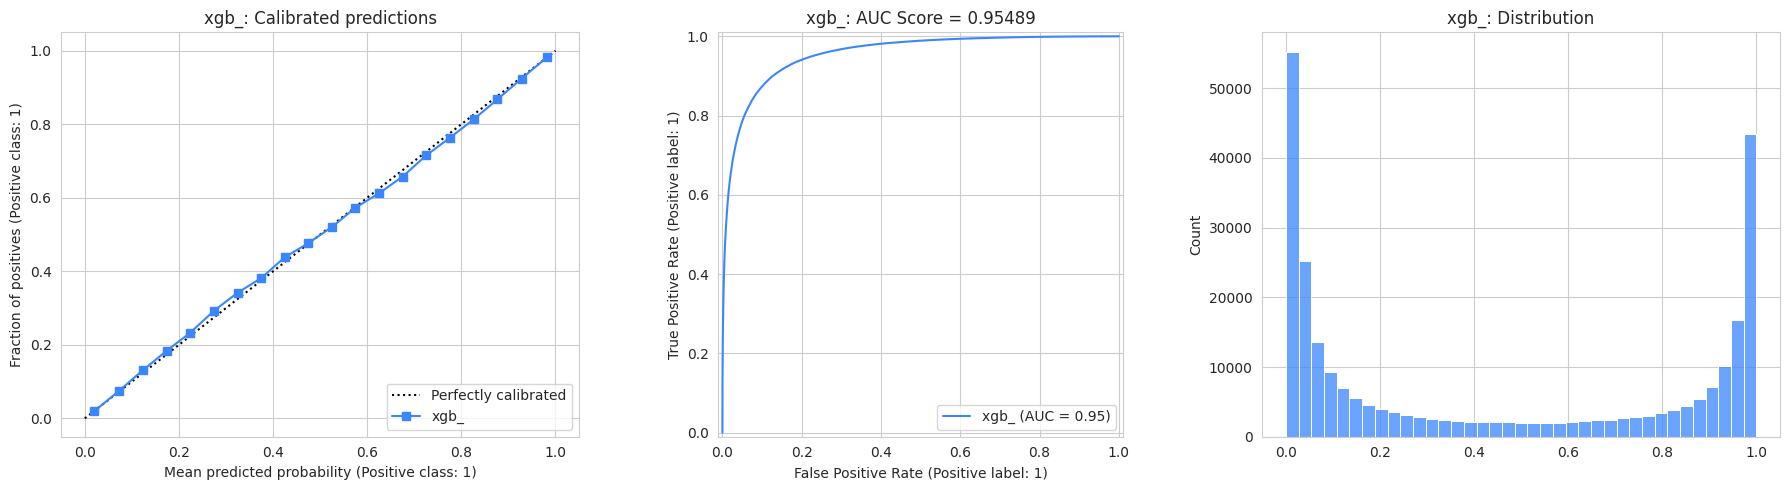


[2]LGB_ █████████████████████████
	FOLD 1/15 |

 AUC: 0.95512
	FOLD 2/15 |

 AUC: 0.95515
	FOLD 3/15 |

 AUC: 0.95507
	FOLD 4/15 |

 AUC: 0.95500
	FOLD 5/15 |

 AUC: 0.95339
	FOLD 6/15 |

 AUC: 0.95408
	FOLD 7/15 |

 AUC: 0.95515
	FOLD 8/15 |

 AUC: 0.95518
	FOLD 9/15 |

 AUC: 0.95464
	FOLD 10/15 |

 AUC: 0.95407
	FOLD 11/15 |

 AUC: 0.95378
	FOLD 12/15 |

 AUC: 0.95538
	FOLD 13/15 |

 AUC: 0.95604
	FOLD 14/15 |

 AUC: 0.95473
	FOLD 15/15 |

 AUC: 0.95502
OOF AUC: 0.95478
AVG AUC: 0.95479 ± 0.00066
Time: 18.24 secs


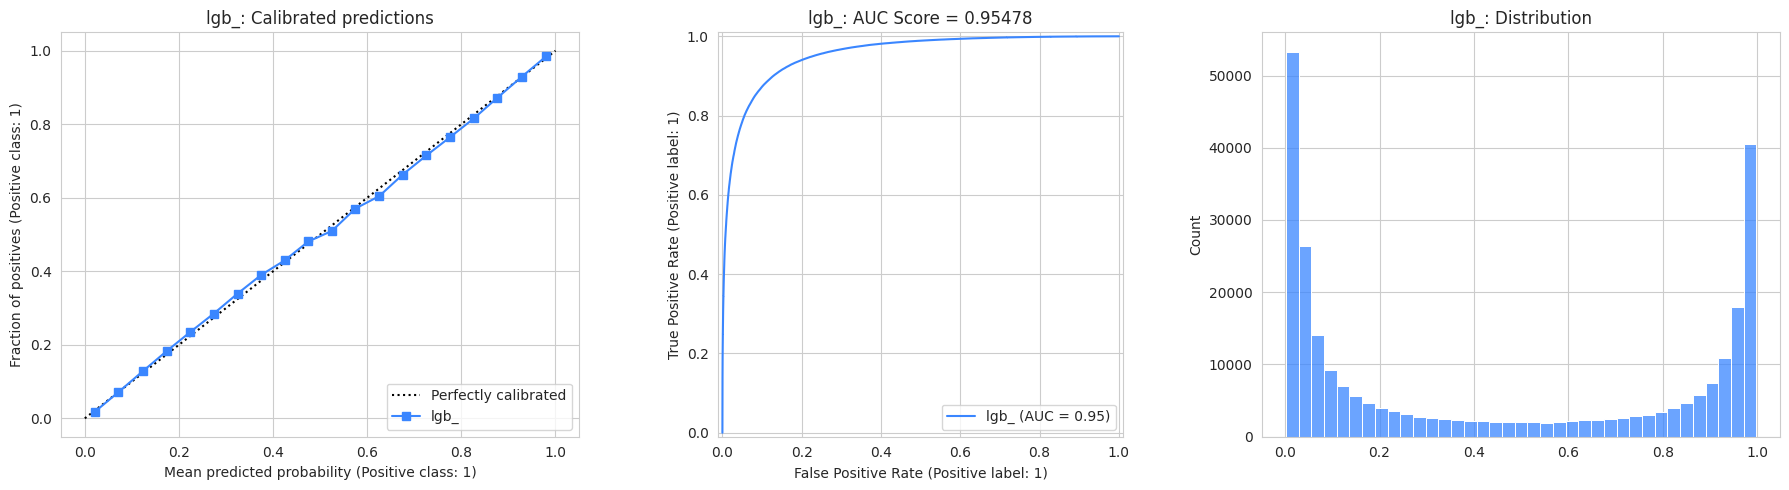


[3]CAT_ █████████████████████████
	FOLD 1/15 |

 AUC: 0.95567
	FOLD 2/15 |

 AUC: 0.95575
	FOLD 3/15 |

 AUC: 0.95565
	FOLD 4/15 |

 AUC: 0.95545
	FOLD 5/15 |

 AUC: 0.95408
	FOLD 6/15 |

 AUC: 0.95456
	FOLD 7/15 |

 AUC: 0.95561
	FOLD 8/15 |

 AUC: 0.95577
	FOLD 9/15 |

 AUC: 0.95513
	FOLD 10/15 |

 AUC: 0.95460
	FOLD 11/15 |

 AUC: 0.95447
	FOLD 12/15 |

 AUC: 0.95593
	FOLD 13/15 |

 AUC: 0.95655
	FOLD 14/15 |

 AUC: 0.95547
	FOLD 15/15 |

 AUC: 0.95565
OOF AUC: 0.95535
AVG AUC: 0.95535 ± 0.00064
Time: 1074.18 secs


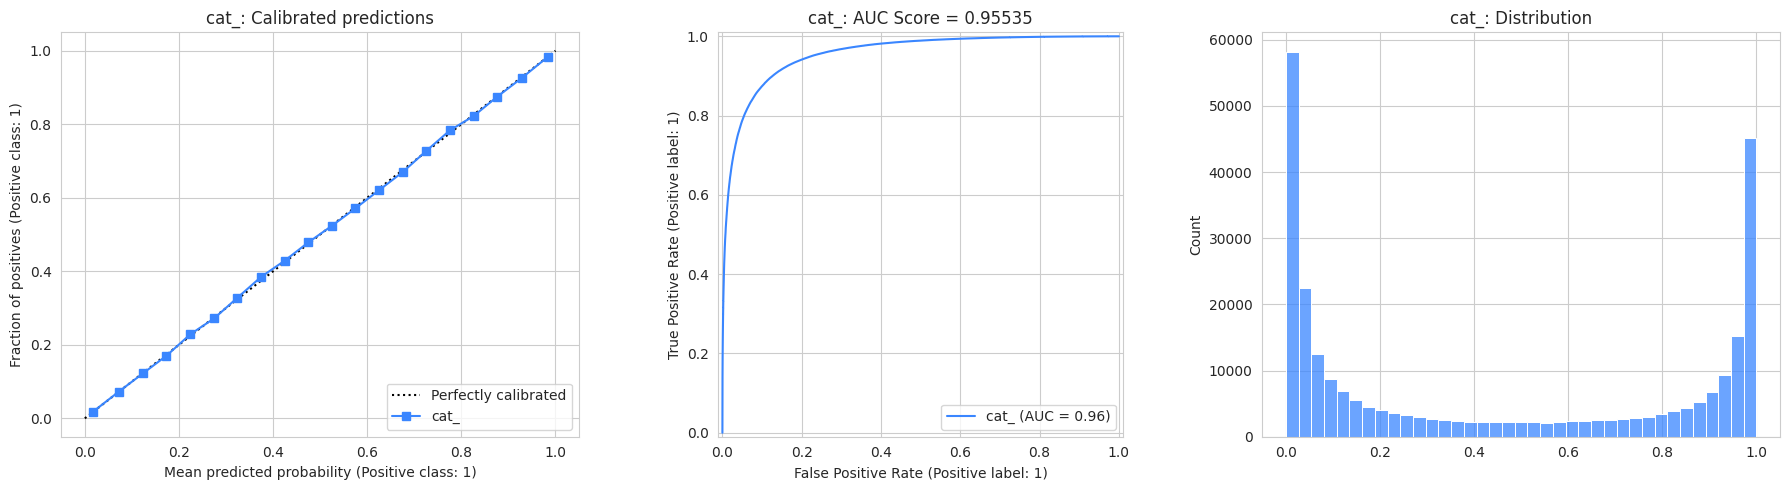


[4]RFC_ █████████████████████████
	FOLD 1/15 |

 AUC: 0.94768


	FOLD 2/15 |

 AUC: 0.94748


	FOLD 3/15 |

 AUC: 0.94787


	FOLD 4/15 |

 AUC: 0.94772


	FOLD 5/15 |

 AUC: 0.94559


	FOLD 6/15 |

 AUC: 0.94630


	FOLD 7/15 |

 AUC: 0.94682


	FOLD 8/15 |

 AUC: 0.94706


	FOLD 9/15 |

 AUC: 0.94657


	FOLD 10/15 |

 AUC: 0.94659


	FOLD 11/15 |

 AUC: 0.94567


	FOLD 12/15 |

 AUC: 0.94725


	FOLD 13/15 |

 AUC: 0.94852


	FOLD 14/15 |

 AUC: 0.94712


	FOLD 15/15 |

 AUC: 0.94724


OOF AUC: 0.94703
AVG AUC: 0.94703 ± 0.00077
Time: 37.72 secs


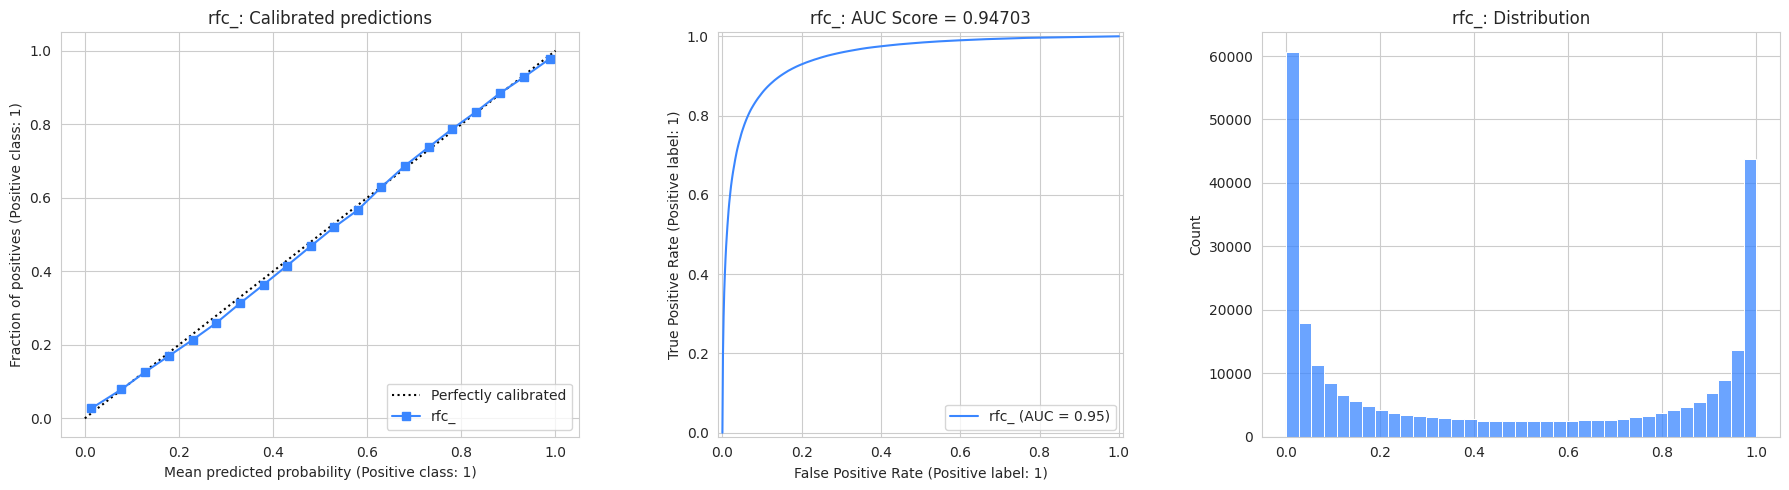


[5]HIST_ █████████████████████████
	FOLD 1/15 |

 AUC: 0.95500


	FOLD 2/15 |

 AUC: 0.95512
	FOLD 3/15 |

 AUC: 0.95504
	FOLD 4/15 |

 AUC: 0.95490


	FOLD 5/15 |

 AUC: 0.95339


	FOLD 6/15 |

 AUC: 0.95412


	FOLD 7/15 |

 AUC: 0.95517


	FOLD 8/15 |

 AUC: 0.95510


	FOLD 9/15 |

 AUC: 0.95461


	FOLD 10/15 |

 AUC: 0.95400


	FOLD 11/15 |

 AUC: 0.95389
	FOLD 12/15 |

 AUC: 0.95530


	FOLD 13/15 |

 AUC: 0.95600


	FOLD 14/15 |

 AUC: 0.95470


	FOLD 15/15 |

 AUC: 0.95497


OOF AUC: 0.95475
AVG AUC: 0.95475 ± 0.00064
Time: 37.96 secs


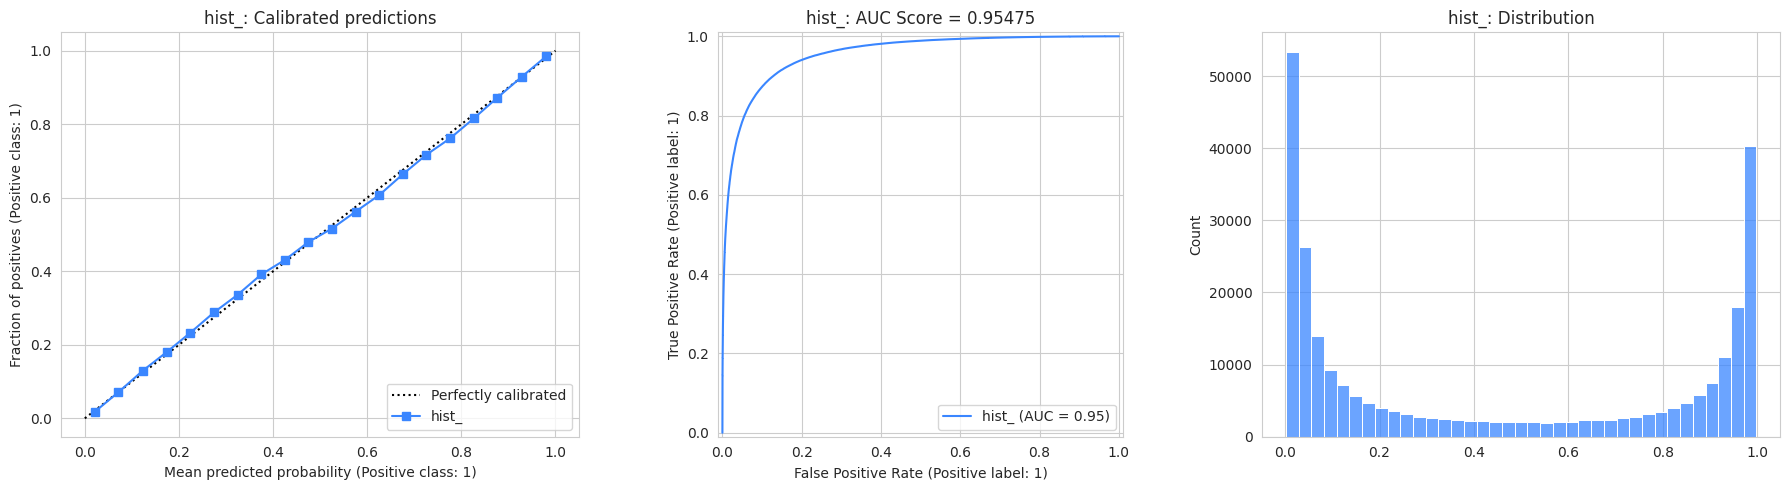

In [44]:
## -- Initiate GBDTs Training -- 
TREE_MODELS = {}

for i, (name, model) in tqdm(
    enumerate(tree_models.items()),
    total=len(tree_models),
    desc='Training Models.'
):
    print(f"\n[{i+1}]{(name.upper())} {'█'*25}")
    tik = time()

    oof_preds  = np.zeros(len(X))
    test_preds = np.zeros(len(test))
    fold_AUCs = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        X_test = test[FEATURES].copy()

        # ## -- OPTION A: Concatenate original data --
        # X_train = pd.concat([X_train, orig[FEATURES]], ignore_index=True)
        # y_train = np.concatenate([y_train, orig[TARGET].values], axis=0)
        
        # ## -- OPTION B: TE Merge original data --
        # X_train, X_val, X_test, NEW_COLS = orig_TE_data_propagate(
        #     orig,
        #     X_train,
        #     X_val,
        #     X_test,
        #     features = BASE,
        #     aggs = ['count'],# 'std']# 'nunique']#'median']#,], 'max'
        #     # fill_nan=True,
        # )

        # ## -- TE Opt1. -> Using CUSTOM --
        # TE = TargetEncoder(NEW_COLS+NUMS, cv=5, smooth='auto', aggs=['mean'], drop_original=False)
        # X_train = TE.fit_transform(X_train, pd.Series(y_train))
        # X_val   = TE.transform(X_val)
        # X_test  = TE.transform(X_test)

        combine = pd.concat([X_train, X_val, X_test])
        for c in CATS:
            combine[c] = combine[c].astype('category')

        X_train = combine.iloc[:len(X_train)]
        X_val   = combine.iloc[len(X_train):len(X_train)+len(X_val)]
        X_test  = combine.iloc[len(X_train)+len(X_val):]

        print(f"\tFOLD {fold+1}/{kf.n_splits} |", end='')

        model.fit(X_train, y_train)
        oof_preds[val_idx] = model.predict_proba(X_val)[:,1]

        fold_auc = roc_auc_score(y_val, oof_preds[val_idx])
        fold_AUCs.append(fold_auc)
        print(f" AUC: {fold_auc:.5f}")

        test_preds += model.predict_proba(X_test)[:,1]

    test_preds /= kf.n_splits
    
    ## -- After all folds --
    overall_AUC = np.round(roc_auc_score(y, oof_preds), 5)
    print(f"{'='*27}")
    print(f"OOF AUC: {overall_AUC}")
    print(f"AVG AUC: {np.mean(fold_AUCs):.5f} ± {np.std(fold_AUCs):.5f}")
    print(f"{'='*27}")
    
    tok = time()
    tiktok = tok-tik
    print(f"Time: {tiktok:.2f} secs")
    
    _, axs = plt.subplots(1, 3, figsize=(18, 5)) #, width_ratios=[0.6,0.4]
    ## -- Right: Confusion matrix (threshold = 0.5)
    pred_labels = (oof_preds >= 0.5).astype('int8')
    # ConfusionMatrixDisplay.from_predictions(y, pred_labels, cmap='Blues', colorbar=False, ax=axs[0])
    # axs[0].set_title(f"{name}: Confusion Matrix")
    # axs[0].grid(False)
    CalibrationDisplay.from_predictions(y, oof_preds, n_bins=20, name=name, ax=axs[0])
    axs[0].set_title(f"{name}: Calibrated predictions")

    ## -- Left: ROC curve
    RocCurveDisplay.from_predictions(y, oof_preds, name=name, ax=axs[1])
    axs[1].set_title(f"{name}: AUC Score = {overall_AUC}")
    ## -- axs[1].grid(False)

    sns.histplot(test_preds, ax=axs[2])
    axs[2].set_title(f"{name}: Distribution")
    
    plt.tight_layout()
    plt.show()
    
    n = name + str(overall_AUC).split('.')[1]
    oof_final[n]    = oof_preds
    test_final[n]   = test_preds
    TREE_MODELS[n]  = model
    model_scores[n] = overall_AUC
    
    gc.collect()

In [45]:
X_train.head(3)

Age Sex Chest pain type   BP  Cholesterol FBS over 120 EKG results  Max HR  \
0   58   1               4  152          239            0           0     158   
1   52   1               1  125          325            0           2     171   
2   56   0               2  160          188            0           2     151   

  Exercise angina  ST depression Slope of ST Number of vessels fluro Thallium  
0               1            3.6           2                       2        7  
1               0            0.0           1                       0        3  
2               0            0.0           1                       0        3

In [46]:
X_train.isna().sum().to_frame().T

Age  Sex  Chest pain type  BP  Cholesterol  FBS over 120  EKG results  \
0    0    0                0   0            0             0            0   

   Max HR  Exercise angina  ST depression  Slope of ST  \
0       0                0              0            0   

   Number of vessels fluro  Thallium  
0                        0         0

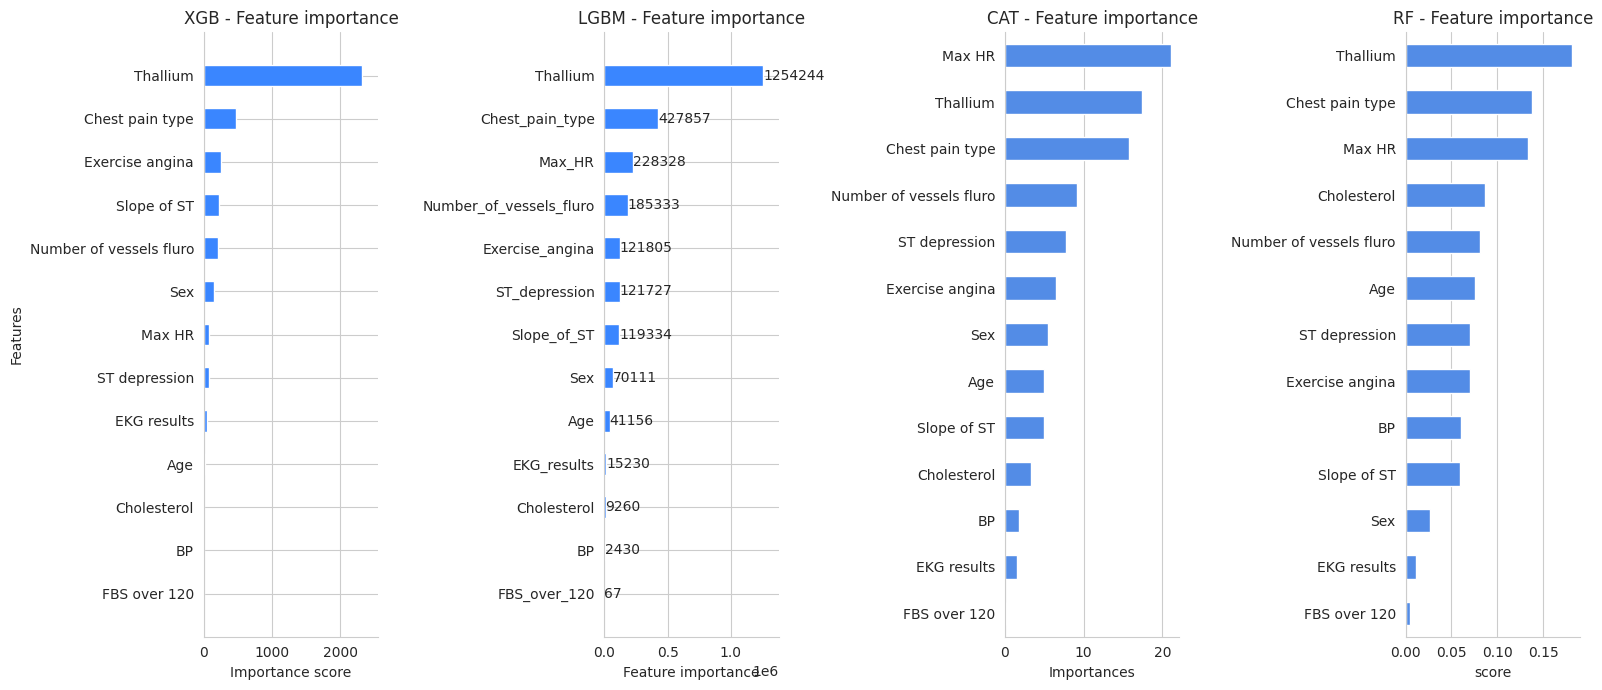

In [47]:
## -- Plot Feature Importances -- 
MAX = 15
fig, axs = plt.subplots(1, 4, figsize=(16, 7))

## -- XGBoost --
for k, v in TREE_MODELS.items():
    if 'xgb' in k:
        xgb.plot_importance(
            v, max_num_features=MAX,
            importance_type='gain',
            title='XGB - Feature importance',
            height=0.5, show_values=False, ax=axs[0], # grid=False,
        )

    ## -- LightGBM -- 
    elif 'lgb' in k:
        lgb.plot_importance(
            v, max_num_features=MAX,
            importance_type='gain',
            title='LGBM - Feature importance',
            height=0.5, precision=0, ax=axs[1], # grid=False,
        )
        axs[1].set_ylabel('')
    
    ## -- CatBoost -- 
    elif 'cat' in k:
        cat_imp_df = v.get_feature_importance(prettified=True).iloc[:MAX]
        sns.barplot(data=cat_imp_df, x='Importances', y='Feature Id', width=0.5, ax=axs[2])
        axs[2].set_title('CAT - Feature importance')
        axs[2].set_ylabel('')
    
    ## -- RandomForest -- 
    elif 'rfc' in k:
        rf_dicts = dict(zip(X_train.columns, v.feature_importances_))
        rf_imp_df = pd.DataFrame.from_dict(rf_dicts, orient='index', columns=['score'])\
                                .sort_values('score', ascending=False).iloc[:MAX]
        sns.barplot(rf_imp_df, x=rf_imp_df.score, y=rf_imp_df.index, width=0.5, ax=axs[3])
        axs[3].set_title('RF - Feature importance')
        axs[3].set_ylabel('')
    
    for ax in axs:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
plt.tight_layout()
plt.show()

In [48]:
!pip install -q -U shap
import shap


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


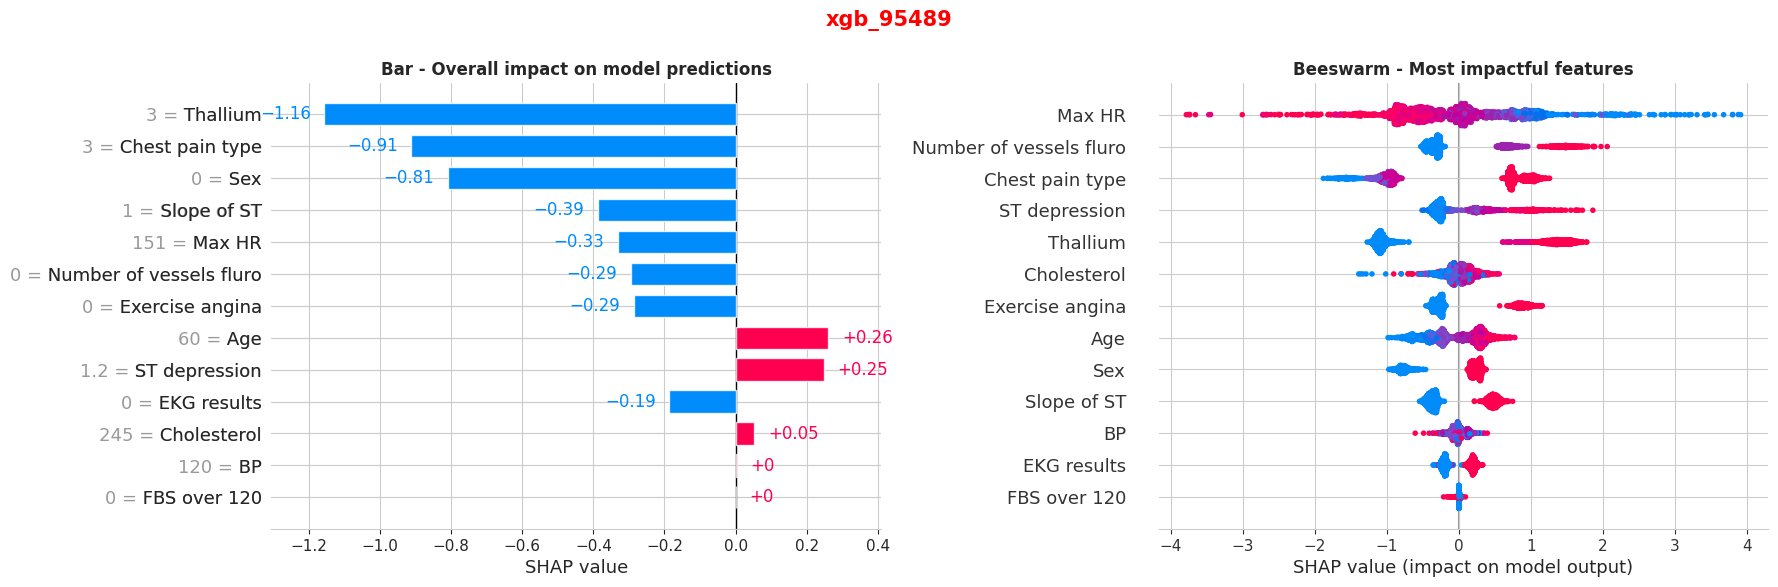

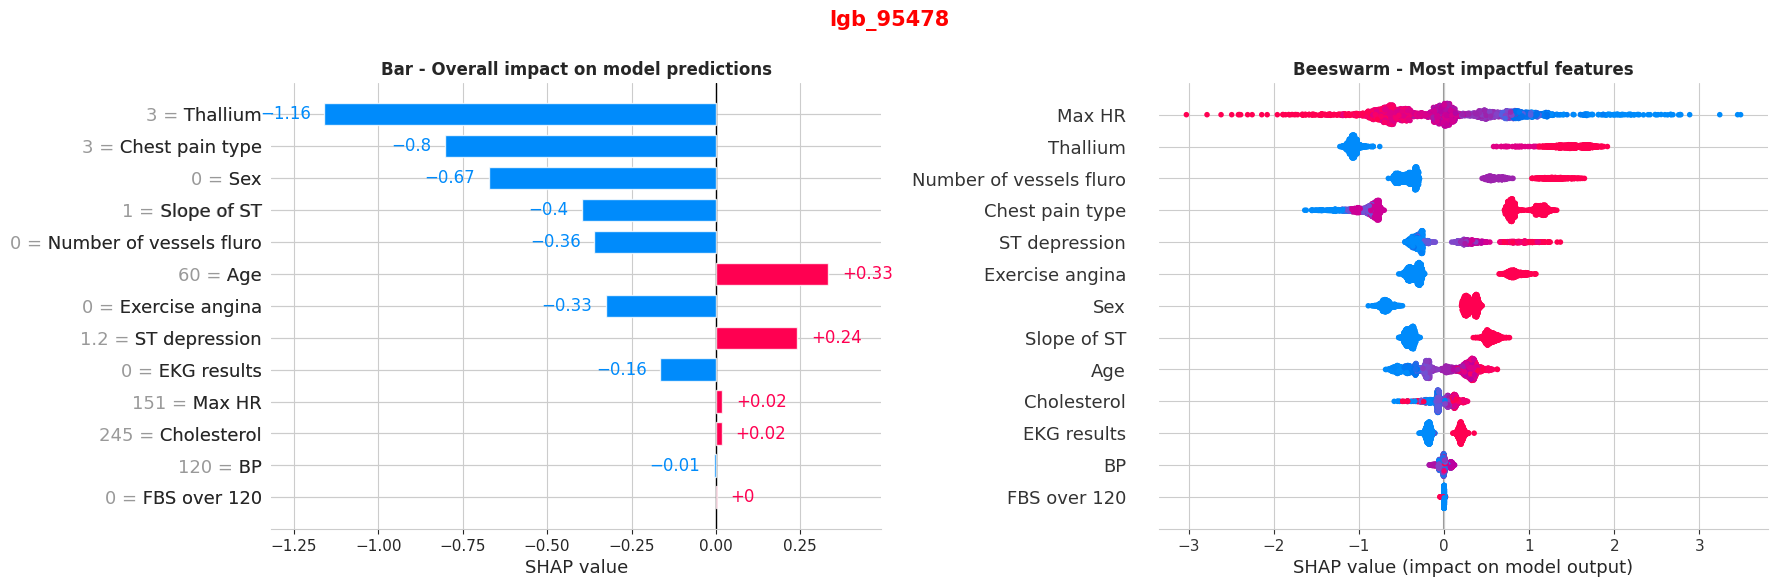

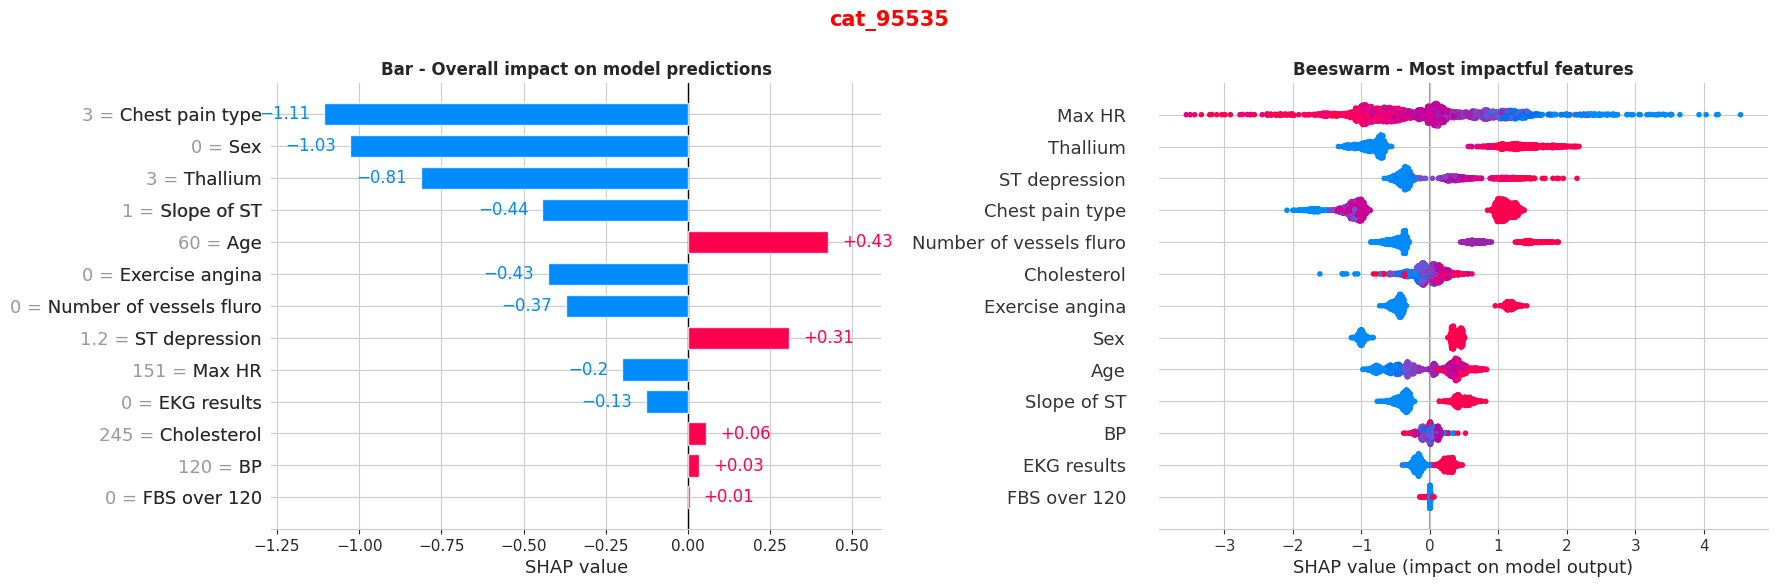

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [49]:
## -- Plot SHAP values --
MAX = 15

for i, (name, model) in enumerate(TREE_MODELS.items()):
    if 'xgb' in name or 'lgb' in name or 'cat' in name:
        explainer = shap.TreeExplainer(model)
        explanation = explainer(X_val.iloc[:2000])

        ## -- Bar plot --
        plt.subplot(121)
        shap.plots.bar(explanation[0], max_display=MAX, show=False)
        plt.title('Bar - Overall impact on model predictions', fontweight='semibold')

        ## -- Beeswarm plot --
        plt.subplot(122)
        shap.plots.beeswarm(
            explanation, max_display=MAX, order=explanation.abs.max(0),
            plot_size=(18, 6), color_bar=False, show=False,
        )

        plt.title('Beeswarm - Most impactful features', fontweight='semibold')
        plt.suptitle(f"{name}", fontweight='bold', fontsize=15, color='r')
        
    plt.tight_layout(pad=1.5) 
    plt.show() 
    print()

In [50]:
# ## -- SHAP VALUES / PLOTS -- 
# MAX = 15
# def get_shap_plots(model_name: str, model_instance, X, y, tree_model=False):
#     print(f"\n Training {model_name} {'»'*5}... ", end='')
#     tik = time()

#     X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=SEED)

#     # ## -- Concatenate original data --
#     # X_train = pd.concat([X_train, orig[FEATURES]], ignore_index=True)
#     # y_train = np.concatenate([y_train, orig[TARGET].values], axis=0)

#     if 'xgb' in model_name:
#         model_instance.set_params(**dict(enable_categorical= False))

#     model_instance.fit(X_train, y_train)
#     print(f"{COLOR}✓ Complete!{RESET}")

#     if tree_model:
#         explainer = shap.TreeExplainer(model_instance)

#     explainer = shap.TreeExplainer(model_instance)
#     explanation = explainer(X_val.iloc[:2000])

#     ## -- Bar plot --
#     plt.subplot(121)
#     shap.plots.bar(explanation[0], max_display=MAX, show=False)
#     plt.title('Bar - Overall impact on model predictions', fontweight='semibold')

#     ## -- Beeswarm plot --
#     plt.subplot(122)
#     shap.plots.beeswarm(
#         explanation, max_display=MAX, order=explanation.abs.max(0),
#         plot_size=(18, 6), color_bar=False, show=False,
#     )

#     plt.title('Beeswarm - Most impactful features', fontweight='semibold')
#     plt.suptitle(f"{model_name}", fontweight='bold', fontsize=15, color='r')
#     plt.tight_layout(pad=1.5) 
#     plt.show() 
#     print()
    
#     tok = time()
#     tiktok = tok-tik
#     print(f"Time: {tiktok:.2f} secs")

# for name, model in tqdm(tree_models.items(), total=len(tree_models)):
#     get_shap_plots(name[:3], model, train[BASE], train[TARGET], tree_model=True)

In [51]:
display(oof_final.head(3))
print()
display(test_final.head(3))

xgb_95489  lgb_95478  cat_95535  rfc_94703  hist_95475
0   0.997946   0.993845   0.997511        1.0    0.993759
1   0.013199   0.015091   0.009971        0.0    0.015873
2   0.010473   0.016439   0.008023        0.0    0.014615

xgb_95489  lgb_95478  cat_95535  rfc_94703  hist_95475
0   0.967923   0.936225   0.957620   0.846667    0.938938
1   0.009701   0.009110   0.007061   0.000667    0.009044
2   0.987516   0.981949   0.990093   0.997333    0.982425

## ~ LINEAR MODELS

In [52]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV

### ~ LINEAR MODELS 1: OHE ONLY CATS

In [53]:
## -- Define Models --
linear_models = {
    'log_': LogisticRegressionCV(
        max_iter=1000,
        tol=1e-5, 
        cv=N_SPLITS,
        scoring='neg_log_loss',
        # class_weight='balanced',
        n_jobs=os.cpu_count(),
        random_state=SEED,
    ),
    'mlp_': MLPClassifier(
        max_iter=1000,
        tol=1e-5,
        random_state=SEED,
    ),
}

print(f"Linear Models to train: {len(linear_models)} -> ", end="")
print(list(linear_models.keys()))

Linear Models to train: 2 -> ['log_', 'mlp_']


Training Models.:   0%|          | 0/2 [00:00<?, ?it/s]


[1] log_ ████████████████████


	FOLD 1/15 AUC: 0.95318


	FOLD 2/15 AUC: 0.95347


	FOLD 3/15 AUC: 0.95306


	FOLD 4/15 AUC: 0.95328


	FOLD 5/15 AUC: 0.95151


	FOLD 6/15 AUC: 0.95203


	FOLD 7/15 AUC: 0.95331


	FOLD 8/15 AUC: 0.95312


	FOLD 9/15 AUC: 0.95255


	FOLD 10/15 AUC: 0.95210


	FOLD 11/15 AUC: 0.95216


	FOLD 12/15 AUC: 0.95352


	FOLD 13/15 AUC: 0.95413


	FOLD 14/15 AUC: 0.95280


	FOLD 15/15 AUC: 0.95305


------------------------------
OOF AUC: 0.95288
AVG AUC: 0.95288 ± 0.00067
------------------------------
Best 'C': [0.35938137]
Time: 147.16 secs


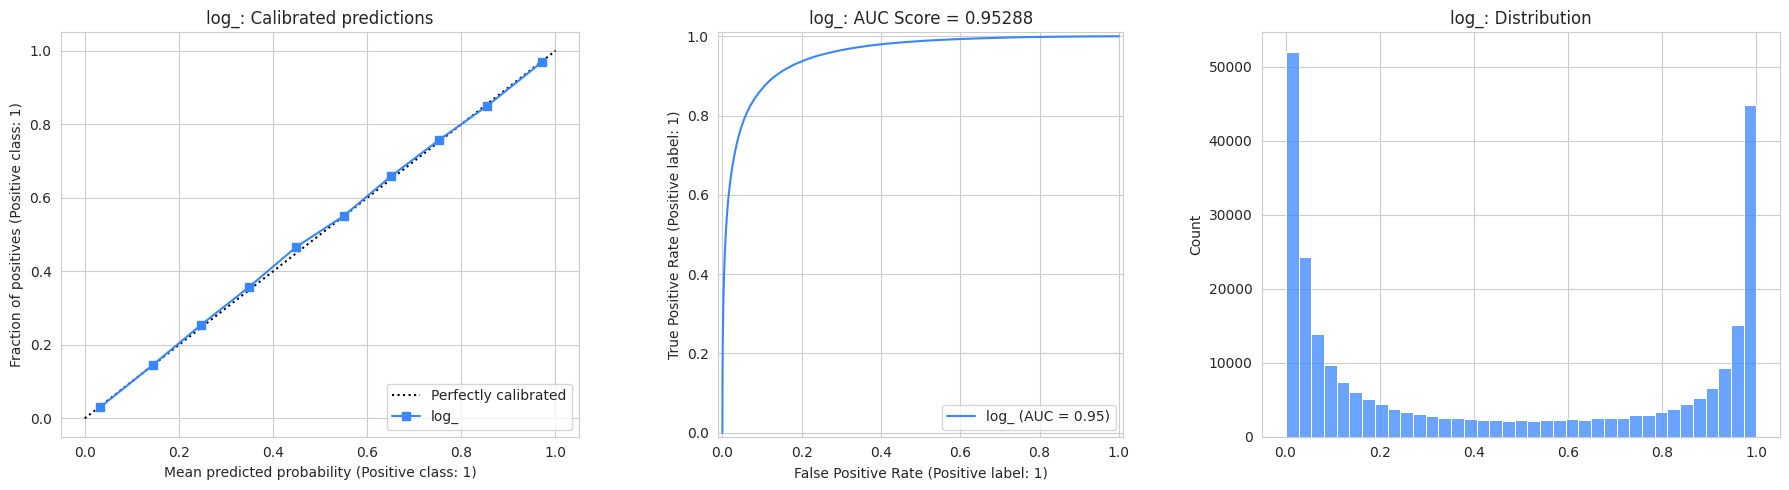


[2] mlp_ ████████████████████


	FOLD 1/15 AUC: 0.95341


	FOLD 2/15 AUC: 0.95349


	FOLD 3/15 AUC: 0.95353


	FOLD 4/15 AUC: 0.95366


	FOLD 5/15 AUC: 0.95166


	FOLD 6/15 AUC: 0.95254


	FOLD 7/15 AUC: 0.95353


	FOLD 8/15 AUC: 0.95353


	FOLD 9/15 AUC: 0.95292


	FOLD 10/15 AUC: 0.95204


	FOLD 11/15 AUC: 0.95232


	FOLD 12/15 AUC: 0.95385


	FOLD 13/15 AUC: 0.95417


	FOLD 14/15 AUC: 0.95332


	FOLD 15/15 AUC: 0.95329


------------------------------
OOF AUC: 0.95308
AVG AUC: 0.95315 ± 0.00069
------------------------------
Time: 2058.63 secs


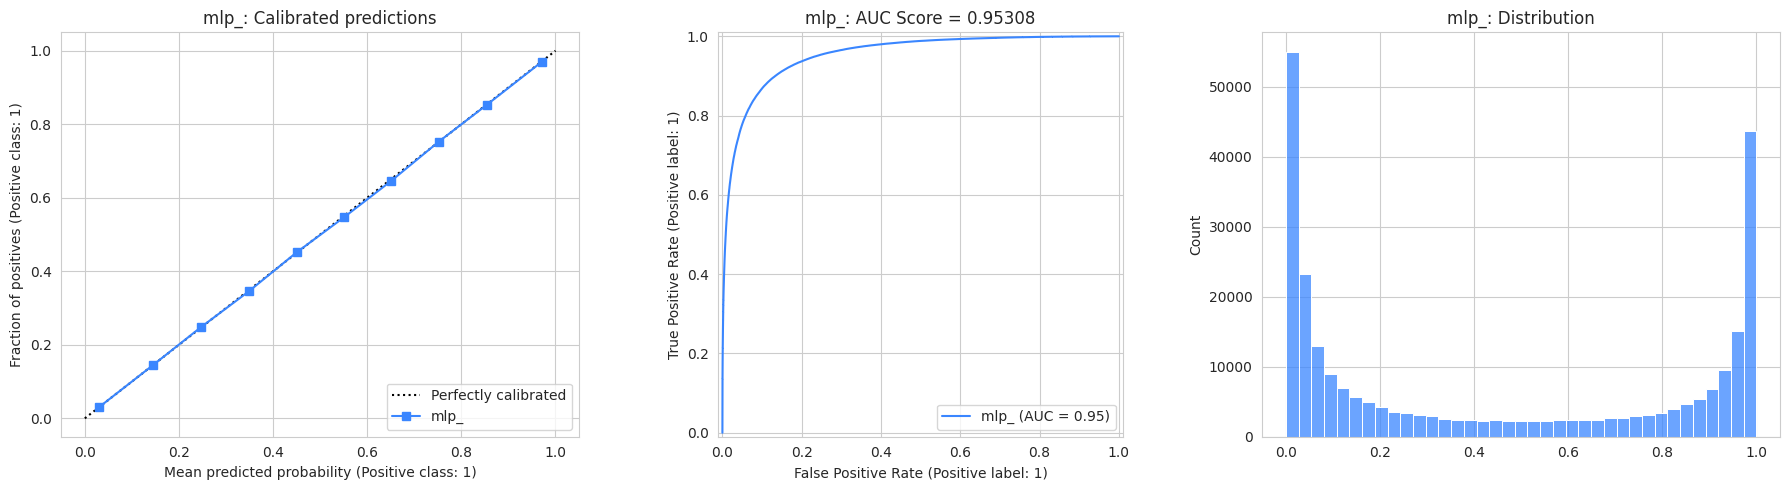

In [54]:
## -- Initiate LINEAR Training 1 -- 
LINEAR_MODELS_1 = {}

for i, (name, model) in tqdm(
    enumerate(linear_models.items()),
    total=len(linear_models),
    desc='Training Models.'
):
    print(f"\n[{i+1}] {name} {'█'*20}")
    tik = time()

    oof_preds  = np.zeros(len(X))
    test_preds = np.zeros(len(test))
    fold_AUCs  = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        X_test = test[FEATURES].copy()

        ## -- Create pipeline --
        lr_model = make_pipeline(
            make_column_transformer(
                (OneHotEncoder(
                    handle_unknown='ignore',
                    # sparse_output=False,
                    drop='first',
                ), CATS),
                remainder='passthrough',
                n_jobs=os.cpu_count(),
            ),
            StandardScaler(),
            model,
        )

        lr_model.fit(X_train, y_train)
        
        oof_preds[val_idx] = lr_model.predict_proba(X_val)[:,1]
        
        fold_auc = roc_auc_score(y_val, oof_preds[val_idx])
        fold_AUCs.append(fold_auc)
        print(f"\tFOLD {fold+1}/{kf.n_splits} AUC: {fold_auc:.5f}")

        test_preds += lr_model.predict_proba(X_test)[:,1]

    test_preds /= kf.n_splits
    
    tok = time()
    tiktok = tok-tik
    
    ## -- After all folds --
    overall_AUC = np.round(roc_auc_score(y, oof_preds), 5)
    
    print(f"{'-'*30}")
    print(f"OOF AUC: {overall_AUC}")
    print(f"AVG AUC: {np.mean(fold_AUCs):.5f} ± {np.std(fold_AUCs):.5f}")
    print(f"{'-'*30}")
    if 'log' in name:
        print(f"Best 'C': {lr_model[-1].C_}")
    print(f"Time: {tiktok:.2f} secs")
    
    _, axs = plt.subplots(1, 3, figsize=(18, 5)) #, width_ratios=[0.6,0.4]
    # Right: Confusion matrix (threshold = 0.5)
    pred_labels = (oof_preds >= 0.5).astype('int8')
    # ConfusionMatrixDisplay.from_predictions(y, pred_labels, cmap='Blues', colorbar=False, ax=axs[0])
    # axs[0].set_title(f"{name}: Confusion Matrix")
    # axs[0].grid(False)
    CalibrationDisplay.from_predictions(y, oof_preds, n_bins=10, name=name, ax=axs[0])
    axs[0].set_title(f"{name}: Calibrated predictions")
    
    # Left: ROC curve
    RocCurveDisplay.from_predictions(y, oof_preds, name=name, ax=axs[1])
    axs[1].set_title(f"{name}: AUC Score = {overall_AUC}")
    # axs[1].grid(False)

    sns.histplot(test_preds, ax=axs[2])
    axs[2].set_title(f"{name}: Distribution")
    
    plt.tight_layout()
    plt.show()

    n = name + str(overall_AUC).split('.')[1]
    oof_final[n]       = oof_preds
    test_final[n]      = test_preds
    LINEAR_MODELS_1[n] = lr_model
    model_scores[n]    = overall_AUC
    
    gc.collect()

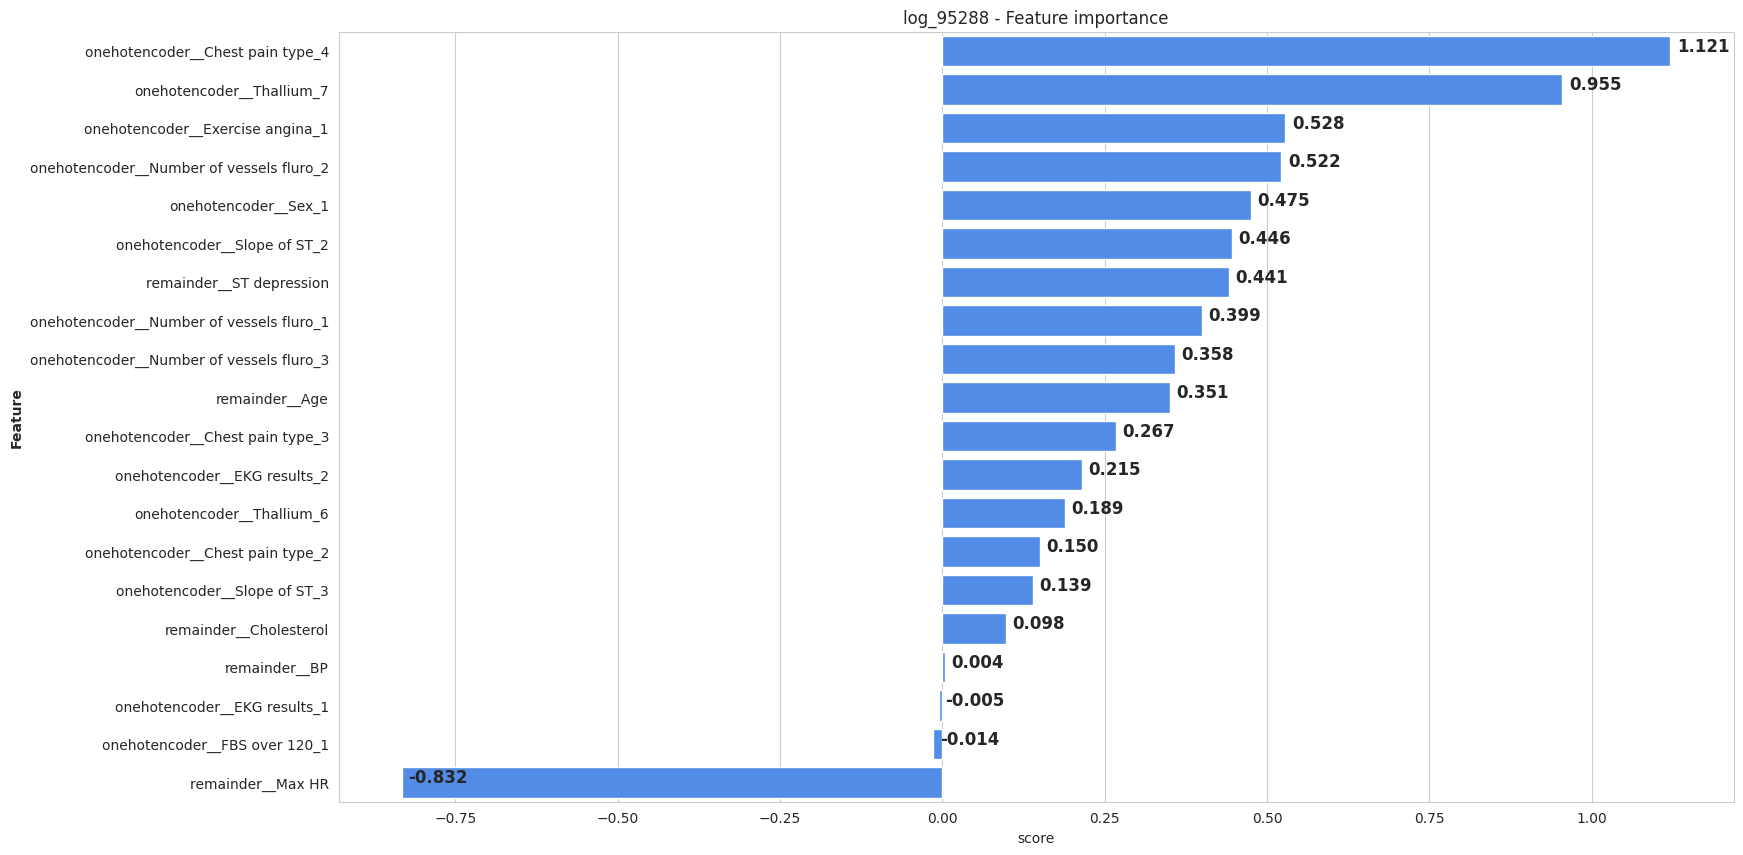

In [55]:
## -- Feature Importances: Linear Model --
for i, name in enumerate(list(LINEAR_MODELS_1.keys())):
    if 'log' in name:
        coef_dict = dict(
            zip(
                LINEAR_MODELS_1[name][0].get_feature_names_out(),
                LINEAR_MODELS_1[name][-1].coef_[0]
            )
        )
        # print(coef_dict)

        reg_imp = pd.DataFrame.from_dict(
            coef_dict,
            orient='index',
            columns=['score']
        ).sort_values('score', ascending=False).iloc[:20] # -> Top 10 features
        
        reg_imp.columns = ['score']
        
        plt.figure(figsize=(18, 10))
        sns.barplot(data=reg_imp, x='score', y=reg_imp.index)
        plt.ylabel('Feature', fontweight='semibold')
        plt.title(f'{name} - Feature importance')
        
        for i, t in enumerate(reg_imp['score'].values):
            plt.text(t+1e-2, i, f'{t:.3f}', fontdict={'size': 12, 'weight': 'bold'})
        
        # plt.tight_layout()
        plt.show()

### ~ LINEAR MODELS 2: OHE ALL FEATURES

In [56]:
## -- Define Models --
linear_models2 = {
    'log2v_': LogisticRegressionCV(
        max_iter=1000,
        tol=1e-5,
        cv=N_SPLITS,
        scoring='neg_log_loss',
        # class_weight='balanced',
        n_jobs=os.cpu_count(),
        random_state=SEED,
    ),
    # 'mlp2v_': MLPClassifier(
    #     max_iter=1000,
    #     tol=1e-5,
    #     random_state=SEED,
    # ),
}

print(f"Linear Models to train: {len(linear_models2)} -> ", end="")
print(list(linear_models2.keys()))

Linear Models to train: 1 -> ['log2v_']


Training Models.:   0%|          | 0/1 [00:00<?, ?it/s]


[1] log2v_ █████████████████████████


Fold 1/15 AUC: 0.95599


Fold 2/15 AUC: 0.95612


Fold 3/15 AUC: 0.95573


Fold 4/15 AUC: 0.95541


Fold 5/15 AUC: 0.95415


Fold 6/15 AUC: 0.95449


Fold 7/15 AUC: 0.95577


Fold 8/15 AUC: 0.95594


Fold 9/15 AUC: 0.95516


Fold 10/15 AUC: 0.95493


Fold 11/15 AUC: 0.95473


Fold 12/15 AUC: 0.95603


Fold 13/15 AUC: 0.95683


Fold 14/15 AUC: 0.95555


Fold 15/15 AUC: 0.95581


------------------------------
OOF AUC: 0.95551
AVG AUC: 0.95551 ± 0.00068
------------------------------
Best 'C' value: [0.00599484]
Time: 270.56 secs


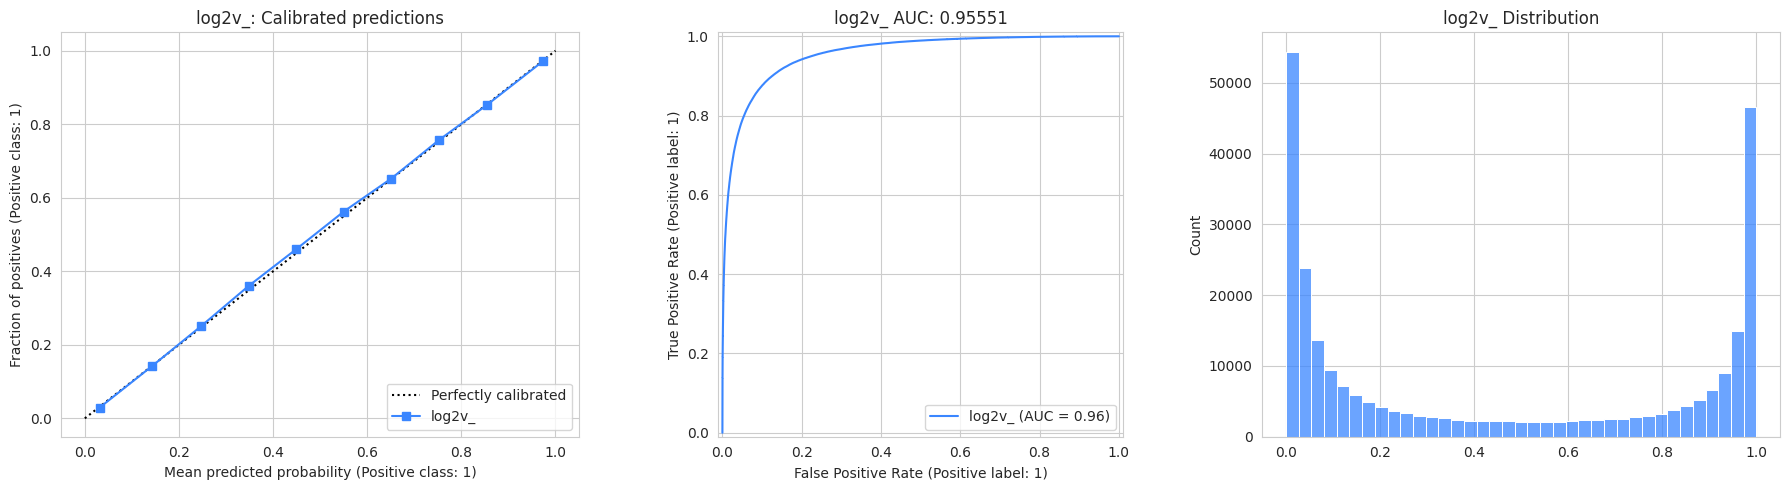

In [57]:
## -- Initiate LINEAR Training 2 -- 
LINEAR_MODELS_2 = {}

for i, (name, model) in tqdm(
    enumerate(linear_models2.items()),
    total=len(linear_models2),
    desc='Training Models.'
):
    print(f"\n[{i+1}] {name} {'█'*25}")
    tik = time()

    oof_preds  = np.zeros(len(X))
    test_preds = np.zeros(len(test))
    fold_AUCs  = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        X_test = test[FEATURES].copy()

        ## -- Create pipeline --
        lr_model_2 = make_pipeline(
            make_column_transformer(
                (OneHotEncoder(
                    handle_unknown='ignore',
                    # sparse_output=False,
                    drop='first',
                ), FEATURES),
                remainder='passthrough',
                n_jobs=os.cpu_count(),
            ),
            StandardScaler(with_mean=False),
            model,
        )

        lr_model_2.fit(X_train, y_train)
        
        oof_preds[val_idx] = lr_model_2.predict_proba(X_val)[:,1]
        
        fold_auc = roc_auc_score(y_val, oof_preds[val_idx])
        fold_AUCs.append(fold_auc)
        print(f"Fold {fold+1}/{kf.n_splits} AUC: {fold_auc:.5f}")

        test_preds += lr_model_2.predict_proba(X_test)[:,1]

    test_preds /= kf.n_splits
    
    tok = time()
    tiktok = tok-tik
    
    ## -- After all folds --
    overall_AUC = np.round(roc_auc_score(y, oof_preds), 5)
    
    print(f"{'-'*30}")
    print(f"OOF AUC: {overall_AUC}")
    print(f"AVG AUC: {np.mean(fold_AUCs):.5f} ± {np.std(fold_AUCs):.5f}")
    print(f"{'-'*30}")
    print(f"Best 'C' value: {lr_model_2[-1].C_}")
    print(f"Time: {tiktok:.2f} secs")
    
    _, axs = plt.subplots(1, 3, figsize=(18, 5))
    # Right: Confusion matrix (threshold = 0.5)
    pred_labels = (oof_preds >= 0.5).astype('int8')
    # ConfusionMatrixDisplay.from_predictions(y, pred_labels, cmap='Blues', colorbar=False, ax=axs[0])
    # axs[0].set_title(f"{name} Confusion Matrix")
    # axs[0].grid(False)
    CalibrationDisplay.from_predictions(y, oof_preds, n_bins=10, name=name, ax=axs[0])
    axs[0].set_title(f"{name}: Calibrated predictions")
    
    # Left: ROC curve
    RocCurveDisplay.from_predictions(y, oof_preds, name=name, ax=axs[1])
    axs[1].set_title(f"{name} AUC: {overall_AUC}")
    # axs[1].grid(False)

    sns.histplot(test_preds, ax=axs[2])
    axs[2].set_title(f"{name} Distribution")
    
    plt.tight_layout()
    plt.show()

    n = name + str(overall_AUC).split('.')[1]
    oof_final[n]       = oof_preds
    test_final[n]      = test_preds
    LINEAR_MODELS_2[n] = lr_model_2
    model_scores[n]    = overall_AUC
    
    gc.collect()

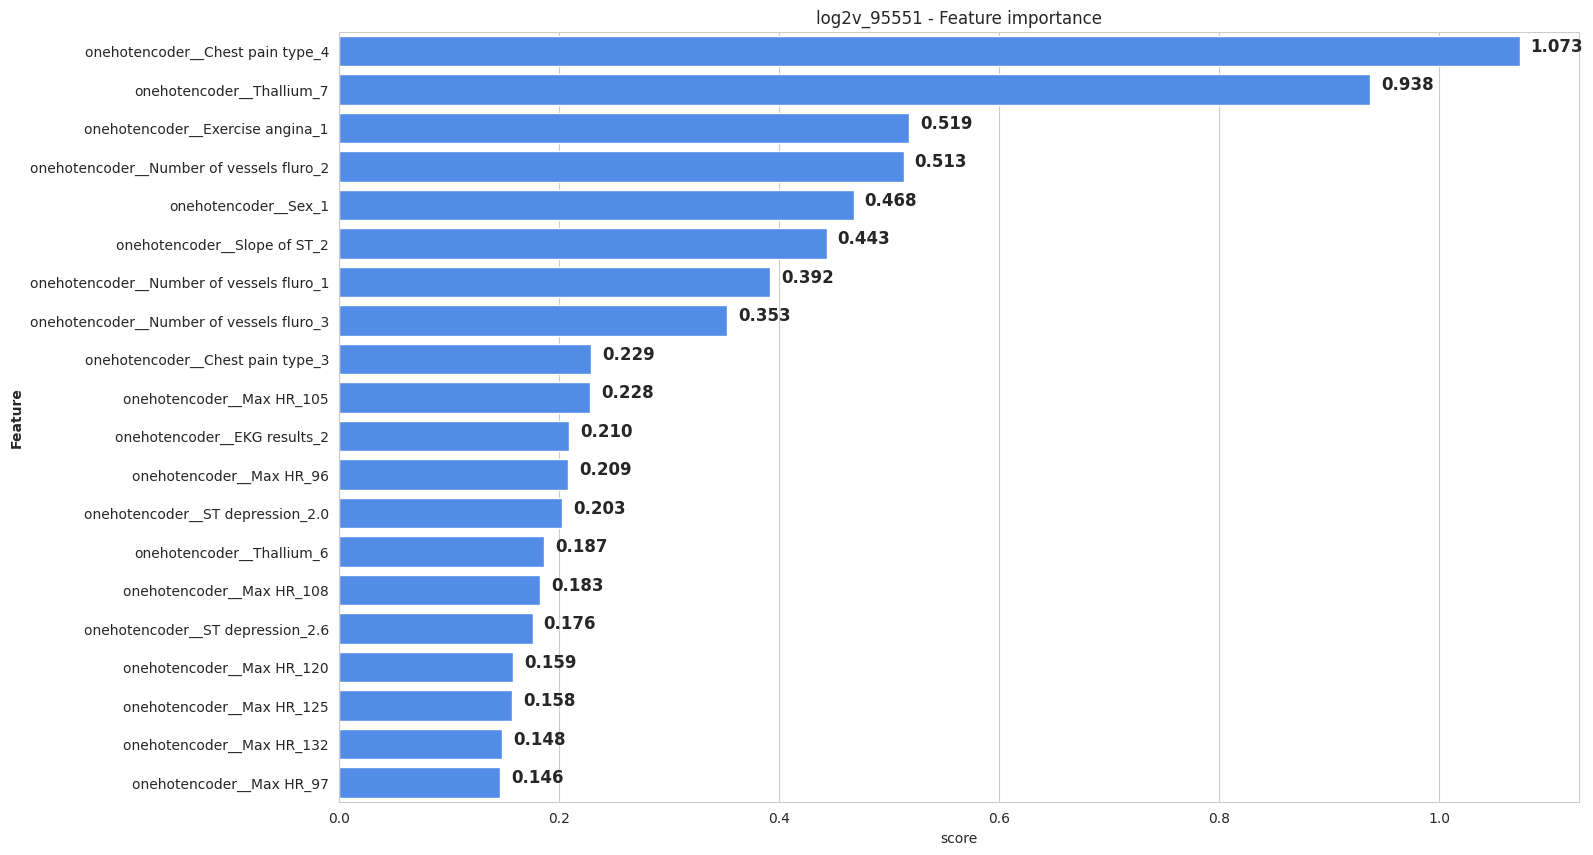

In [58]:
## -- Feature Importances: Linear Model --
for i, name in enumerate(list(LINEAR_MODELS_2.keys())):
    if 'log' in name:
        coef_dict = dict(
            zip(
                LINEAR_MODELS_2[name][0].get_feature_names_out(),
                LINEAR_MODELS_2[name][-1].coef_[0]
            )
        )
        # print(coef_dict)
        reg_imp = pd.DataFrame.from_dict(
            coef_dict,
            orient='index',
            columns=['score']
        ).sort_values('score', ascending=False).iloc[:20] # -> Display top features
        reg_imp.columns = ['score']
        
        plt.figure(figsize=(16, 10))
        sns.barplot(data=reg_imp, x='score', y=reg_imp.index)
        plt.ylabel('Feature', fontweight='semibold')
        plt.title(f'{name} - Feature importance')
        
        for i, t in enumerate(reg_imp['score'].values):
            plt.text(t+1e-2, i, f'{t:.3f}', fontdict={'size': 12, 'weight': 'bold'})
        
        # plt.tight_layout()
        plt.show()

In [59]:
## -- Define Models --
linear_models3 = {
    'log3_': LogisticRegressionCV(
        max_iter=1000,
        tol=1e-5,
        cv=N_SPLITS,
        scoring='neg_log_loss',
        # class_weight='balanced',
        n_jobs=os.cpu_count(),
        random_state=SEED,
    ),
}

print(f"Linear Models to train: {len(linear_models3)} -> ", end="")
print(list(linear_models3.keys()))

Linear Models to train: 1 -> ['log3_']


Training Models.:   0%|          | 0/1 [00:00<?, ?it/s]


[1] log3_ █████████████████████████


Fold 1/15 AUC: 0.95601


Fold 2/15 AUC: 0.95614


Fold 3/15 AUC: 0.95575


Fold 4/15 AUC: 0.95545


Fold 5/15 AUC: 0.95416


Fold 6/15 AUC: 0.95449


Fold 7/15 AUC: 0.95578


Fold 8/15 AUC: 0.95596


Fold 9/15 AUC: 0.95518


Fold 10/15 AUC: 0.95495


Fold 11/15 AUC: 0.95478


Fold 12/15 AUC: 0.95604


Fold 13/15 AUC: 0.95683


Fold 14/15 AUC: 0.95556


Fold 15/15 AUC: 0.95580


------------------------------
OOF AUC: 0.95552
AVG AUC: 0.95552 ± 0.00068
------------------------------
Best 'C': [0.00599484]
Time: 108.58 secs


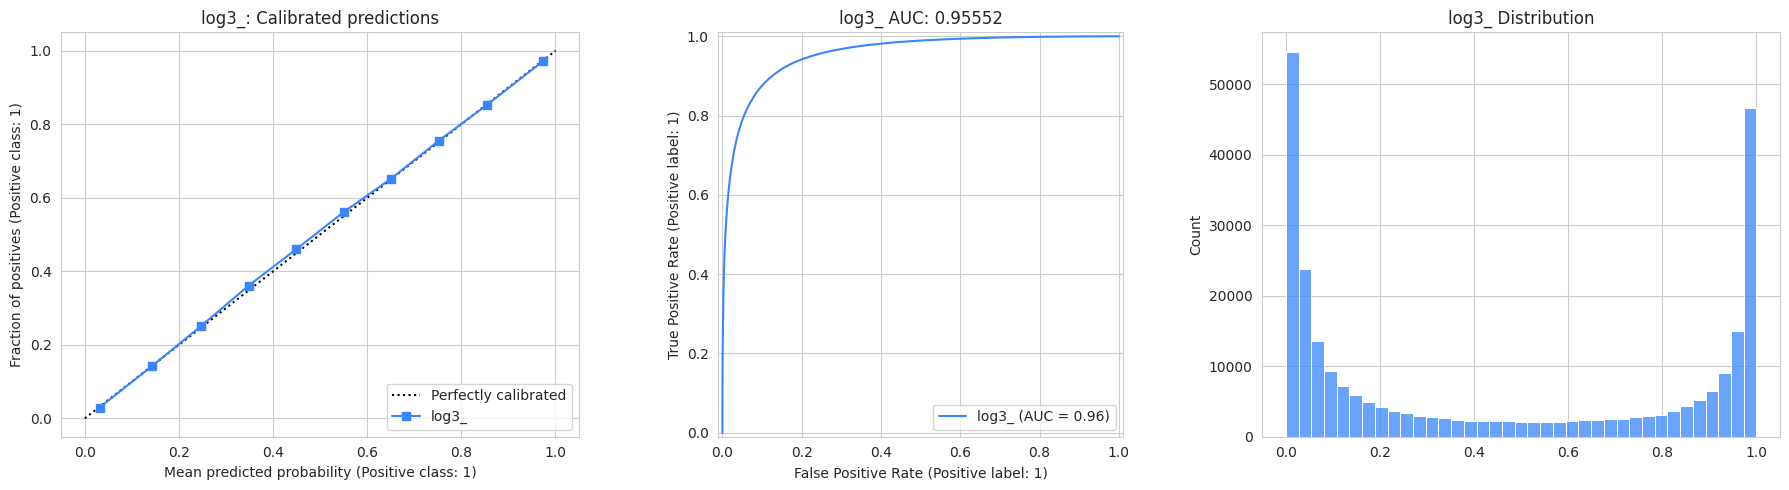

In [60]:
## -- Initiate LINEAR Training 2 -- 
LINEAR_MODELS_3 = {}

for i, (name, model) in tqdm(
    enumerate(linear_models3.items()),
    total=len(linear_models3),
    desc='Training Models.'
):
    print(f"\n[{i+1}] {name} {'█'*25}")
    tik = time()

    oof_preds  = np.zeros(len(X))
    test_preds = np.zeros(len(test))
    fold_AUCs = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        X_test = test[FEATURES].copy()

        ## -- Create pipeline --
        lr_model_3 = make_pipeline(
            make_column_transformer(
                (OneHotEncoder(
                    handle_unknown='ignore',
                    # sparse_output=False,
                    # drop='first',
                ), FEATURES),
                remainder='passthrough',
                n_jobs=os.cpu_count(),
            ),
            StandardScaler(with_mean=False),
            model,
        )

        lr_model_3.fit(X_train, y_train)
        
        oof_preds[val_idx] = lr_model_3.predict_proba(X_val)[:,1]
        fold_auc = roc_auc_score(y_val, oof_preds[val_idx])
        fold_AUCs.append(fold_auc)
        print(f"Fold {fold+1}/{kf.n_splits} AUC: {fold_auc:.5f}")

        test_preds += lr_model_3.predict_proba(X_test)[:,1]

    test_preds /= kf.n_splits
    
    tok = time()
    tiktok = tok-tik
    
    ## -- After all folds --
    overall_AUC = np.round(roc_auc_score(y, oof_preds), 5)
    
    print(f"{'-'*30}")
    print(f"OOF AUC: {overall_AUC}")
    print(f"AVG AUC: {np.mean(fold_AUCs):.5f} ± {np.std(fold_AUCs):.5f}")
    print(f"{'-'*30}")
    print(f"Best 'C': {lr_model_3[-1].C_}")
    
    print(f"Time: {tiktok:.2f} secs")
    
    _, axs = plt.subplots(1, 3, figsize=(18, 5))
    # Right: Confusion matrix (threshold = 0.5)
    # pred_labels = (oof_preds >= 0.5).astype('int8')
    # ConfusionMatrixDisplay.from_predictions(y, pred_labels, cmap='Blues', colorbar=False, ax=axs[0])
    CalibrationDisplay.from_predictions(y, oof_preds, n_bins=10, name=name, ax=axs[0])
    axs[0].set_title(f"{name}: Calibrated predictions")
    
    # Left: ROC curve
    RocCurveDisplay.from_predictions(y, oof_preds, name=name, ax=axs[1])
    axs[1].set_title(f"{name} AUC: {overall_AUC}")
    # axs[1].grid(False)

    sns.histplot(test_preds, ax=axs[2])
    axs[2].set_title(f"{name} Distribution")
    
    plt.tight_layout()
    plt.show()

    n = name + str(overall_AUC).split('.')[1]
    oof_final[n]       = oof_preds
    test_final[n]      = test_preds
    LINEAR_MODELS_3[n] = lr_model_3
    model_scores[n]    = overall_AUC
    
    gc.collect()

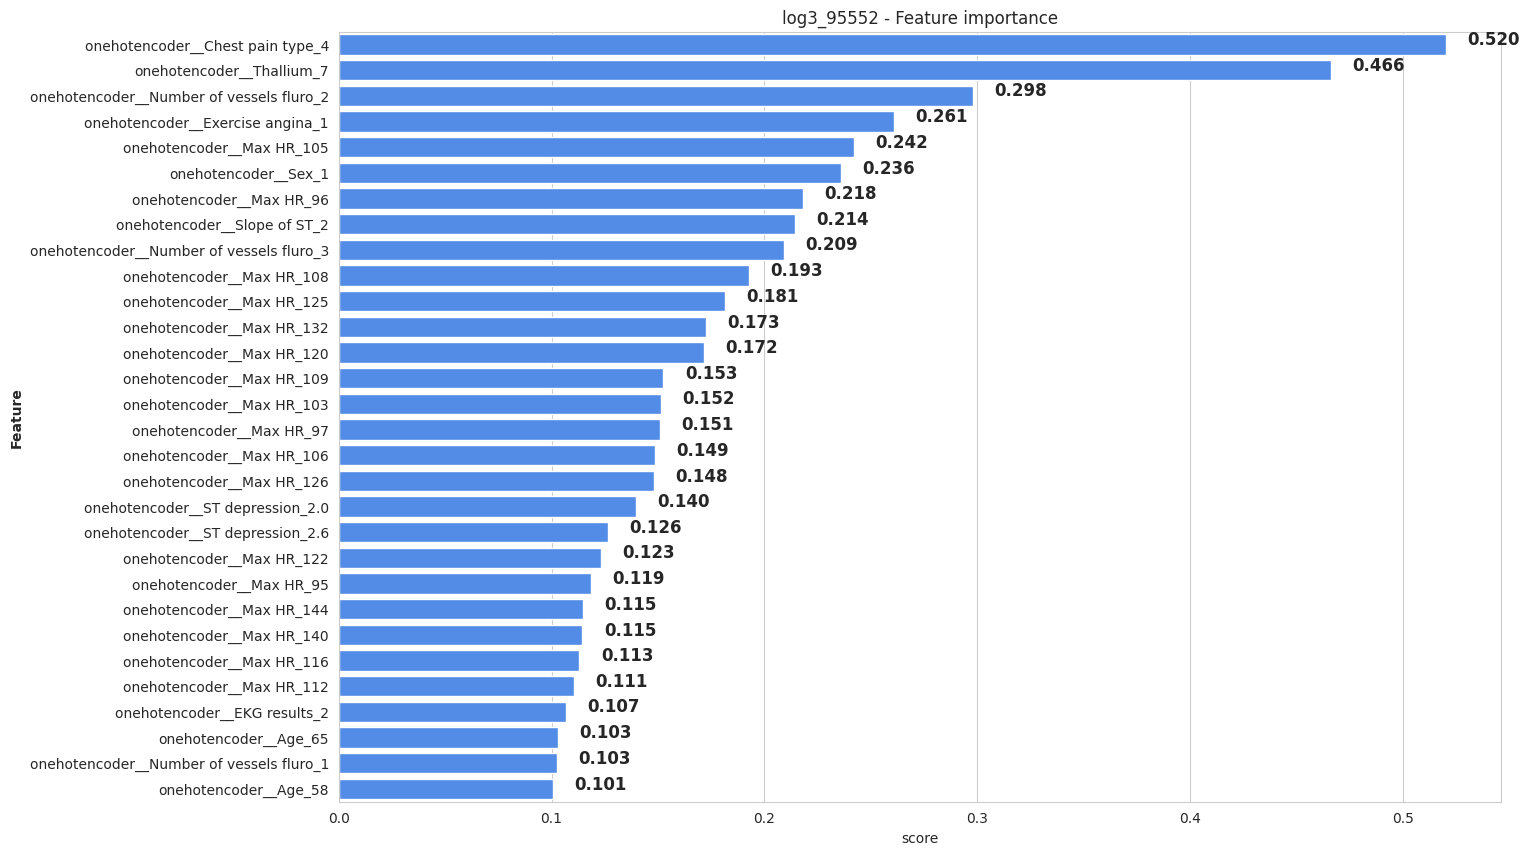

In [61]:
## -- Feature Importances: Linear Model --
for i, name in enumerate(list(LINEAR_MODELS_3.keys())):
    if 'log' in name:
        coef_dict = dict(
            zip(
                LINEAR_MODELS_3[name][0].get_feature_names_out(),
                LINEAR_MODELS_3[name][-1].coef_[0]
            )
        )
    else:
        coef_dict = dict(
            zip(
                LINEAR_MODELS_3[name][0].get_feature_names_out(),
                LINEAR_MODELS_3[name][-1].coef_
            )
        )
    # print(coef_dict)
    
    reg_imp = pd.DataFrame.from_dict(
        coef_dict,
        orient='index',
        columns=['score']
    ).sort_values('score', ascending=False).iloc[:30] # -> Top 30 features
    reg_imp.columns = ['score']
    
    plt.figure(figsize=(15, 10))
    sns.barplot(data=reg_imp, x='score', y=reg_imp.index)
    plt.ylabel('Feature', fontweight='semibold')
    plt.title(f'{name} - Feature importance')
    
    for i, t in enumerate(reg_imp['score'].values):
        plt.text(t+1e-2, i, f'{t:.3f}', fontdict={'size': 12, 'weight': 'bold'})
    
    # plt.tight_layout()
    plt.show()

# ~ STACKING


FOLD 1/15 | STACKING MODELS: 9

	AUC: 0.95597

FOLD 2/15 | STACKING MODELS: 9

	AUC: 0.95601

FOLD 3/15 | STACKING MODELS: 9

	AUC: 0.95579

FOLD 4/15 | STACKING MODELS: 9

	AUC: 0.95559

FOLD 5/15 | STACKING MODELS: 9

	AUC: 0.95417

FOLD 6/15 | STACKING MODELS: 9

	AUC: 0.9546

FOLD 7/15 | STACKING MODELS: 9

	AUC: 0.95575

FOLD 8/15 | STACKING MODELS: 9

	AUC: 0.95591

FOLD 9/15 | STACKING MODELS: 9

	AUC: 0.95515

FOLD 10/15 | STACKING MODELS: 9

	AUC: 0.95487

FOLD 11/15 | STACKING MODELS: 9

	AUC: 0.9547

FOLD 12/15 | STACKING MODELS: 9

	AUC: 0.95609

FOLD 13/15 | STACKING MODELS: 9

	AUC: 0.95678

FOLD 14/15 | STACKING MODELS: 9

	AUC: 0.95559

FOLD 15/15 | STACKING MODELS: 9

	AUC: 0.95578
|------------------------------
| OOF AUC: 0.95551
| AVG AUC: 0.95552 ± 0.00066
|------------------------------
| Time: 74.34 secs


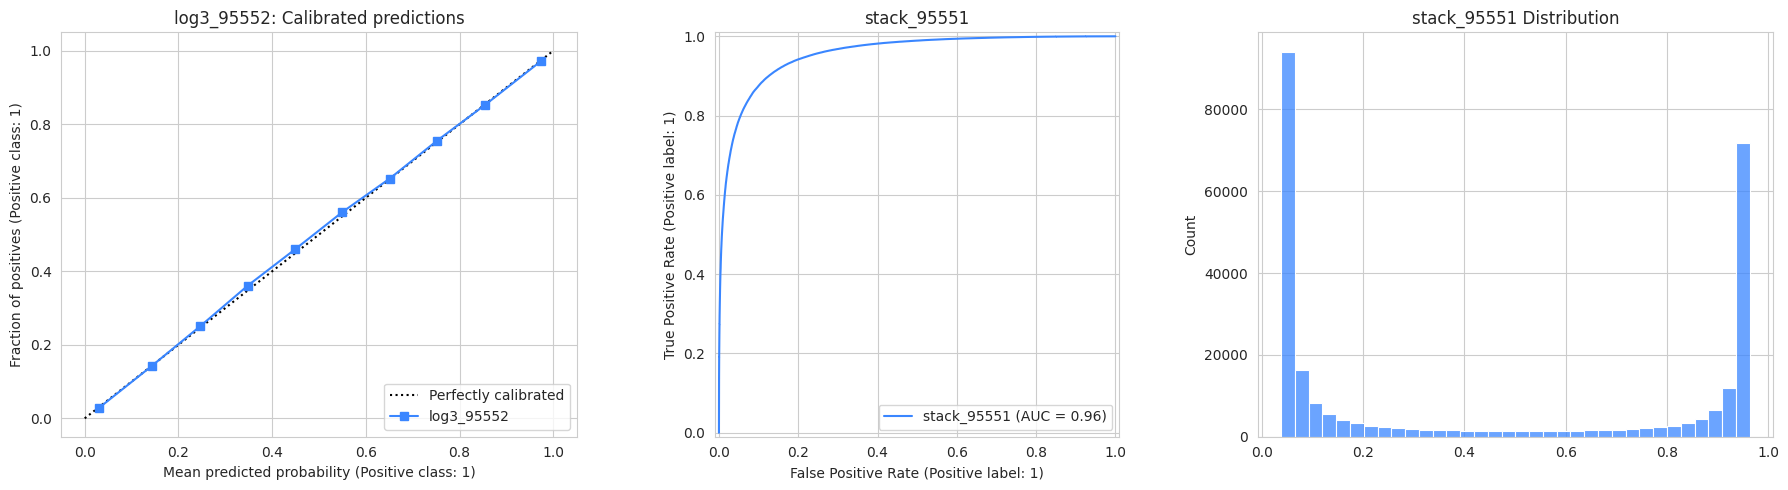

In [62]:
## -- Define Training Parameters --
stack_oof_preds  = np.zeros(len(oof_final))
stack_test_preds = np.zeros(len(test_final))
fold_scores = []

## -- Split data --
X = oof_final
y = train[TARGET].values

## -- Initiate Training --
tik = time()
for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"\nFOLD {fold+1}/{kf.n_splits} | STACKING MODELS: {X.shape[1]}", end='')
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    X_test = test_final.copy()

    for c in oof_final.columns:
        scaler = StandardScaler()
        X_train[c] = scaler.fit_transform(X_train[[c]], y_train)
        X_val[c]   = scaler.transform(X_val[[c]])
        X_test[c]  = scaler.transform(X_test[[c]])
    
    meta_model = LogisticRegressionCV(
        max_iter=1000,
        tol=1e-5,
        cv=N_SPLITS,
        random_state=SEED,
        scoring='roc_auc',
        n_jobs=os.cpu_count(),
    )
    
    meta_model.fit(X_train, y_train)

    stack_oof_preds[val_idx] = meta_model.predict_proba(X_val)[:,1]
    oof_score = np.round(roc_auc_score(y_val, meta_model.predict_proba(X_val)[:,1]), 5)
    fold_scores.append(oof_score)
    print(f"\tAUC: {oof_score}")

    stack_test_preds += meta_model.predict_proba(X_test)[:,1]

stack_test_preds /= kf.n_splits

tok = time()
tiktok = (tok-tik)

## -- After all folds --
stack_score = np.round(roc_auc_score(y, stack_oof_preds), 5)
stack_name = 'stack_' + stack_score.astype(str).split('.')[1]

oof_final[stack_name]    = stack_oof_preds
test_final[stack_name]   = stack_test_preds
model_scores[stack_name] = stack_score

print(f"|{'-'*30}")
print(f"| OOF AUC: {stack_score}")
print(f"| AVG AUC: {np.mean(fold_scores):.5f} ± {np.std(fold_scores):.5f}{RESET}")
print(f"|{'-'*30}")
print(f"| Time: {tiktok:.2f} secs")

_, axs = plt.subplots(1, 3, figsize=(18, 5))
# Right: Confusion matrix (threshold = 0.5)
# pred_labels = (stack_oof_preds >= 0.5).astype('int8')
# ConfusionMatrixDisplay.from_predictions(y, pred_labels, cmap='Blues', colorbar=False, ax=axs[0])
# axs[0].set_title(f"{stack_name} Confusion Matrix")
# axs[0].grid(False)
CalibrationDisplay.from_predictions(y, oof_preds, n_bins=10, name=name, ax=axs[0])
axs[0].set_title(f"{name}: Calibrated predictions")

# Left: ROC curve
RocCurveDisplay.from_predictions(y, stack_oof_preds, name=stack_name, ax=axs[1])
axs[1].set_title(f"{stack_name}")
# axs[1].grid(False)

sns.histplot(stack_test_preds, ax=axs[2])
axs[2].set_title(f"{stack_name} Distribution")

plt.tight_layout()
plt.show()

# ~ HILLCLIMB

In [63]:
try:
    from hillclimbers import climb_hill, partial
except:
    !pip install -q -U hillclimbers
    from hillclimbers import climb_hill, partial


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [64]:
%%time

## -- Run hillclimber --
hc_test_preds, hc_oof_preds = climb_hill(
        train=train,
        target=TARGET,
        oof_pred_df=oof_final.drop([stack_name], axis=1),
        test_pred_df=test_final.drop([stack_name], axis=1),
        eval_metric=partial(roc_auc_score),
        objective='maximize',
        # negative_weights=True,
        return_oof_preds=True,
        precision=0.001,
        plot_hill=True,
        plot_hist=False,
)


   /\  
  /__\  hillclimbers 
 /    \
/______\ 



Models to be ensembled | (9 total): 

log3_95552:  0.95552 (best solo model)
log2v_95551: 0.95551
cat_95535:   0.95535
xgb_95489:   0.95489
lgb_95478:   0.95478
hist_95475:  0.95475
mlp_95308:   0.95308
log_95288:   0.95288
rfc_94703:   0.94703

[Data preparation completed successfully] - [Initiate hill climbing] 



Iteration: 1 | Model added: cat_95535 | Best weight: 0.375 | Best roc_auc_score: 0.95563


Iteration: 2 | Model added: xgb_95489 | Best weight: 0.101 | Best roc_auc_score: 0.95564


Iteration: 3 | Model added: lgb_95478 | Best weight: 0.054 | Best roc_auc_score: 0.95565


Iteration: 4 | Model added: log2v_95551 | Best weight: 0.120 | Best roc_auc_score: 0.95565


Iteration: 5 | Model added: hist_95475 | Best weight: 0.013 | Best roc_auc_score: 0.95565


CPU times: user 32min 26s, sys: 2.89 s, total: 32min 29s
Wall time: 32min 29s


In [65]:
hc_score = np.round(roc_auc_score(y, hc_oof_preds), 5)
hc_name = 'hill_' + hc_score.astype(str).split('.')[1]

oof_final[hc_name]  = hc_oof_preds
test_final[hc_name] = hc_test_preds

model_scores[hc_name] = hc_score
model_scores.sort_values(inplace=True)
model_scores

rfc_94703      0.94703
log_95288      0.95288
mlp_95308      0.95308
hist_95475     0.95475
lgb_95478      0.95478
xgb_95489      0.95489
cat_95535      0.95535
log2v_95551    0.95551
stack_95551    0.95551
log3_95552     0.95552
hill_95565     0.95565
dtype: float64

xgb_95489  lgb_95478  cat_95535  rfc_94703  hist_95475  log_95288  \
0   0.997946   0.993845   0.997511       1.00    0.993759   0.997335   
1   0.013199   0.015091   0.009971       0.00    0.015873   0.016922   
2   0.010473   0.016439   0.008023       0.00    0.014615   0.018193   
3   0.040837   0.032891   0.049943       0.02    0.033720   0.054209   
4   0.997911   0.994178   0.998130       1.00    0.995620   0.997383   

   mlp_95308  log2v_95551  log3_95552  stack_95551  hill_95565  
0   0.995525     0.998155    0.998181     0.963158    0.997712  
1   0.009919     0.009917    0.009106     0.039303    0.010150  
2   0.017311     0.010058    0.010040     0.039548    0.009879  
3   0.034389     0.064168    0.064126     0.053569    0.056409  
4   0.998016     0.996730    0.996763     0.963084    0.997097

xgb_95489  lgb_95478  cat_95535  rfc_94703  hist_95475  log_95288  \
0   0.967923   0.936225   0.957620   0.846667    0.938938   0.897588   
1   0.009701   0.009110   0.007061   0.000667    0.009044   0.004807   
2   0.987516   0.981949   0.990093   0.997333    0.982425   0.989525   
3   0.007241   0.006164   0.003831   0.004667    0.006200   0.005556   
4   0.196940   0.195864   0.198390   0.219333    0.197998   0.272567   

   mlp_95308  log2v_95551  log3_95552  stack_95551  hill_95565  
0   0.931982     0.941143    0.941628     0.946738    0.947894  
1   0.004018     0.009188    0.009182     0.039135    0.008633  
2   0.991841     0.992237    0.992302     0.962125    0.990671  
3   0.002921     0.004708    0.004698     0.038354    0.004758  
4   0.372086     0.179517    0.169062     0.133485    0.182371

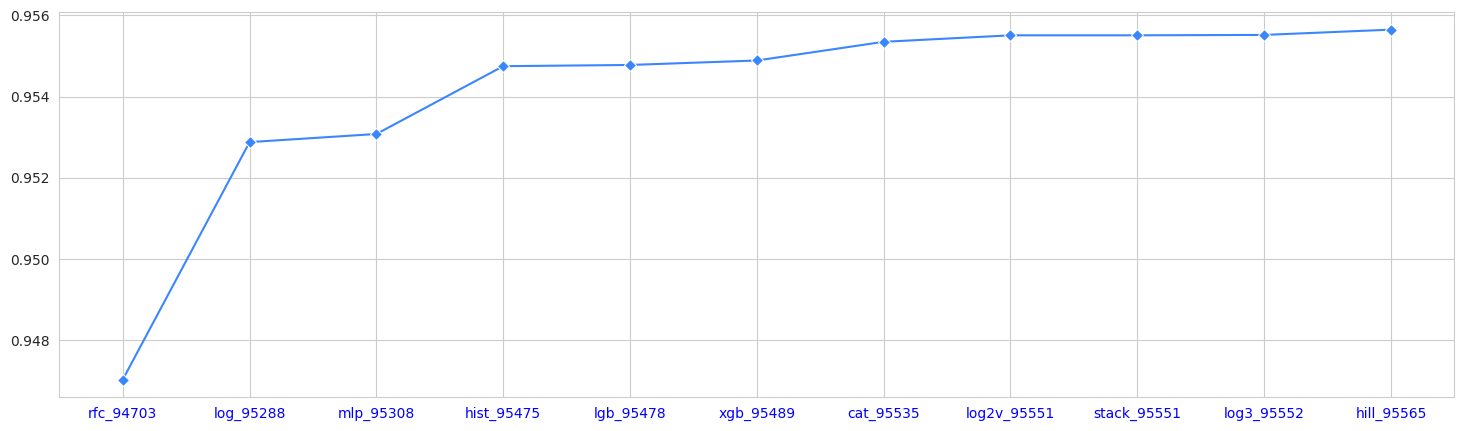

In [66]:
display(oof_final.head())
print()
display(test_final.head())
print()
plt.figure(figsize=(18, 5))
sns.lineplot(model_scores.sort_values(), marker='D')
plt.tick_params(axis='x', labelcolor='b')
# plt.tight_layout()
plt.show()

# SUBMISSION

In [67]:
## -- Export OOF & TEST predictions for each model --
n_oof = f'oof_BASE_hc-stack.parquet'
n_pred = f'test_BASE_hc-stack.parquet'

oof_final.iloc[:, -2:].to_parquet(n_oof, index=False)
test_final.iloc[:, -2:].to_parquet(n_pred, index=False)

print(n_oof, n_pred)

oof_BASE_hc-stack.parquet test_BASE_hc-stack.parquet


In [68]:
## -- Create Submission files --
for i, c in enumerate(test_final.columns):
    submit[TARGET] = test_final[c].values.ravel()
    submit.to_csv(f"submit_BASE_{c}.csv", index=False)
    print(f" -> submit_BASE_{c}.csv file saved!")

 -> submit_BASE_xgb_95489.csv file saved!


 -> submit_BASE_lgb_95478.csv file saved!


 -> submit_BASE_cat_95535.csv file saved!


 -> submit_BASE_rfc_94703.csv file saved!


 -> submit_BASE_hist_95475.csv file saved!


 -> submit_BASE_log_95288.csv file saved!


 -> submit_BASE_mlp_95308.csv file saved!


 -> submit_BASE_log2v_95551.csv file saved!


 -> submit_BASE_log3_95552.csv file saved!


 -> submit_BASE_stack_95551.csv file saved!


 -> submit_BASE_hill_95565.csv file saved!
